# Run `Background` for multiple targets

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd

In [2]:
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, unique, join

In [3]:
import glob
import subprocess

In [4]:
sys.path.insert(0, "./results/python")
import background as bg

In [5]:
from matplotlib import pyplot as plt

In [6]:
# Set-up names and which background model to fit
# Define model
model_name = 'OneHarvey'

# Is there a prefix to your star IDs?
prefix = 'CRT0'

# What is the number of the run you want to initiate?
resultsubdir = '30'

# What is the name of the projects directory?
projectidstr = 'corot' #_multi_a01'

# Do you want to use starhorse values for the initial guess on numax?
starhorse = True


In [12]:
# Do you want to estimate the numax from a logg and teff?
estimatenumax = True
# Name the table containing spectroscopic values used to estimate numax
spectrotable = 'corot_giants_v2.1.csv' # 'Corot_giants_newBC_newlogg_final.csv'

# What is the fillvalue in spectrotable?
fillvalue = -9999
# Name the colulm in spectrotable containing star ID
staridcol = 'corot_id'
# Name the columns containing logg
if starhorse:
    loggcols = ['logg50', ]
    teff = 'teff50'
else:
    loggcols = ['logg_2M_final', 'logg_09M_final']
    teff = 'teff'

# Name the column containing the effective temperature
# Name the limits within estimated numax should be used
hlimit = 120
llimit = 2

# Do you want to truncate the datafiles?
truncatedatafiles = True

In [8]:
numaxguessfiles = None
#numaxguessfiles = ['projects/corot/LRc01_PSD_No_LC_Yes.csv', 
#                   'projects/corot/LRc01_both.csv',
#                   'projects/corot/LRc01_PSD_Yes_LC_No.csv',
#                   'projects/corot/LCs_NoPSD_enero22.csv',]
mainnumaxdir = 'projects/corot'

## Set up starlist and stars

In [9]:
# Use all the stars with a .txt file in `./data`
starlist = []
for star in os.listdir('./data/'):
    if star.endswith('.txt'):
        starlist.append(star[4:-4])

In [16]:
starlist

[]

In [10]:
def estimate_numax(logg, teff, mask=None):
    gsun = ((const.G * const.M_sun) / (const.R_sun) ** 2).to(u.cm / u.second ** 2).value
    loggsun = np.log10(gsun)
    teffsun = 5772  # Kelvin, Prsa et al. 2016
    numaxsun = 3090  # µHz, Huber et al 2011
    
    # Estimate numax from log g and teff
    #if mask is None:
    #    mask = logg.mask & teff.mask
    numax = ((10 ** (logg - loggsun)) * (teff / teffsun) ** (-1/2) * numaxsun)
    #numax[mask] = fillvalue
    return numax

In [13]:
if estimatenumax:
    # Estimate numax from teff and logg for each star only once
    # Return a table with ID and estimated numax
    dirp = os.path.join('projects', projectidstr)
    df = os.path.join(dirp, spectrotable)
    reftable = Table.read(df, format='csv')
    reftable.rename_column('COROT_ID', 'corot_id')
    
    # Check for unique values
    ureftable = unique(reftable, keys=[staridcol])
    print(f'Number of unique stars {len(ureftable)} out of {len(reftable)}')
    
    numax = np.ones(len(reftable[staridcol])) * fillvalue
    origin = np.ones(len(reftable[staridcol]), dtype='int') * int(fillvalue)
    flags = np.ones(len(reftable[staridcol]), dtype='bool')
    for i, loggcol in enumerate(loggcols[::-1]):
        mask = (reftable[loggcol] == fillvalue)
        enumax = estimate_numax(reftable[loggcol], reftable[teff])
        flag = (reftable[loggcol] > 3.5)  # This is the origininal definition of the earlier flag column
        valid = ((enumax > llimit) & (enumax < hlimit) & (~mask) & (~flag))
        print(np.sum(valid))
        numax[valid] = enumax[valid]
        origin[valid] = np.ones(len(numax))[valid] * i
    
    reftable.add_column(numax, name='numax')
    reftable.add_column(origin, name='origin_estimatenumax')
    reftable.add_column(flags, name='flag_estimatenumax')
    numaxtable = reftable[staridcol, 'numax', 'origin_estimatenumax', 'flag_estimatenumax']

    # Handle non-unqiue entries
    us, cs = np.unique(reftable[staridcol][reftable['numax'] != fillvalue], return_counts=True)
    if any(cs > 1):
        print('Non-unique entries found')
        unumaxtable = unique(numaxtable, keys=[staridcol])
        nonuniques = us[cs > 1]

        # Overwrite if another nu has a better origin 
        for nu in nonuniques:
            numask = (numaxtable[staridcol] == nu) & (numaxtable['numax'] != fillvalue)
            nunumax = numaxtable['numax'][numask]
            nuorigin = numaxtable['origin_estimatenumax'][numask]
            nuflag = numaxtable['flag_estimatenumax'][numask]
            assert nunumax.shape == nuorigin.shape
            # Count how many
            best = (nuorigin == np.amax(nuorigin))
            idx = np.argwhere(unumaxtable[staridcol] == nu)[0][0]
            offset = 0

            # TODO: There is a weird error of many numax being close to 10.0??
            close = np.isclose(nunumax, 10.0)
            if any(close):
                print('nonnumax is close to 10')
                best &= ~close

            if np.sum(best) == 1:
                unumaxtable['numax'][idx] = nunumax[best]
                unumaxtable['origin_estimatenumax'][idx] = nuorigin[best]
            elif np.sum(best) > 1:
                unumaxtable['numax'][idx] = nunumax[best][0]
                unumaxtable['origin_estimatenumax'][idx] = nuorigin[best][0]
                unumaxtable['flag_estimatenumax'][idx] = 1
            else:
                offset += 1
                best = (nuorigin == (np.amax(nuorigin) - offset))
                for i, nonnumax in enumerate(nuorigin[best]):
                    if nonnumax == 10:
                        best[i] = False
                if np.sum(best) == 1:
                    unumaxtable['numax'][idx] = nunumax[best]
                    unumaxtable['origin_estimatenumax'][idx] = nuorigin[best]
                elif np.sum(best) > 1:
                    unumaxtable['numax'][idx] = nunumax[best][0]
                    unumaxtable['origin_estimatenumax'][idx] = nuorigin[best][0]
                    unumaxtable['flag_estimatenumax'][idx] = 1
                else:
                    print('No numax found for', nu)
                    unumaxtable.remove_row(idx)
                    assert nu not in unumaxtable[staridcol]
        numaxtable = unumaxtable

    fillmask = (numaxtable['numax'] != fillvalue)
    # Save file in numaxdir
    numaxdir = os.path.join(dirp,'estimatenumax/')
    print(f'Number of removed stars is {np.sum(~fillmask)} meaning the total number of stars is {len(numaxtable[fillmask])}')
    numaxtable[fillmask].write(
        os.path.join(numaxdir, 'reftable' + resultsubdir + '.txt'),
        format='csv', delimiter='\t', overwrite=True)
else:
    # Read in list of initial guesses of numax from manual inspection
    numaxdirs = [d for d in os.listdir(mainnumaxdir)
                 if os.path.isdir(os.path.join(mainnumaxdir, d))]
    print(numaxdirs)
    psd = True
    # resultsubdir = 11 for PSD
    # resultsubdir = 21 for LC

    if psd:
        numaxdir = os.path.join(mainnumaxdir, numaxdirs[0])
        print(numaxdir)
    else:
        numaxdir = os.path.join(mainnumaxdir, numaxdirs[1])
        print(numaxdir)

Number of unique stars 38867 out of 38867
30393
Number of removed stars is 8474 meaning the total number of stars is 30393


In [14]:
overlap = np.isin(reftable['corot_id'], numaxtable[~fillmask]['corot_id'])
reftable[overlap]

corot_id,run_ids,teff,logg_input,feh_input,ebv,ra,dec,twomass_id,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_mag,phot_rp_mean_mag_error,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,AJ,AH,AKs,abs_Jmag,abs_Hmag,abs_Kmag,flag_mag,BC_V_09M,BC_G_09M,BC_J_09M,BC_H_09M,BC_K_09M,BC_V_2M,BC_G_2M,BC_J_2M,BC_H_2M,BC_K_2M,logg_photo_0.9M,logg_photo_2M,flag_logg_09M,flag_logg_2M,dist05,dist16,dist50,dist84,dist95,av05,av16,av50,av84,av95,teff16,teff50,teff84,logg16,logg50,logg84,met16,met50,met84,mass16,mass50,mass84,ag50,abp50,arp50,bprp0,mg0,xgal,ygal,zgal,rgal,fidelity,bp_rp_excess_corr,sh_photoflag,sh_outflag,source,numax,origin_estimatenumax,flag_estimatenumax
int64,str27,float64,float64,float64,float64,float64,float64,str17,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str23,int64,int64,float64,int64,bool
110743869,['LRa02'],4997.15,3.0,0.0,0.17,102.404064,-5.78021,06493697-0546487,3100372002900718336,0.5036,0.024,0.732,0.027000000000000003,1.906,0.025,14.902865,0.002775,15.491779000000001,0.003647,14.167176000000001,0.003999,13.199000000000002,12.717,12.555,0.033,0.03,0.037000000000000005,0.13872249763756989,0.08207499860227108,0.05295499909818172,1.5707061095415575,1.1453536085768552,1.0124736080809438,2,-0.579,-0.382,0.879,1.188,1.302,-0.606,-0.386,0.954,1.299,1.419,3.1699214962852,3.563508982509857,2,1,1.673961877822876,1.7406799793243408,1.7727928161621094,1.954869270324707,2.0210771560668945,0.504214346408844,0.5632936954498291,0.6775527000427246,0.7084783315658569,0.9280727505683899,5002.74169921875,5095.22216796875,5174.25146484375,3.5403664112091064,3.6290783882141113,3.6559998989105225,-0.30491167306900024,-0.20541121065616608,-0.005536704324185848,0.9778895378112793,1.103681206703186,1.2255704402923584,0.5643958449363708,0.7009141445159912,0.40994369983673096,1.0336326360702515,3.095179557800293,-9.597414016723633,-1.0868366956710815,-0.09389012306928635,9.658756256103516,1.0,0.0005327463150024414,GBPRPgzy/JHKs,0,3100372002900718336,-9999.0,-9999,True
300003479,['LRa02'],4843.5,3.0,0.0,0.19,102.173459,-5.857273999999999,06484163-0551261,3100373205490819328,0.3032,0.0462,-0.16699999999999998,0.039,-1.2209999999999999,0.034,15.747101999999998,0.002798,16.391167000000006,0.005274,14.969173999999999,0.004207,13.875,13.299000000000001,13.119000000000002,0.035,0.042,0.0,0.15061299220398067,0.08910999538749456,0.05749399702399969,1.1330329925961007,0.6185359894125881,0.47015198777608325,2,-1.224,-0.704,1.359,2.073,2.265,-0.614,-0.42,0.831,1.128,1.243,3.2839405208411296,3.2219280070657863,2,2,2.586998462677002,2.603219985961914,2.985283136367798,3.1220126152038574,3.2597193717956543,0.8022636771202087,0.8285475373268127,0.9163499474525452,0.9910256862640381,1.0475552082061768,4992.4912109375,5037.76318359375,5127.41455078125,3.3188860416412354,3.4130067825317383,3.5100066661834717,-0.40022146701812744,-0.20585215091705322,-0.09497568011283875,1.003904938697815,1.1299999952316284,1.2354825735092163,0.7565630674362183,0.9438346028327942,0.5528402924537659,1.0309979915618896,2.6156110763549805,-10.553752899169922,-1.8282971382141113,-0.1705600470304489,10.710946083068848,0.984375,0.0014818906784057617,GBPRPgrizy/gJH,0,3100373205490819328,-9999.0,-9999,True
110826080,['LRa02'],4932.23,3.0,0.0,0.17,102.221627,-5.804624,06485318-0548166,3100373858325777408,0.5382,0.0313,-1.012,0.033,-2.594,0.028999999999999998,15

In [17]:
# Get estimates of the number of stars
numaxguessfiles = []
print(numaxdir)
for f in os.listdir(numaxdir):
    if f.endswith('.txt'):
        numaxguessfiles.append(os.path.join(numaxdir, f))

starlists = []
for numaxguessfile in numaxguessfiles:
    numaxlist = pd.read_csv(numaxguessfile,
                            skiprows=2,
                            usecols=[0, 1],
                            names=['ID', 'numax'],
                            dtype={'ID': str, 'numax': np.float64},
                            delim_whitespace=True)

    numaxstarlist = np.asarray(starlist, dtype=str)[np.isin(starlist, numaxlist['ID'].astype(str))]
    starlists.append(numaxstarlist)
    
print('Lengths are', len(starlist),
      [len(sl) for sl in starlists])

projects/corot/estimatenumax/
Lengths are 0 [0, 0, 0, 0]


In [23]:
# Create directories
errorfile = 'errors_' + resultsubdir + '.txt'

for star in starlist:
    star = prefix + star
    resultdir = os.path.join('./results/' + star)
    subresultdir = os.path.join(resultdir, resultsubdir)
    if not os.path.exists(resultdir):
        print('Creates', resultdir)
        os.mkdir(resultdir)
    if not os.path.exists(subresultdir):
        print('Creates', subresultdir)
        os.mkdir(subresultdir)

In [16]:
# Set-up initial background hyperparameter guesses, derived from numax
skipstars = []
badnumax = []
errors = []
starmasks = np.zeros(len(starlist), dtype=bool)
print("We have these different guesses",
      [nl for nl in numaxlist.columns if 'numax' in nl])
j = 0
for i, sl in enumerate(starlists):
    if len(sl) == 0:
        continue
    numaxlist = pd.read_csv(numaxguessfiles[i],
                            skiprows=2,
                            usecols=[0, 1],
                            names=['ID', 'numax'],
                            dtype={'ID': str, 'numax': np.float64},
                            delim_whitespace=True)
    starmask = np.isin(starlist, numaxlist['ID'].astype('str'))
    stars = np.asarray(starlist)[starmask]
    starmasks |= starmask
    print('Starlist', i)
    for star in stars:
        print('star', star)
        starmask = (numaxlist['ID'].astype(str) == star)
        print('starmask', numaxlist['ID'][starmask])
        # We have different guesses:
        numax_possibilities = [nl for nl in numaxlist.columns if 'numax' in nl]
        for i, possibility in enumerate(numax_possibilities):
            guess = numaxlist[possibility][starmask].values[0]
            print(guess)
            print(int(resultsubdir))
            if not np.isnan(guess):
                numax = guess
                break
            else:
                print(f'NaN, {i}, {len(numax_possibilities)}')
                if i == len(numax_possibilities)-1:
                    print(f'No guess for {star}, skipping it')
                    skipstars.append(star)
                    starlist.remove(star)
        try:
            j += 1
            bg.set_background_priors(catalog_id=prefix,
                                     star_id=star,
                                     numax=numax,
                                     model_name=model_name,
                                     dir_flag=int(resultsubdir))
        except ValueError as e:
            badnumax.append(star)
            if numax < 2:
                numax = 2
                bg.set_background_priors(catalog_id=prefix,
                                         star_id=star,
                                         numax=numax,
                                         model_name=model_name,
                                         dir_flag=int(resultsubdir))
            else:
                errors.append(star)

We have these different guesses ['numax']
Starlist 0
star 102689620
starmask 7434    102689620
Name: ID, dtype: object
3.122007819472506
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689620
 ---------------------------------------------- 
[[1.98631515e+03 5.95894546e+03 0.00000000e+00]
 [3.46599044e+02 2.59949283e+03 0.00000000e+00]
 [1.59718305e+00 4.39924461e+00 0.00000000e+00]
 [5.75762464e+05 8.06067450e+06 0.00000000e+00]
 [3.12200782e+00 6.29625915e-01 1.00000000e+00]
 [3.77775549e-01 8.18513690e-01 0.00000000e+00]]
star 102619910
starmask 6811    102619910
Name: ID, dtype: object
53.4341228515288
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619910
 ---------------------------------------------- 
[[4.74585164e+02 1.42375549e+03 0.00000000e+00]
 [8.78365045e+01 6.58773784e+02 0.00000000e+00]
 [2.59952983e+01 7.36030365e+01 0.00000000e+00]
 [1.27435972e+02 1.78410360e+03 0.00000000e+00]
 [5.3

[[9.33896846e+04 2.80169054e+05 0.00000000e+00]
 [9.04152246e+03 6.78114184e+04 0.00000000e+00]
 [4.58164664e+01 1.30438047e+02 0.00000000e+00]
 [4.04842868e+05 5.66780015e+06 0.00000000e+00]
 [9.51330326e+01 1.26308917e+01 1.00000000e+00]
 [7.57853503e+00 1.64201592e+01 0.00000000e+00]]
star 102624435
starmask 6855    102624435
Name: ID, dtype: object
5.714963763289311
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624435
 ---------------------------------------------- 
[[3.34688161e+03 1.00406448e+04 0.00000000e+00]
 [2.34051152e+02 1.75538364e+03 0.00000000e+00]
 [2.89233486e+00 8.01414082e+00 0.00000000e+00]
 [1.41621880e+04 1.98270631e+05 0.00000000e+00]
 [5.71496376e+00 1.07037773e+00 1.00000000e+00]
 [6.42226637e-01 1.39149105e+00 0.00000000e+00]]
star 102785961
starmask 8276    102785961
Name: ID, dtype: object
46.23717125905358
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102785961
 --------

[[1.94506796e+02 5.83520387e+02 0.00000000e+00]
 [1.62870054e+02 1.22152541e+03 0.00000000e+00]
 [2.67686113e+01 7.58141709e+01 0.00000000e+00]
 [4.44775949e+02 6.22686329e+03 0.00000000e+00]
 [5.50524954e+01 7.81525274e+00 1.00000000e+00]
 [4.68915165e+00 1.01598286e+01 0.00000000e+00]]
star 102669453
starmask 7256    102669453
Name: ID, dtype: object
39.96999543299888
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669453
 ---------------------------------------------- 
[[2.01116054e+05 6.03348161e+05 0.00000000e+00]
 [1.30680050e+04 9.80100378e+04 0.00000000e+00]
 [1.95444815e+01 5.51848444e+01 0.00000000e+00]
 [2.82180249e+06 3.95052348e+07 0.00000000e+00]
 [3.99699954e+01 5.90080391e+00 1.00000000e+00]
 [3.54048234e+00 7.67104508e+00 0.00000000e+00]]
star 102573289
starmask 6438    102573289
Name: ID, dtype: object
113.93973127438768
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102573289
 -------

star 102602044
starmask 6685    102602044
Name: ID, dtype: object
17.825672014504512
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102602044
 ---------------------------------------------- 
[[2.64610882e+02 7.93832646e+02 0.00000000e+00]
 [1.17069842e+02 8.78023817e+02 0.00000000e+00]
 [8.84131066e+00 2.47706350e+01 0.00000000e+00]
 [1.57975201e+03 2.21165281e+04 0.00000000e+00]
 [1.78256720e+01 2.90487595e+00 1.00000000e+00]
 [1.74292557e+00 3.77633873e+00 0.00000000e+00]]
star 102578934
starmask 6481    102578934
Name: ID, dtype: object
43.44563682407545
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102578934
 ---------------------------------------------- 
[[1.86648885e+05 5.59946654e+05 0.00000000e+00]
 [1.34021654e+04 1.00516240e+05 0.00000000e+00]
 [2.12128941e+01 5.99435135e+01 0.00000000e+00]
 [2.28435941e+06 3.19810317e+07 0.00000000e+00]
 [4.34456368e+01 6.34881865e+00 1.00000000e+00]
 [3.8092

[[3.38948953e+05 1.01684686e+06 0.00000000e+00]
 [1.19160174e+04 8.93701304e+04 0.00000000e+00]
 [1.12970584e+01 3.17272470e+01 0.00000000e+00]
 [1.00640457e+07 1.40896639e+08 0.00000000e+00]
 [2.28774734e+01 3.61603212e+00 1.00000000e+00]
 [2.16961927e+00 4.70084175e+00 0.00000000e+00]]
star 102573052
starmask 6433    102573052
Name: ID, dtype: object
47.48025363780888
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102573052
 ---------------------------------------------- 
[[2.30407744e+03 6.91223232e+03 0.00000000e+00]
 [2.12744918e+02 1.59558689e+03 0.00000000e+00]
 [2.31467227e+01 6.54636962e+01 0.00000000e+00]
 [8.10130441e+02 1.13418262e+04 0.00000000e+00]
 [4.74802536e+01 6.86343240e+00 1.00000000e+00]
 [4.11805944e+00 8.92246212e+00 0.00000000e+00]]
star 102721333
starmask 7743    102721333
Name: ID, dtype: object
10.94598294964583
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102721333
 --------

starmask 6940    102633757
Name: ID, dtype: object
26.612564890451672
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102633757
 ---------------------------------------------- 
[[4.52806341e+02 1.35841902e+03 0.00000000e+00]
 [1.51637027e+02 1.13727771e+03 0.00000000e+00]
 [1.31064744e+01 3.68625722e+01 0.00000000e+00]
 [7.02423062e+02 9.83392287e+03 0.00000000e+00]
 [2.66125649e+01 4.12929169e+00 1.00000000e+00]
 [2.47757502e+00 5.36807920e+00 0.00000000e+00]]
star 102711942
starmask 7659    102711942
Name: ID, dtype: object
19.62412904753009
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711942
 ---------------------------------------------- 
[[3.83896223e+05 1.15168867e+06 0.00000000e+00]
 [1.72570306e+04 1.29427730e+05 0.00000000e+00]
 [9.71680838e+00 2.72488178e+01 0.00000000e+00]
 [1.27435356e+07 1.78409499e+08 0.00000000e+00]
 [1.96241290e+01 3.16056615e+00 1.00000000e+00]
 [1.89633969e+00 4.1087

 ---------------------------------------------- 
[[1.44717679e+02 4.34153037e+02 0.00000000e+00]
 [1.60282017e+02 1.20211513e+03 0.00000000e+00]
 [7.25462195e+00 2.02856242e+01 0.00000000e+00]
 [2.61774115e+03 3.66483761e+04 0.00000000e+00]
 [1.45746307e+01 2.43432198e+00 1.00000000e+00]
 [1.46059319e+00 3.16461858e+00 0.00000000e+00]]
star 102659654
starmask 7163    102659654
Name: ID, dtype: object
89.22658909470124
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102659654
 ---------------------------------------------- 
[[1.75635898e+03 5.26907694e+03 0.00000000e+00]
 [2.09465820e+02 1.57099365e+03 0.00000000e+00]
 [4.30200641e+01 1.22402400e+02 0.00000000e+00]
 [5.13633145e+02 7.19086403e+03 0.00000000e+00]
 [8.92265891e+01 1.19399541e+01 1.00000000e+00]
 [7.16397248e+00 1.55219404e+01 0.00000000e+00]]
star 102657447
starmask 7143    102657447
Name: ID, dtype: object
71.50435378332583
20
 ---------------------------------------------- 
 Creat

[[2.29851736e+05 6.89555207e+05 0.00000000e+00]
 [1.26328057e+04 9.47460427e+04 0.00000000e+00]
 [1.74696299e+01 4.92724238e+01 0.00000000e+00]
 [3.76982123e+06 5.27774972e+07 0.00000000e+00]
 [3.56550706e+01 5.33787271e+00 1.00000000e+00]
 [3.20272362e+00 6.93923452e+00 0.00000000e+00]]
star 102761608
starmask 8093    102761608
Name: ID, dtype: object
57.74931197563232
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102761608
 ---------------------------------------------- 
[[8.17452129e+02 2.45235639e+03 0.00000000e+00]
 [1.50086660e+02 1.12564995e+03 0.00000000e+00]
 [2.80563673e+01 7.94976034e+01 0.00000000e+00]
 [5.23352479e+02 7.32693470e+03 0.00000000e+00]
 [5.77493120e+01 8.15026578e+00 1.00000000e+00]
 [4.89015947e+00 1.05953455e+01 0.00000000e+00]]
star 102725348
starmask 7780    102725348
Name: ID, dtype: object
59.81714098678922
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102725348
 --------

star 102624925
starmask 6865    102624925
Name: ID, dtype: object
56.07775267135214
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624925
 ---------------------------------------------- 
[[1.48482497e+05 4.45447492e+05 0.00000000e+00]
 [1.13431607e+04 8.50737052e+04 0.00000000e+00]
 [2.72583081e+01 7.72146794e+01 0.00000000e+00]
 [1.24807660e+06 1.74730725e+07 0.00000000e+00]
 [5.60777527e+01 7.94284713e+00 1.00000000e+00]
 [4.76570828e+00 1.03257013e+01 0.00000000e+00]]
star 102689111
starmask 7427    102689111
Name: ID, dtype: object
92.49853582055502
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689111
 ---------------------------------------------- 
[[113.78252308 341.34756925   0.        ]
 [111.40687267 835.55154499   0.        ]
 [ 44.56954926 126.85435334   0.        ]
 [ 69.3171134  970.43958756   0.        ]
 [ 92.49853582  12.32337589   1.        ]
 [  7.39402553  16.02038866   0.       

[[1.57463996e+03 4.72391988e+03 0.00000000e+00]
 [2.54280199e+02 1.90710149e+03 0.00000000e+00]
 [1.47861412e+01 4.16358361e+01 0.00000000e+00]
 [1.58265044e+03 2.21571062e+04 0.00000000e+00]
 [3.00881062e+01 4.59898246e+00 1.00000000e+00]
 [2.75938948e+00 5.97867720e+00 0.00000000e+00]]
star 102645263
starmask 7029    102645263
Name: ID, dtype: object
55.94579275586508
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102645263
 ---------------------------------------------- 
[[2.64724646e+03 7.94173939e+03 0.00000000e+00]
 [2.47111109e+02 1.85333332e+03 0.00000000e+00]
 [2.71952885e+01 7.70344328e+01 0.00000000e+00]
 [9.84408271e+02 1.37817158e+04 0.00000000e+00]
 [5.59457928e+01 7.92644068e+00 1.00000000e+00]
 [4.75586441e+00 1.03043729e+01 0.00000000e+00]]
star 102577833
starmask 6476    102577833
Name: ID, dtype: object
36.04048494064636
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102577833
 --------

[[3.12500718e+02 9.37502154e+02 0.00000000e+00]
 [1.16638077e+02 8.74785576e+02 0.00000000e+00]
 [8.89416196e+00 2.49201705e+01 0.00000000e+00]
 [6.71937939e+02 9.40713115e+03 0.00000000e+00]
 [1.79341525e+01 2.92038540e+00 1.00000000e+00]
 [1.75223124e+00 3.79650102e+00 0.00000000e+00]]
star 102653449
starmask 7106    102653449
Name: ID, dtype: object
24.77107121409693
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102653449
 ---------------------------------------------- 
[[3.07717502e+02 9.23152506e+02 0.00000000e+00]
 [1.47192301e+02 1.10394226e+03 0.00000000e+00]
 [1.22149851e+01 3.43315037e+01 0.00000000e+00]
 [6.44809789e+02 9.02733705e+03 0.00000000e+00]
 [2.47710712e+01 3.87742715e+00 1.00000000e+00]
 [2.32645629e+00 5.04065530e+00 0.00000000e+00]]
star 102599730
starmask 6656    102599730
Name: ID, dtype: object
20.049981198482342
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102599730
 -------

starmask 6547    102585966
Name: ID, dtype: object
41.16323286065711
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102585966
 ---------------------------------------------- 
[[2.07998346e+05 6.23995037e+05 0.00000000e+00]
 [1.34913840e+04 1.01185380e+05 0.00000000e+00]
 [2.01175462e+01 5.68189229e+01 0.00000000e+00]
 [2.67883115e+06 3.75036361e+07 0.00000000e+00]
 [4.11632329e+01 6.05513136e+00 1.00000000e+00]
 [3.63307881e+00 7.87167077e+00 0.00000000e+00]]
star 102622204
starmask 6835    102622204
Name: ID, dtype: object
18.85684495453141
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102622204
 ---------------------------------------------- 
[[7.93622156e+02 2.38086647e+03 0.00000000e+00]
 [1.25419221e+02 9.40644159e+02 0.00000000e+00]
 [9.34347080e+00 2.61917716e+01 0.00000000e+00]
 [8.05067930e+02 1.12709510e+04 0.00000000e+00]
 [1.88568450e+01 3.05184651e+00 1.00000000e+00]
 [1.83110791e+00 3.96740

starmask 7112    102654092
Name: ID, dtype: object
75.64090879081567
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102654092
 ---------------------------------------------- 
[[5.88872587e+02 1.76661776e+03 0.00000000e+00]
 [1.77056633e+02 1.32792475e+03 0.00000000e+00]
 [3.65753292e+01 1.03902568e+02 0.00000000e+00]
 [2.89905219e+02 4.05867307e+03 0.00000000e+00]
 [7.56409088e+01 1.03286073e+01 1.00000000e+00]
 [6.19716436e+00 1.34271894e+01 0.00000000e+00]]
star 102686562
starmask 7404    102686562
Name: ID, dtype: object
5.464309366677768
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686562
 ---------------------------------------------- 
[[2.45996086e+02 7.37988257e+02 0.00000000e+00]
 [2.40532081e+02 1.80399061e+03 0.00000000e+00]
 [2.76768907e+00 7.66539596e+00 0.00000000e+00]
 [6.43981930e+03 9.01574702e+04 0.00000000e+00]
 [5.46430937e+00 1.02906286e+00 1.00000000e+00]
 [6.17437715e-01 1.33778

[[2.27565087e+05 6.82695260e+05 0.00000000e+00]
 [1.22281908e+04 9.17114307e+04 0.00000000e+00]
 [1.70575119e+01 4.80988484e+01 0.00000000e+00]
 [3.50118160e+06 4.90165424e+07 0.00000000e+00]
 [3.47990689e+01 5.22523364e+00 1.00000000e+00]
 [3.13514019e+00 6.79280374e+00 0.00000000e+00]]
star 102622075
starmask 6833    102622075
Name: ID, dtype: object
22.73981352026233
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102622075
 ---------------------------------------------- 
[[5.27394275e+02 1.58218282e+03 0.00000000e+00]
 [2.33875975e+02 1.75406981e+03 0.00000000e+00]
 [1.12302768e+01 3.15378585e+01 0.00000000e+00]
 [2.15630025e+03 3.01882036e+04 0.00000000e+00]
 [2.27398135e+01 3.59692848e+00 1.00000000e+00]
 [2.15815709e+00 4.67600703e+00 0.00000000e+00]]
star 102718735
starmask 7722    102718735
Name: ID, dtype: object
27.35174510194527
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102718735
 --------

[[2.54664046e+06 7.63992137e+06 0.00000000e+00]
 [3.16978878e+04 2.37734159e+05 0.00000000e+00]
 [1.48631563e+00 4.09091063e+00 0.00000000e+00]
 [2.10385517e+09 2.94539724e+10 0.00000000e+00]
 [2.90149193e+00 5.90421357e-01 1.00000000e+00]
 [3.54252814e-01 7.67547764e-01 0.00000000e+00]]
star 102648239
starmask 7061    102648239
Name: ID, dtype: object
42.91718513305797
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102648239
 ---------------------------------------------- 
[[5.41201923e+02 1.62360577e+03 0.00000000e+00]
 [1.25505580e+02 9.41291850e+02 0.00000000e+00]
 [2.09593763e+01 5.92201872e+01 0.00000000e+00]
 [2.71121392e+02 3.79569948e+03 0.00000000e+00]
 [4.29171851e+01 6.28099192e+00 1.00000000e+00]
 [3.76859515e+00 8.16528950e+00 0.00000000e+00]]
star 102699527
starmask 7533    102699527
Name: ID, dtype: object
99.44071901869218
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102699527
 --------

starmask 7595    102706286
Name: ID, dtype: object
64.24099397023984
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102706286
 ---------------------------------------------- 
[[1.31349491e+05 3.94048472e+05 0.00000000e+00]
 [1.04479074e+04 7.83593055e+04 0.00000000e+00]
 [3.11520057e+01 8.83587067e+01 0.00000000e+00]
 [8.98898464e+05 1.25845785e+07 0.00000000e+00]
 [6.42409940e+01 8.94904950e+00 1.00000000e+00]
 [5.36942970e+00 1.16337643e+01 0.00000000e+00]]
star 102774232
starmask 8189    102774232
Name: ID, dtype: object
51.9788605238281
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102774232
 ---------------------------------------------- 
[[1.58910890e+05 4.76732671e+05 0.00000000e+00]
 [1.14871129e+04 8.61533471e+04 0.00000000e+00]
 [2.52995768e+01 7.16142977e+01 0.00000000e+00]
 [1.48801945e+06 2.08322723e+07 0.00000000e+00]
 [5.19788605e+01 7.43096621e+00 1.00000000e+00]
 [4.45857973e+00 9.660256

[[1.65158121e+05 4.95474363e+05 0.00000000e+00]
 [1.14513468e+04 8.58851009e+04 0.00000000e+00]
 [2.45521605e+01 6.94783730e+01 0.00000000e+00]
 [1.78054916e+06 2.49276883e+07 0.00000000e+00]
 [5.04162580e+01 7.23454046e+00 1.00000000e+00]
 [4.34072428e+00 9.40490260e+00 0.00000000e+00]]
star 102722703
starmask 7758    102722703
Name: ID, dtype: object
35.77715292827191
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102722703
 ---------------------------------------------- 
[[2.22756900e+05 6.68270700e+05 0.00000000e+00]
 [1.23649488e+04 9.27371163e+04 0.00000000e+00]
 [1.75283917e+01 4.94397798e+01 0.00000000e+00]
 [3.49596360e+06 4.89434904e+07 0.00000000e+00]
 [3.57771529e+01 5.35391008e+00 1.00000000e+00]
 [3.21234605e+00 6.96008310e+00 0.00000000e+00]]
star 102598832
starmask 6647    102598832
Name: ID, dtype: object
57.11211298215101
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102598832
 --------

[[4.37829758e+02 1.31348927e+03 0.00000000e+00]
 [3.42109415e+02 2.56582061e+03 0.00000000e+00]
 [4.79408718e+00 1.33505432e+01 0.00000000e+00]
 [1.07104796e+04 1.49946714e+05 0.00000000e+00]
 [9.55966964e+00 1.68124583e+00 1.00000000e+00]
 [1.00874750e+00 2.18561958e+00 0.00000000e+00]]
star 102766657
starmask 8134    102766657
Name: ID, dtype: object
57.70725264337994
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102766657
 ---------------------------------------------- 
[[1.25295819e+03 3.75887456e+03 0.00000000e+00]
 [2.55410593e+02 1.91557945e+03 0.00000000e+00]
 [2.80362917e+01 7.94401676e+01 0.00000000e+00]
 [5.20794345e+02 7.29112083e+03 0.00000000e+00]
 [5.77072526e+01 8.14505586e+00 1.00000000e+00]
 [4.88703352e+00 1.05885726e+01 0.00000000e+00]]
star 102583488
starmask 6524    102583488
Name: ID, dtype: object
6.426945063861624
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102583488
 --------

[[2.98655768e+02 8.95967303e+02 0.00000000e+00]
 [1.45342775e+02 1.09007081e+03 0.00000000e+00]
 [1.43877135e+01 4.05030895e+01 0.00000000e+00]
 [7.11253343e+02 9.95754681e+03 0.00000000e+00]
 [2.92630176e+01 4.48810908e+00 1.00000000e+00]
 [2.69286545e+00 5.83454181e+00 0.00000000e+00]]
star 102702294
starmask 7563    102702294
Name: ID, dtype: object
21.42637212170318
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102702294
 ---------------------------------------------- 
[[3.68309585e+05 1.10492875e+06 0.00000000e+00]
 [1.11059594e+04 8.32946957e+04 0.00000000e+00]
 [1.05927366e+01 2.97303930e+01 0.00000000e+00]
 [1.14265085e+07 1.59971119e+08 0.00000000e+00]
 [2.14263721e+01 3.41393071e+00 1.00000000e+00]
 [2.04835843e+00 4.43810993e+00 0.00000000e+00]]
star 102645920
starmask 7032    102645920
Name: ID, dtype: object
5.892037400126076
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102645920
 --------

starmask 7474    102694651
Name: ID, dtype: object
93.7299271947626
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102694651
 ---------------------------------------------- 
[[1.96636877e+03 5.89910631e+03 0.00000000e+00]
 [2.37592889e+02 1.78194667e+03 0.00000000e+00]
 [4.51524471e+01 1.28529509e+02 0.00000000e+00]
 [5.80951251e+02 8.13331752e+03 0.00000000e+00]
 [9.37299272e+01 1.24672436e+01 1.00000000e+00]
 [7.48034614e+00 1.62074166e+01 0.00000000e+00]]
star 102669423
starmask 7255    102669423
Name: ID, dtype: object
37.31347297462893
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669423
 ---------------------------------------------- 
[[1.47086244e+03 4.41258733e+03 0.00000000e+00]
 [3.91730621e+02 2.93797965e+03 0.00000000e+00]
 [1.82675720e+01 5.15454510e+01 0.00000000e+00]
 [1.75305348e+03 2.45427487e+04 0.00000000e+00]
 [3.73134730e+01 5.55516521e+00 1.00000000e+00]
 [3.33309913e+00 7.221714

[[1.40079965e+03 4.20239894e+03 0.00000000e+00]
 [1.76341938e+02 1.32256454e+03 0.00000000e+00]
 [1.13003769e+01 3.17366585e+01 0.00000000e+00]
 [1.36690937e+03 1.91367311e+04 0.00000000e+00]
 [2.28843144e+01 3.61698111e+00 1.00000000e+00]
 [2.17018867e+00 4.70207544e+00 0.00000000e+00]]
star 102659159
starmask 7155    102659159
Name: ID, dtype: object
52.49138339377652
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102659159
 ---------------------------------------------- 
[[3.61721055e+02 1.08516316e+03 0.00000000e+00]
 [1.20808349e+02 9.06062615e+02 0.00000000e+00]
 [2.55446383e+01 7.23147536e+01 0.00000000e+00]
 [1.91299089e+02 2.67818725e+03 0.00000000e+00]
 [5.24913834e+01 7.49523425e+00 1.00000000e+00]
 [4.49714055e+00 9.74380453e+00 0.00000000e+00]]
star 102715626
starmask 7694    102715626
Name: ID, dtype: object
15.386221330403291
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102715626
 -------

[[5.14612521e+02 1.54383756e+03 0.00000000e+00]
 [1.29707751e+02 9.72808131e+02 0.00000000e+00]
 [1.40459578e+01 3.95317050e+01 0.00000000e+00]
 [9.51712190e+02 1.33239707e+04 0.00000000e+00]
 [2.85556126e+01 4.39274511e+00 1.00000000e+00]
 [2.63564706e+00 5.71056864e+00 0.00000000e+00]]
star 102686629
starmask 7406    102686629
Name: ID, dtype: object
27.697256357176453
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686629
 ---------------------------------------------- 
[[1.22887701e+03 3.68663102e+03 0.00000000e+00]
 [1.26697242e+02 9.50229314e+02 0.00000000e+00]
 [1.36310764e+01 3.83527803e+01 0.00000000e+00]
 [8.49028348e+02 1.18863969e+04 0.00000000e+00]
 [2.76972564e+01 4.27664212e+00 1.00000000e+00]
 [2.56598527e+00 5.55963476e+00 0.00000000e+00]]
star 102611950
starmask 6747    102611950
Name: ID, dtype: object
45.356562023336224
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611950
 ------

[[2.98268300e+03 8.94804901e+03 0.00000000e+00]
 [2.38533491e+02 1.78900118e+03 0.00000000e+00]
 [1.94938730e+01 5.50405576e+01 0.00000000e+00]
 [1.23590707e+03 1.73026990e+04 0.00000000e+00]
 [3.98646478e+01 5.88715191e+00 1.00000000e+00]
 [3.53229114e+00 7.65329748e+00 0.00000000e+00]]
star 102792133
starmask 8320    102792133
Name: ID, dtype: object
80.63620208987402
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102792133
 ---------------------------------------------- 
[[1.12181125e+05 3.36543374e+05 0.00000000e+00]
 [9.97258733e+03 7.47944050e+04 0.00000000e+00]
 [3.89471450e+01 1.10707596e+02 0.00000000e+00]
 [5.72365761e+05 8.01312066e+06 0.00000000e+00]
 [8.06362021e+01 1.09248930e+01 1.00000000e+00]
 [6.55493578e+00 1.42023609e+01 0.00000000e+00]]
star 102595462
starmask 6621    102595462
Name: ID, dtype: object
29.39384158492159
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102595462
 --------

starmask 6511    102582237
Name: ID, dtype: object
51.29779382091871
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582237
 ---------------------------------------------- 
[[4.20401117e+02 1.26120335e+03 0.00000000e+00]
 [1.36867520e+02 1.02650640e+03 0.00000000e+00]
 [2.49738612e+01 7.06834102e+01 0.00000000e+00]
 [6.06269199e+02 8.48776878e+03 0.00000000e+00]
 [5.12977938e+01 7.34544336e+00 1.00000000e+00]
 [4.40726602e+00 9.54907637e+00 0.00000000e+00]]
star 102584392
starmask 6528    102584392
Name: ID, dtype: object
24.291667175072572
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102584392
 ---------------------------------------------- 
[[3.13744401e+05 9.41233203e+05 0.00000000e+00]
 [1.43645470e+04 1.07734102e+05 0.00000000e+00]
 [1.19827127e+01 3.36723371e+01 0.00000000e+00]
 [7.88752545e+06 1.10425356e+08 0.00000000e+00]
 [2.42916672e+01 3.81148813e+00 1.00000000e+00]
 [2.28689288e+00 4.9549

starmask 7362    102681264
Name: ID, dtype: object
23.47803051990952
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681264
 ---------------------------------------------- 
[[1.01783888e+03 3.05351664e+03 0.00000000e+00]
 [2.17725050e+02 1.63293787e+03 0.00000000e+00]
 [1.15883192e+01 3.25533709e+01 0.00000000e+00]
 [2.59132178e+03 3.62785049e+04 0.00000000e+00]
 [2.34780305e+01 3.69921074e+00 1.00000000e+00]
 [2.21952644e+00 4.80897396e+00 0.00000000e+00]]
star 102623953
starmask 6850    102623953
Name: ID, dtype: object
64.66445250909786
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102623953
 ---------------------------------------------- 
[[3.25538973e+03 9.76616918e+03 0.00000000e+00]
 [2.30545925e+02 1.72909444e+03 0.00000000e+00]
 [3.13537418e+01 8.89364677e+01 0.00000000e+00]
 [1.07325132e+03 1.50255185e+04 0.00000000e+00]
 [6.46644525e+01 9.00080126e+00 1.00000000e+00]
 [5.40048076e+00 1.17010

[[1.20945815e+05 3.62837445e+05 0.00000000e+00]
 [9.41691658e+03 7.06268743e+04 0.00000000e+00]
 [3.45175811e+01 9.80020422e+01 0.00000000e+00]
 [7.51119275e+05 1.05156699e+07 0.00000000e+00]
 [7.13117043e+01 9.80792981e+00 1.00000000e+00]
 [5.88475789e+00 1.27503088e+01 0.00000000e+00]]
star 102689251
starmask 7428    102689251
Name: ID, dtype: object
48.8819530508317
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689251
 ---------------------------------------------- 
[[1.66802101e+05 5.00406304e+05 0.00000000e+00]
 [1.11590318e+04 8.36927381e+04 0.00000000e+00]
 [2.38178865e+01 6.73806130e+01 0.00000000e+00]
 [1.81975747e+06 2.54766046e+07 0.00000000e+00]
 [4.88819531e+01 7.04094578e+00 1.00000000e+00]
 [4.22456747e+00 9.15322951e+00 0.00000000e+00]]
star 102785658
starmask 8274    102785658
Name: ID, dtype: object
4.615927115348512
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102785658
 ---------

[[9.32224465e+02 2.79667340e+03 0.00000000e+00]
 [2.27452812e+02 1.70589609e+03 0.00000000e+00]
 [3.92005518e+01 1.11434889e+02 0.00000000e+00]
 [2.48864353e+02 3.48410095e+03 0.00000000e+00]
 [8.11702275e+01 1.09883673e+01 1.00000000e+00]
 [6.59302036e+00 1.42848774e+01 0.00000000e+00]]
star 102600978
starmask 6665    102600978
Name: ID, dtype: object
33.84804237401873
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102600978
 ---------------------------------------------- 
[[8.13020489e+02 2.43906147e+03 0.00000000e+00]
 [1.38985328e+02 1.04238996e+03 0.00000000e+00]
 [1.65994366e+01 4.67947233e+01 0.00000000e+00]
 [5.50826628e+03 7.71157279e+04 0.00000000e+00]
 [3.38480424e+01 5.09969195e+00 1.00000000e+00]
 [3.05981517e+00 6.62959954e+00 0.00000000e+00]]
star 102670966
starmask 7272    102670966
Name: ID, dtype: object
44.23233414356032
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102670966
 --------

[[1.95137895e+05 5.85413686e+05 0.00000000e+00]
 [1.20104874e+04 9.00786557e+04 0.00000000e+00]
 [2.10041635e+01 5.93479661e+01 0.00000000e+00]
 [2.52699318e+06 3.53779045e+07 0.00000000e+00]
 [4.30105348e+01 6.29298074e+00 1.00000000e+00]
 [3.77578844e+00 8.18087496e+00 0.00000000e+00]]
star 102634008
starmask 6943    102634008
Name: ID, dtype: object
25.591538632859688
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102634008
 ---------------------------------------------- 
[[1.41711679e+03 4.25135036e+03 0.00000000e+00]
 [1.42162152e+02 1.06621614e+03 0.00000000e+00]
 [1.26123217e+01 3.54593869e+01 0.00000000e+00]
 [1.02161832e+03 1.43026565e+04 0.00000000e+00]
 [2.55915386e+01 3.98991729e+00 1.00000000e+00]
 [2.39395037e+00 5.18689247e+00 0.00000000e+00]]
star 102739603
starmask 7904    102739603
Name: ID, dtype: object
12.221202836246944
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102739603
 ------

[[1.92369845e+05 5.77109536e+05 0.00000000e+00]
 [1.27296058e+04 9.54720435e+04 0.00000000e+00]
 [2.11028689e+01 5.96295838e+01 0.00000000e+00]
 [2.41529444e+06 3.38141221e+07 0.00000000e+00]
 [4.32162780e+01 6.31939293e+00 1.00000000e+00]
 [3.79163576e+00 8.21521082e+00 0.00000000e+00]]
star 102626343
starmask 6877    102626343
Name: ID, dtype: object
81.51658990853073
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102626343
 ---------------------------------------------- 
[[1.06413901e+05 3.19241702e+05 0.00000000e+00]
 [9.97685767e+03 7.48264325e+04 0.00000000e+00]
 [3.93648928e+01 1.11906582e+02 0.00000000e+00]
 [5.56333697e+05 7.78867176e+06 0.00000000e+00]
 [8.15165899e+01 1.10295086e+01 1.00000000e+00]
 [6.61770515e+00 1.43383612e+01 0.00000000e+00]]
star 102635560
starmask 6958    102635560
Name: ID, dtype: object
87.97976710129295
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635560
 --------

[[4.94777537e+02 1.48433261e+03 0.00000000e+00]
 [1.50882636e+02 1.13161977e+03 0.00000000e+00]
 [5.20217516e+01 1.48285644e+02 0.00000000e+00]
 [1.12684436e+02 1.57758211e+03 0.00000000e+00]
 [1.08261817e+02 1.41484578e+01 1.00000000e+00]
 [8.48907471e+00 1.83929952e+01 0.00000000e+00]]
star 102638289
starmask 6978    102638289
Name: ID, dtype: object
94.33204920491262
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102638289
 ---------------------------------------------- 
[[9.61471017e+04 2.88441305e+05 0.00000000e+00]
 [9.28783069e+03 6.96587302e+04 0.00000000e+00]
 [4.54374222e+01 1.29348558e+02 0.00000000e+00]
 [4.07087007e+05 5.69921810e+06 0.00000000e+00]
 [9.43320492e+01 1.25375072e+01 1.00000000e+00]
 [7.52250433e+00 1.62987594e+01 0.00000000e+00]]
star 102605181
starmask 6700    102605181
Name: ID, dtype: object
7.31437960751269
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102605181
 ---------

[[2.36633452e+06 7.09900355e+06 0.00000000e+00]
 [3.27134162e+04 2.45350621e+05 0.00000000e+00]
 [1.58080125e+00 4.35367135e+00 0.00000000e+00]
 [2.03174163e+09 2.84443828e+10 0.00000000e+00]
 [3.08940643e+00 6.23851773e-01 1.00000000e+00]
 [3.74311064e-01 8.11007305e-01 0.00000000e+00]]
star 102747365
starmask 7978    102747365
Name: ID, dtype: object
42.34530965023546
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102747365
 ---------------------------------------------- 
[[1.93611067e+05 5.80833200e+05 0.00000000e+00]
 [1.34763613e+04 1.01072710e+05 0.00000000e+00]
 [2.06849651e+01 5.84373437e+01 0.00000000e+00]
 [2.60489979e+06 3.64685970e+07 0.00000000e+00]
 [4.23453097e+01 6.20747650e+00 1.00000000e+00]
 [3.72448590e+00 8.06971945e+00 0.00000000e+00]]
star 102597610
starmask 6634    102597610
Name: ID, dtype: object
20.76525689222621
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102597610
 --------

[[1.45478682e+05 4.36436047e+05 0.00000000e+00]
 [1.12555499e+04 8.44166246e+04 0.00000000e+00]
 [2.77232716e+01 7.85446750e+01 0.00000000e+00]
 [1.20711248e+06 1.68995747e+07 0.00000000e+00]
 [5.70515291e+01 8.06377060e+00 1.00000000e+00]
 [4.83826236e+00 1.04829018e+01 0.00000000e+00]]
star 102592502
starmask 6592    102592502
Name: ID, dtype: object
73.75628543861085
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102592502
 ---------------------------------------------- 
[[1.16025819e+05 3.48077456e+05 0.00000000e+00]
 [9.44382242e+03 7.08286681e+04 0.00000000e+00]
 [3.56797929e+01 1.01334246e+02 0.00000000e+00]
 [6.64064789e+05 9.29690705e+06 0.00000000e+00]
 [7.37562854e+01 1.01024026e+01 1.00000000e+00]
 [6.06144155e+00 1.31331234e+01 0.00000000e+00]]
star 102624438
starmask 6856    102624438
Name: ID, dtype: object
46.15603931075904
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624438
 --------

[[1.35689385e+03 4.07068154e+03 0.00000000e+00]
 [1.99430865e+02 1.49573149e+03 0.00000000e+00]
 [4.32517794e+00 1.20324239e+01 0.00000000e+00]
 [8.24797643e+03 1.15471670e+05 0.00000000e+00]
 [8.60860918e+00 1.53351910e+00 1.00000000e+00]
 [9.20111462e-01 1.99357483e+00 0.00000000e+00]]
star 102628908
starmask 6907    102628908
Name: ID, dtype: object
43.64136899755147
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102628908
 ---------------------------------------------- 
[[1.85695208e+05 5.57085625e+05 0.00000000e+00]
 [1.30521578e+04 9.78911834e+04 0.00000000e+00]
 [2.13067804e+01 6.02114069e+01 0.00000000e+00]
 [2.28626406e+06 3.20076968e+07 0.00000000e+00]
 [4.36413690e+01 6.37391519e+00 1.00000000e+00]
 [3.82434911e+00 8.28608975e+00 0.00000000e+00]]
star 102707210
starmask 7603    102707210
Name: ID, dtype: object
66.03208557806767
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102707210
 --------

[[1.12340878e+03 3.37022635e+03 0.00000000e+00]
 [3.23199640e+02 2.42399730e+03 0.00000000e+00]
 [1.71872545e+00 4.73751098e+00 0.00000000e+00]
 [6.66623067e+04 9.33272294e+05 0.00000000e+00]
 [3.36407414e+00 6.72274067e-01 1.00000000e+00]
 [4.03364440e-01 8.73956287e-01 0.00000000e+00]]
star 102633848
starmask 6942    102633848
Name: ID, dtype: object
68.8092862058633
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102633848
 ---------------------------------------------- 
[[1.24925254e+05 3.74775762e+05 0.00000000e+00]
 [1.07496360e+04 8.06222696e+04 0.00000000e+00]
 [3.33271543e+01 9.45900538e+01 0.00000000e+00]
 [7.99666884e+05 1.11953364e+07 0.00000000e+00]
 [6.88092862e+01 9.50520750e+00 1.00000000e+00]
 [5.70312450e+00 1.23567698e+01 0.00000000e+00]]
star 102574237
starmask 6441    102574237
Name: ID, dtype: object
42.90084648705763
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102574237
 ---------

[[5.46166771e+03 1.63850031e+04 0.00000000e+00]
 [2.21445933e+02 1.66084449e+03 0.00000000e+00]
 [1.73286908e+01 4.88710455e+01 0.00000000e+00]
 [1.87154840e+03 2.62016776e+04 0.00000000e+00]
 [3.53622880e+01 5.29938382e+00 1.00000000e+00]
 [3.17963029e+00 6.88919897e+00 0.00000000e+00]]
star 102707647
starmask 7607    102707647
Name: ID, dtype: object
2.432458735852676
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102707647
 ---------------------------------------------- 
[[2.55026372e+02 7.65079117e+02 0.00000000e+00]
 [3.93758820e+02 2.95319115e+03 0.00000000e+00]
 [1.24998809e+00 3.43444617e+00 0.00000000e+00]
 [2.06766703e+05 2.89473384e+06 0.00000000e+00]
 [2.43245874e+00 5.05771989e-01 1.00000000e+00]
 [3.03463194e-01 6.57503586e-01 0.00000000e+00]]
star 102691264
starmask 7447    102691264
Name: ID, dtype: object
71.29984976262433
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102691264
 --------

[[2.76758756e+02 8.30276269e+02 0.00000000e+00]
 [8.02290879e+01 6.01718160e+02 0.00000000e+00]
 [2.44637646e+01 6.92258010e+01 0.00000000e+00]
 [1.47315612e+02 2.06241857e+03 0.00000000e+00]
 [5.02315064e+01 7.21126758e+00 1.00000000e+00]
 [4.32676055e+00 9.37464785e+00 0.00000000e+00]]
star 102752930
starmask 8026    102752930
Name: ID, dtype: object
53.91126172482986
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102752930
 ---------------------------------------------- 
[[1.53502237e+05 4.60506712e+05 0.00000000e+00]
 [1.17471617e+04 8.81037124e+04 0.00000000e+00]
 [2.62233332e+01 7.42549921e+01 0.00000000e+00]
 [1.47507713e+06 2.06510798e+07 0.00000000e+00]
 [5.39112617e+01 7.67288237e+00 1.00000000e+00]
 [4.60372942e+00 9.97474708e+00 0.00000000e+00]]
star 102582762
starmask 6517    102582762
Name: ID, dtype: object
8.747839643486536
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582762
 --------

[[4.29392947e+03 1.28817884e+04 0.00000000e+00]
 [1.96316064e+02 1.47237048e+03 0.00000000e+00]
 [1.13399307e+01 3.18488360e+01 0.00000000e+00]
 [2.27823134e+03 3.18952388e+04 0.00000000e+00]
 [2.29658555e+01 3.62828987e+00 1.00000000e+00]
 [2.17697392e+00 4.71677683e+00 0.00000000e+00]]
star 102697267
starmask 7506    102697267
Name: ID, dtype: object
49.3981586831835
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102697267
 ---------------------------------------------- 
[[5.13939001e+02 1.54181700e+03 0.00000000e+00]
 [1.55915989e+02 1.16936992e+03 0.00000000e+00]
 [2.40649718e+01 6.80864469e+01 0.00000000e+00]
 [2.33299415e+02 3.26619181e+03 0.00000000e+00]
 [4.93981587e+01 7.10616115e+00 1.00000000e+00]
 [4.26369669e+00 9.23800950e+00 0.00000000e+00]]
star 102784816
starmask 8269    102784816
Name: ID, dtype: object
67.37599738221
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102784816
 ------------

starmask 6884    102627115
Name: ID, dtype: object
56.031303472105336
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102627115
 ---------------------------------------------- 
[[4.59014049e+01 1.37704215e+02 0.00000000e+00]
 [7.32746730e+01 5.49560048e+02 0.00000000e+00]
 [2.72361258e+01 7.71512339e+01 0.00000000e+00]
 [9.87313683e+01 1.38223916e+03 0.00000000e+00]
 [5.60313035e+01 7.93707269e+00 1.00000000e+00]
 [4.76224361e+00 1.03181945e+01 0.00000000e+00]]
star 102677684
starmask 7326    102677684
Name: ID, dtype: object
9.39326619078458
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102677684
 ---------------------------------------------- 
[[1.63544589e+03 4.90633766e+03 0.00000000e+00]
 [1.72936500e+02 1.29702375e+03 0.00000000e+00]
 [4.71210570e+00 1.31199957e+01 0.00000000e+00]
 [4.73462922e+03 6.62848091e+04 0.00000000e+00]
 [9.39326619e+00 1.65553357e+00 1.00000000e+00]
 [9.93320144e-01 2.15219

[[2.32028099e+05 6.96084298e+05 0.00000000e+00]
 [1.24807340e+04 9.36055048e+04 0.00000000e+00]
 [1.68389102e+01 4.74764539e+01 0.00000000e+00]
 [3.68108356e+06 5.15351698e+07 0.00000000e+00]
 [3.43451646e+01 5.16536839e+00 1.00000000e+00]
 [3.09922104e+00 6.71497891e+00 0.00000000e+00]]
star 102762620
starmask 8101    102762620
Name: ID, dtype: object
28.73801322003063
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102762620
 ---------------------------------------------- 
[[1.50768664e+02 4.52305992e+02 0.00000000e+00]
 [1.48216173e+02 1.11162130e+03 0.00000000e+00]
 [1.41340917e+01 3.97821896e+01 0.00000000e+00]
 [2.33835772e+03 3.27370081e+04 0.00000000e+00]
 [2.87380132e+01 4.41736158e+00 1.00000000e+00]
 [2.65041695e+00 5.74257005e+00 0.00000000e+00]]
star 102698429
starmask 7518    102698429
Name: ID, dtype: object
20.5102781228975
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102698429
 ---------

36.602912639291965
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619075
 ---------------------------------------------- 
[[1.34018946e+03 4.02056837e+03 0.00000000e+00]
 [1.87265897e+02 1.40449423e+03 0.00000000e+00]
 [1.79257626e+01 5.05716492e+01 0.00000000e+00]
 [6.11485695e+02 8.56079972e+03 0.00000000e+00]
 [3.66029126e+01 5.46221169e+00 1.00000000e+00]
 [3.27732702e+00 7.10087520e+00 0.00000000e+00]]
star 102710022
starmask 7641    102710022
Name: ID, dtype: object
89.57142421729193
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102710022
 ---------------------------------------------- 
[[1.08741347e+03 3.26224041e+03 0.00000000e+00]
 [1.64858014e+02 1.23643511e+03 0.00000000e+00]
 [4.31834125e+01 1.22871658e+02 0.00000000e+00]
 [2.57473793e+02 3.60463310e+03 0.00000000e+00]
 [8.95714242e+01 1.19804436e+01 1.00000000e+00]
 [7.18826613e+00 1.55745766e+01 0.00000000e+00]]
star 102612773
starmask 6

[[2.31733569e+03 6.95200706e+03 0.00000000e+00]
 [1.82824348e+02 1.37118261e+03 0.00000000e+00]
 [1.40381625e+01 3.95095510e+01 0.00000000e+00]
 [2.23514305e+03 3.12920026e+04 0.00000000e+00]
 [2.85394807e+01 4.39056705e+00 1.00000000e+00]
 [2.63434023e+00 5.70773716e+00 0.00000000e+00]]
star 102685469
starmask 7392    102685469
Name: ID, dtype: object
38.95008066325584
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102685469
 ---------------------------------------------- 
[[2.08456045e+05 6.25368136e+05 0.00000000e+00]
 [1.29274706e+04 9.69560293e+04 0.00000000e+00]
 [1.90544203e+01 5.37878136e+01 0.00000000e+00]
 [2.74641279e+06 3.84497790e+07 0.00000000e+00]
 [3.89500807e+01 5.76844621e+00 1.00000000e+00]
 [3.46106772e+00 7.49898007e+00 0.00000000e+00]]
star 102697145
starmask 7504    102697145
Name: ID, dtype: object
12.405550447661248
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102697145
 -------

starmask 8171    102771059
Name: ID, dtype: object
95.07218599638648
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102771059
 ---------------------------------------------- 
[[9.56093813e+04 2.86828144e+05 0.00000000e+00]
 [9.06925349e+03 6.80194012e+04 0.00000000e+00]
 [4.57876743e+01 1.30355286e+02 0.00000000e+00]
 [4.05803812e+05 5.68125337e+06 0.00000000e+00]
 [9.50721860e+01 1.26238012e+01 1.00000000e+00]
 [7.57428070e+00 1.64109415e+01 0.00000000e+00]]
star 102589271
starmask 6570    102589271
Name: ID, dtype: object
2.58666251956298
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102589271
 ---------------------------------------------- 
star 102581562
starmask 6505    102581562
Name: ID, dtype: object
23.97908394847165
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102581562
 ---------------------------------------------- 
[[3.19850898e+05 9.59552693e+05 0.

[[161.55261646 484.65784937   0.        ]
 [ 69.18275087 518.87063153   0.        ]
 [ 36.98484315 105.07721975   0.        ]
 [ 66.71788171 934.05034388   0.        ]
 [ 76.50298909  10.43184904   1.        ]
 [  6.25910943  13.56140376   0.        ]]
star 102590272
starmask 6578    102590272
Name: ID, dtype: object
48.05598028127542
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102590272
 ---------------------------------------------- 
[[1.74543925e+05 5.23631776e+05 0.00000000e+00]
 [1.12864300e+04 8.46482247e+04 0.00000000e+00]
 [2.34224342e+01 6.62510945e+01 0.00000000e+00]
 [1.83964475e+06 2.57550265e+07 0.00000000e+00]
 [4.80559803e+01 6.93641985e+00 1.00000000e+00]
 [4.16185191e+00 9.01734580e+00 0.00000000e+00]]
star 102706224
starmask 7594    102706224
Name: ID, dtype: object
49.66960873249887
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102706224
 --------------------------------------------

[[7.28326246e+02 2.18497874e+03 0.00000000e+00]
 [1.59982663e+02 1.19986998e+03 0.00000000e+00]
 [2.19271625e+01 6.19818771e+01 0.00000000e+00]
 [8.76487612e+02 1.22708266e+04 0.00000000e+00]
 [4.49351106e+01 6.53945411e+00 1.00000000e+00]
 [3.92367246e+00 8.50129034e+00 0.00000000e+00]]
star 102768488
starmask 8150    102768488
Name: ID, dtype: object
48.576790569604285
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102768488
 ---------------------------------------------- 
[[1.68242977e+05 5.04728932e+05 0.00000000e+00]
 [1.11839171e+04 8.38793781e+04 0.00000000e+00]
 [2.36717970e+01 6.69633210e+01 0.00000000e+00]
 [1.82490001e+06 2.55486002e+07 0.00000000e+00]
 [4.85767906e+01 7.00235317e+00 1.00000000e+00]
 [4.20141190e+00 9.10305912e+00 0.00000000e+00]]
star 102586665
starmask 6552    102586665
Name: ID, dtype: object
92.0280221535732
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102586665
 --------

[[6.03772813e+05 1.81131844e+06 0.00000000e+00]
 [1.34121066e+04 1.00590799e+05 0.00000000e+00]
 [6.07339028e+00 1.69528229e+01 0.00000000e+00]
 [4.68759153e+07 6.56262815e+08 0.00000000e+00]
 [1.21624932e+01 2.07690315e+00 1.00000000e+00]
 [1.24614189e+00 2.69997409e+00 0.00000000e+00]]
star 102635791
starmask 6961    102635791
Name: ID, dtype: object
56.02642074336067
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635791
 ---------------------------------------------- 
[[1.50563419e+05 4.51690258e+05 0.00000000e+00]
 [1.18584672e+04 8.89385037e+04 0.00000000e+00]
 [2.72337940e+01 7.71445645e+01 0.00000000e+00]
 [1.19461251e+06 1.67245752e+07 0.00000000e+00]
 [5.60264207e+01 7.93646564e+00 1.00000000e+00]
 [4.76187939e+00 1.03174053e+01 0.00000000e+00]]
star 102652268
starmask 7096    102652268
Name: ID, dtype: object
19.383674372342977
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102652268
 -------

[[1.55814387e+05 4.67443161e+05 0.00000000e+00]
 [1.17128736e+04 8.78465518e+04 0.00000000e+00]
 [2.58832500e+01 7.32827084e+01 0.00000000e+00]
 [1.47828435e+06 2.06959809e+07 0.00000000e+00]
 [5.31997007e+01 7.58392790e+00 1.00000000e+00]
 [4.55035674e+00 9.85910627e+00 0.00000000e+00]]
star 102589757
starmask 6573    102589757
Name: ID, dtype: object
100.62635520569408
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102589757
 ---------------------------------------------- 
[[8.88812352e+04 2.66643706e+05 0.00000000e+00]
 [8.41499540e+03 6.31124655e+04 0.00000000e+00]
 [4.84145686e+01 1.37908059e+02 0.00000000e+00]
 [3.56216372e+05 4.98702921e+06 0.00000000e+00]
 [1.00626355e+02 1.32687991e+01 1.00000000e+00]
 [7.96127944e+00 1.72494388e+01 0.00000000e+00]]
star 102749092
starmask 7995    102749092
Name: ID, dtype: object
50.37655631949965
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102749092
 -------

[[1.44835113e+05 4.34505338e+05 0.00000000e+00]
 [1.01120191e+04 7.58401432e+04 0.00000000e+00]
 [2.85422982e+01 8.08879610e+01 0.00000000e+00]
 [1.15202285e+06 1.61283198e+07 0.00000000e+00]
 [5.87675237e+01 8.27625163e+00 1.00000000e+00]
 [4.96575098e+00 1.07591271e+01 0.00000000e+00]]
star 102656416
starmask 7130    102656416
Name: ID, dtype: object
29.91397827488154
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102656416
 ---------------------------------------------- 
[[5.89794202e+02 1.76938261e+03 0.00000000e+00]
 [1.25952268e+02 9.44642008e+02 0.00000000e+00]
 [1.47020725e+01 4.13968005e+01 0.00000000e+00]
 [6.08651054e+02 8.52111476e+03 0.00000000e+00]
 [2.99139783e+01 4.57561489e+00 1.00000000e+00]
 [2.74536893e+00 5.94829935e+00 0.00000000e+00]]
star 102757102
starmask 8063    102757102
Name: ID, dtype: object
38.28407377127652
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102757102
 --------

starmask 7075    102650052
Name: ID, dtype: object
19.237294594564467
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102650052
 ---------------------------------------------- 
[[5.48696746e+02 1.64609024e+03 0.00000000e+00]
 [1.11760491e+02 8.38203680e+02 0.00000000e+00]
 [9.52861891e+00 2.67159388e+01 0.00000000e+00]
 [5.23726021e+02 7.33216429e+03 0.00000000e+00]
 [1.92372946e+01 3.10582029e+00 1.00000000e+00]
 [1.86349218e+00 4.03756638e+00 0.00000000e+00]]
star 102704719
starmask 7577    102704719
Name: ID, dtype: object
83.32620967291363
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102704719
 ---------------------------------------------- 
[[9.02577011e+02 2.70773103e+03 0.00000000e+00]
 [2.05727488e+02 1.54295616e+03 0.00000000e+00]
 [4.02233201e+01 1.14370750e+02 0.00000000e+00]
 [2.47229869e+02 3.46121816e+03 0.00000000e+00]
 [8.33262097e+01 1.12441119e+01 1.00000000e+00]
 [6.74646716e+00 1.4617

[[5.12138723e+05 1.53641617e+06 0.00000000e+00]
 [1.88368223e+04 1.41276167e+05 0.00000000e+00]
 [7.14824545e+00 1.99852559e+01 0.00000000e+00]
 [3.46741030e+07 4.85437442e+08 0.00000000e+00]
 [1.43570975e+01 2.40240448e+00 1.00000000e+00]
 [1.44144269e+00 3.12312583e+00 0.00000000e+00]]
star 102671312
starmask 7274    102671312
Name: ID, dtype: object
55.28502362898964
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102671312
 ---------------------------------------------- 
[[1.63645244e+03 4.90935731e+03 0.00000000e+00]
 [1.27078856e+02 9.53091423e+02 0.00000000e+00]
 [2.68796883e+01 7.61318242e+01 0.00000000e+00]
 [4.88467172e+02 6.83854041e+03 0.00000000e+00]
 [5.52850236e+01 7.84421644e+00 1.00000000e+00]
 [4.70652986e+00 1.01974814e+01 0.00000000e+00]]
star 102795291
starmask 8343    102795291
Name: ID, dtype: object
75.37086171494963
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102795291
 --------

[[1.06185722e+05 3.18557165e+05 0.00000000e+00]
 [9.91432474e+03 7.43574355e+04 0.00000000e+00]
 [3.93064868e+01 1.11738943e+02 0.00000000e+00]
 [5.52356988e+05 7.73299783e+06 0.00000000e+00]
 [8.13934914e+01 1.10148893e+01 1.00000000e+00]
 [6.60893355e+00 1.43193560e+01 0.00000000e+00]]
star 102635176
starmask 6953    102635176
Name: ID, dtype: object
69.17535541152272
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635176
 ---------------------------------------------- 
[[1.24914332e+05 3.74742997e+05 0.00000000e+00]
 [1.05255414e+04 7.89415605e+04 0.00000000e+00]
 [3.35013437e+01 9.50892418e+01 0.00000000e+00]
 [7.65803291e+05 1.07212461e+07 0.00000000e+00]
 [6.91753554e+01 9.54957460e+00 1.00000000e+00]
 [5.72974476e+00 1.24144470e+01 0.00000000e+00]]
star 102682308
starmask 7370    102682308
Name: ID, dtype: object
28.52143447949072
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102682308
 --------

[[9.98941384e+05 2.99682415e+06 0.00000000e+00]
 [2.99452999e+04 2.24589749e+05 0.00000000e+00]
 [3.54139835e+00 9.83241307e+00 0.00000000e+00]
 [1.51977948e+08 2.12769127e+09 0.00000000e+00]
 [7.02316354e+00 1.28263833e+00 1.00000000e+00]
 [7.69583000e-01 1.66742983e+00 0.00000000e+00]]
star 102601007
starmask 6667    102601007
Name: ID, dtype: object
43.73489889711988
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601007
 ---------------------------------------------- 
[[6.55749062e+01 1.96724719e+02 0.00000000e+00]
 [9.33931724e+01 7.00448793e+02 0.00000000e+00]
 [2.13516410e+01 6.03394154e+01 0.00000000e+00]
 [3.17370310e+02 4.44318434e+03 0.00000000e+00]
 [4.37348989e+01 6.38590261e+00 1.00000000e+00]
 [3.83154157e+00 8.30167339e+00 0.00000000e+00]]
star 102649746
starmask 7071    102649746
Name: ID, dtype: object
12.4525753624315
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102649746
 ---------

[[5.81392256e+02 1.74417677e+03 0.00000000e+00]
 [1.55720074e+02 1.16790056e+03 0.00000000e+00]
 [2.28238741e+01 6.45417948e+01 0.00000000e+00]
 [4.01281323e+02 5.61793853e+03 0.00000000e+00]
 [4.68062527e+01 6.77784849e+00 1.00000000e+00]
 [4.06670909e+00 8.81120304e+00 0.00000000e+00]]
star 102602816
starmask 6689    102602816
Name: ID, dtype: object
75.06015814997252
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102602816
 ---------------------------------------------- 
[[2.02459245e+03 6.07377734e+03 0.00000000e+00]
 [2.36046874e+02 1.77035156e+03 0.00000000e+00]
 [3.62994096e+01 1.03111189e+02 0.00000000e+00]
 [7.61994233e+02 1.06679193e+04 0.00000000e+00]
 [7.50601581e+01 1.02589761e+01 1.00000000e+00]
 [6.15538567e+00 1.33366690e+01 0.00000000e+00]]
star 102663924
starmask 7194    102663924
Name: ID, dtype: object
7.11623191731468
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102663924
 ---------

starmask 6673    102601373
Name: ID, dtype: object
10.298636202022578
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601373
 ---------------------------------------------- 
[[1.80045106e+03 5.40135317e+03 0.00000000e+00]
 [3.34036252e+02 2.50527189e+03 0.00000000e+00]
 [5.15785377e+00 1.43739813e+01 0.00000000e+00]
 [1.01412891e+04 1.41978047e+05 0.00000000e+00]
 [1.02986362e+01 1.79478254e+00 1.00000000e+00]
 [1.07686952e+00 2.33321730e+00 0.00000000e+00]]
star 102736927
starmask 7878    102736927
Name: ID, dtype: object
45.0532865310176
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102736927
 ---------------------------------------------- 
[[1.82976066e+05 5.48928199e+05 0.00000000e+00]
 [1.10311622e+04 8.27337166e+04 0.00000000e+00]
 [2.19838152e+01 6.21435790e+01 0.00000000e+00]
 [2.38697199e+06 3.34176079e+07 0.00000000e+00]
 [4.50532865e+01 6.55454585e+00 1.00000000e+00]
 [3.93272751e+00 8.52090

[[1.30781908e+05 3.92345723e+05 0.00000000e+00]
 [1.05324674e+04 7.89935053e+04 0.00000000e+00]
 [3.16251468e+01 8.97138129e+01 0.00000000e+00]
 [8.51337594e+05 1.19187263e+07 0.00000000e+00]
 [6.52342273e+01 9.07036930e+00 1.00000000e+00]
 [5.44222158e+00 1.17914801e+01 0.00000000e+00]]
star 102784166
starmask 8261    102784166
Name: ID, dtype: object
78.01682351647877
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102784166
 ---------------------------------------------- 
[[1.10898356e+05 3.32695067e+05 0.00000000e+00]
 [9.67671829e+03 7.25753872e+04 0.00000000e+00]
 [3.77037663e+01 1.07139682e+02 0.00000000e+00]
 [6.08612745e+05 8.52057843e+06 0.00000000e+00]
 [7.80168235e+01 1.06128011e+01 1.00000000e+00]
 [6.36768064e+00 1.37966414e+01 0.00000000e+00]]
star 102582653
starmask 6516    102582653
Name: ID, dtype: object
40.950216978846576
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582653
 -------

[[1.13437887e+05 3.40313660e+05 0.00000000e+00]
 [9.56517966e+03 7.17388474e+04 0.00000000e+00]
 [3.66068999e+01 1.03993121e+02 0.00000000e+00]
 [6.78171964e+05 9.49440750e+06 0.00000000e+00]
 [7.57073632e+01 1.03365709e+01 1.00000000e+00]
 [6.20194252e+00 1.34375421e+01 0.00000000e+00]]
star 102620236
starmask 6817    102620236
Name: ID, dtype: object
50.17085869345815
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102620236
 ---------------------------------------------- 
[[8.21661075e+02 2.46498323e+03 0.00000000e+00]
 [2.35659941e+02 1.76744955e+03 0.00000000e+00]
 [2.44347460e+01 6.91428885e+01 0.00000000e+00]
 [9.98188373e+02 1.39746372e+04 0.00000000e+00]
 [5.01708587e+01 7.20362559e+00 1.00000000e+00]
 [4.32217535e+00 9.36471327e+00 0.00000000e+00]]
star 102748104
starmask 7983    102748104
Name: ID, dtype: object
56.951735463958485
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102748104
 -------

[[2.11671442e+05 6.35014326e+05 0.00000000e+00]
 [1.29947077e+04 9.74603076e+04 0.00000000e+00]
 [1.84522884e+01 5.20717742e+01 0.00000000e+00]
 [3.43814861e+06 4.81340806e+07 0.00000000e+00]
 [3.76975639e+01 5.60532055e+00 1.00000000e+00]
 [3.36319233e+00 7.28691671e+00 0.00000000e+00]]
star 102617118
starmask 6782    102617118
Name: ID, dtype: object
72.024021729883
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102617118
 ---------------------------------------------- 
[[5.07059337e+03 1.52117801e+04 0.00000000e+00]
 [5.48574360e+02 4.11430770e+03 0.00000000e+00]
 [3.48563042e+01 9.89730937e+01 0.00000000e+00]
 [1.93206666e+03 2.70489332e+04 0.00000000e+00]
 [7.20240217e+01 9.89386084e+00 1.00000000e+00]
 [5.93631650e+00 1.28620191e+01 0.00000000e+00]]
star 102644064
starmask 7020    102644064
Name: ID, dtype: object
85.75300354322991
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102644064
 ----------

[[8.40109370e+04 2.52032811e+05 0.00000000e+00]
 [7.83337696e+03 5.87503272e+04 0.00000000e+00]
 [5.26243466e+01 1.50019943e+02 0.00000000e+00]
 [2.79555500e+05 3.91377701e+06 0.00000000e+00]
 [1.09538282e+02 1.42947615e+01 1.00000000e+00]
 [8.57685690e+00 1.85831899e+01 0.00000000e+00]]
star 102655628
starmask 7124    102655628
Name: ID, dtype: object
15.910605249254044
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102655628
 ---------------------------------------------- 
[[4.77470528e+05 1.43241159e+06 0.00000000e+00]
 [1.99206188e+04 1.49404641e+05 0.00000000e+00]
 [7.90733390e+00 2.21295613e+01 0.00000000e+00]
 [2.14519735e+07 3.00327628e+08 0.00000000e+00]
 [1.59106052e+01 2.62910047e+00 1.00000000e+00]
 [1.57746028e+00 3.41783062e+00 0.00000000e+00]]
star 102648383
starmask 7062    102648383
Name: ID, dtype: object
32.22255667239627
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102648383
 -------

[[3.55112088e+03 1.06533626e+04 0.00000000e+00]
 [1.60020267e+02 1.20015201e+03 0.00000000e+00]
 [1.74867240e+01 4.93211078e+01 0.00000000e+00]
 [1.52153866e+03 2.13015412e+04 0.00000000e+00]
 [3.56905841e+01 5.34253864e+00 1.00000000e+00]
 [3.20552318e+00 6.94530023e+00 0.00000000e+00]]
star 102732796
starmask 7843    102732796
Name: ID, dtype: object
3.485726220586418
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102732796
 ---------------------------------------------- 
[[1.89646816e+06 5.68940449e+06 0.00000000e+00]
 [3.49130336e+04 2.61847752e+05 0.00000000e+00]
 [1.77974809e+00 4.90743463e+00 0.00000000e+00]
 [1.57839752e+09 2.20975653e+10 0.00000000e+00]
 [3.48572622e+00 6.93564069e-01 1.00000000e+00]
 [4.16138441e-01 9.01633289e-01 0.00000000e+00]]
star 102581301
starmask 6501    102581301
Name: ID, dtype: object
84.41706147507419
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102581301
 --------

[[3.67511234e+05 1.10253370e+06 0.00000000e+00]
 [1.27772245e+04 9.58291834e+04 0.00000000e+00]
 [1.04033148e+01 2.91935712e+01 0.00000000e+00]
 [1.09556128e+07 1.53378579e+08 0.00000000e+00]
 [2.10363990e+01 3.35933586e+00 1.00000000e+00]
 [2.01560152e+00 4.36713662e+00 0.00000000e+00]]
star 102657935
starmask 7147    102657935
Name: ID, dtype: object
15.452471989231624
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102657935
 ---------------------------------------------- 
[[4.95366377e+05 1.48609913e+06 0.00000000e+00]
 [1.94678623e+04 1.46008968e+05 0.00000000e+00]
 [7.68361823e+00 2.14973822e+01 0.00000000e+00]
 [2.12613692e+07 2.97659169e+08 0.00000000e+00]
 [1.54524720e+01 2.56254109e+00 1.00000000e+00]
 [1.53752466e+00 3.33130342e+00 0.00000000e+00]]
star 102624890
starmask 6864    102624890
Name: ID, dtype: object
8.818825102493095
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624890
 -------

Starlist 1
star 102689620
starmask 7434    102689620
Name: ID, dtype: object
3.122007819472506
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689620
 ---------------------------------------------- 
[[1.98631515e+03 5.95894546e+03 0.00000000e+00]
 [3.46599044e+02 2.59949283e+03 0.00000000e+00]
 [1.59718305e+00 4.39924461e+00 0.00000000e+00]
 [5.75762464e+05 8.06067450e+06 0.00000000e+00]
 [3.12200782e+00 6.29625915e-01 1.00000000e+00]
 [3.77775549e-01 8.18513690e-01 0.00000000e+00]]
star 102619910
starmask 6811    102619910
Name: ID, dtype: object
53.4341228515288
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619910
 ---------------------------------------------- 
[[4.74585164e+02 1.42375549e+03 0.00000000e+00]
 [8.78365045e+01 6.58773784e+02 0.00000000e+00]
 [2.59952983e+01 7.36030365e+01 0.00000000e+00]
 [1.27435972e+02 1.78410360e+03 0.00000000e+00]
 [5.34341229e+01 7.61324973e+00 1.00000000e+00]

star 102646977
starmask 7043    102646977
Name: ID, dtype: object
16.236625629505216
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102646977
 ---------------------------------------------- 
[[3.59738399e+02 1.07921520e+03 0.00000000e+00]
 [1.53849108e+02 1.15386831e+03 0.00000000e+00]
 [8.06646710e+00 2.25793485e+01 0.00000000e+00]
 [1.13292478e+03 1.58609469e+04 0.00000000e+00]
 [1.62366256e+01 2.67632297e+00 1.00000000e+00]
 [1.60579378e+00 3.47921987e+00 0.00000000e+00]]
star 102766038
starmask 8131    102766038
Name: ID, dtype: object
40.203873698442855
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102766038
 ---------------------------------------------- 
[[1.99986686e+02 5.99960057e+02 0.00000000e+00]
 [9.63207278e+01 7.22405459e+02 0.00000000e+00]
 [1.96568272e+01 5.55051593e+01 0.00000000e+00]
 [2.27537724e+02 3.18552814e+03 0.00000000e+00]
 [4.02038737e+01 5.93109648e+00 1.00000000e+00]
 [3.558

starmask 7409    102686884
Name: ID, dtype: object
72.21718328820072
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686884
 ---------------------------------------------- 
[[1.20868338e+05 3.62605013e+05 0.00000000e+00]
 [9.24993184e+03 6.93744888e+04 0.00000000e+00]
 [3.49481468e+01 9.92364038e+01 0.00000000e+00]
 [7.32207241e+05 1.02509014e+07 0.00000000e+00]
 [7.22171833e+01 9.91714509e+00 1.00000000e+00]
 [5.95028705e+00 1.28922886e+01 0.00000000e+00]]
star 102668766
starmask 7245    102668766
Name: ID, dtype: object
74.76742095497652
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102668766
 ---------------------------------------------- 
[[1.18339109e+05 3.55017326e+05 0.00000000e+00]
 [9.54532386e+03 7.15899289e+04 0.00000000e+00]
 [3.61603136e+01 1.02712263e+02 0.00000000e+00]
 [6.71605836e+05 9.40248170e+06 0.00000000e+00]
 [7.47674210e+01 1.02238524e+01 1.00000000e+00]
 [6.13431144e+00 1.32910

[[6.23634186e+02 1.87090256e+03 0.00000000e+00]
 [1.92319529e+02 1.44239647e+03 0.00000000e+00]
 [2.11791925e+01 5.98473525e+01 0.00000000e+00]
 [1.06955824e+03 1.49738154e+04 0.00000000e+00]
 [4.33753800e+01 6.33980704e+00 1.00000000e+00]
 [3.80388423e+00 8.24174916e+00 0.00000000e+00]]
star 102725484
starmask 7781    102725484
Name: ID, dtype: object
55.05249544117729
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102725484
 ---------------------------------------------- 
[[1.94506796e+02 5.83520387e+02 0.00000000e+00]
 [1.62870054e+02 1.22152541e+03 0.00000000e+00]
 [2.67686113e+01 7.58141709e+01 0.00000000e+00]
 [4.44775949e+02 6.22686329e+03 0.00000000e+00]
 [5.50524954e+01 7.81525274e+00 1.00000000e+00]
 [4.68915165e+00 1.01598286e+01 0.00000000e+00]]
star 102669453
starmask 7256    102669453
Name: ID, dtype: object
39.96999543299888
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669453
 --------

[[1.38554068e+02 4.15662203e+02 0.00000000e+00]
 [1.03538522e+02 7.76538912e+02 0.00000000e+00]
 [3.93897258e+01 1.11977860e+02 0.00000000e+00]
 [1.26102814e+02 1.76543940e+03 0.00000000e+00]
 [8.15689298e+01 1.10357237e+01 1.00000000e+00]
 [6.62143422e+00 1.43464408e+01 0.00000000e+00]]
star 102583035
starmask 6519    102583035
Name: ID, dtype: object
48.382585646443815
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102583035
 ---------------------------------------------- 
[[2.18724002e+03 6.56172005e+03 0.00000000e+00]
 [2.36366692e+02 1.77275019e+03 0.00000000e+00]
 [2.35788176e+01 6.66977461e+01 0.00000000e+00]
 [1.35808597e+03 1.90132036e+04 0.00000000e+00]
 [4.83825856e+01 6.97777746e+00 1.00000000e+00]
 [4.18666648e+00 9.07111070e+00 0.00000000e+00]]
star 102747774
starmask 7980    102747774
Name: ID, dtype: object
66.58209468301101
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102747774
 -------

[[1.86648885e+05 5.59946654e+05 0.00000000e+00]
 [1.34021654e+04 1.00516240e+05 0.00000000e+00]
 [2.12128941e+01 5.99435135e+01 0.00000000e+00]
 [2.28435941e+06 3.19810317e+07 0.00000000e+00]
 [4.34456368e+01 6.34881865e+00 1.00000000e+00]
 [3.80929119e+00 8.25346425e+00 0.00000000e+00]]
star 102733615
starmask 7854    102733615
Name: ID, dtype: object
62.70501136723374
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102733615
 ---------------------------------------------- 
[[4.29475851e+02 1.28842755e+03 0.00000000e+00]
 [1.94871510e+02 1.46153633e+03 0.00000000e+00]
 [3.04200668e+01 8.62627759e+01 0.00000000e+00]
 [2.14960088e+02 3.00944124e+03 0.00000000e+00]
 [6.27050114e+01 8.76098113e+00 1.00000000e+00]
 [5.25658868e+00 1.13892755e+01 0.00000000e+00]]
star 102731784
starmask 7834    102731784
Name: ID, dtype: object
24.687238942597688
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102731784
 -------

[[1.80237841e+05 5.40713523e+05 0.00000000e+00]
 [1.09946047e+04 8.24595355e+04 0.00000000e+00]
 [2.25112205e+01 6.36491248e+01 0.00000000e+00]
 [2.26834628e+06 3.17568480e+07 0.00000000e+00]
 [4.61536967e+01 6.69484387e+00 1.00000000e+00]
 [4.01690632e+00 8.70329703e+00 0.00000000e+00]]
star 102664360
starmask 7199    102664360
Name: ID, dtype: object
44.05036540125617
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102664360
 ---------------------------------------------- 
[[1.10795874e+03 3.32387622e+03 0.00000000e+00]
 [1.61120979e+02 1.20840734e+03 0.00000000e+00]
 [2.15029388e+01 6.07711585e+01 0.00000000e+00]
 [4.57904953e+02 6.41066934e+03 0.00000000e+00]
 [4.40503654e+01 6.42631184e+00 1.00000000e+00]
 [3.85578711e+00 8.35420539e+00 0.00000000e+00]]
star 102696859
starmask 7500    102696859
Name: ID, dtype: object
40.39371630598773
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102696859
 --------

[[5.88777314e+02 1.76633194e+03 0.00000000e+00]
 [1.49874445e+02 1.12405834e+03 0.00000000e+00]
 [3.35292950e+01 9.51693464e+01 0.00000000e+00]
 [3.05663419e+02 4.27928786e+03 0.00000000e+00]
 [6.92341000e+01 9.55669168e+00 1.00000000e+00]
 [5.73401501e+00 1.24236992e+01 0.00000000e+00]]
star 102647418
starmask 7051    102647418
Name: ID, dtype: object
90.29310431023684
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102647418
 ---------------------------------------------- 
[[8.49944109e+01 2.54983233e+02 0.00000000e+00]
 [2.01858212e+02 1.51393659e+03 0.00000000e+00]
 [4.35252369e+01 1.23853688e+02 0.00000000e+00]
 [4.66569138e+01 6.53196794e+02 0.00000000e+00]
 [9.02931043e+01 1.20651193e+01 1.00000000e+00]
 [7.23907158e+00 1.56846551e+01 0.00000000e+00]]
star 102573155
starmask 6434    102573155
Name: ID, dtype: object
75.55635738650263
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102573155
 --------

[[1.34913554e+02 4.04740663e+02 0.00000000e+00]
 [2.43559718e+02 1.82669788e+03 0.00000000e+00]
 [3.22672105e+00 8.95043140e+00 0.00000000e+00]
 [1.02983919e+04 1.44177486e+05 0.00000000e+00]
 [6.38833191e+00 1.18030103e+00 1.00000000e+00]
 [7.08180620e-01 1.53439134e+00 0.00000000e+00]]
star 102702884
starmask 7568    102702884
Name: ID, dtype: object
42.963329840049816
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102702884
 ---------------------------------------------- 
[[1.88547887e+05 5.65643662e+05 0.00000000e+00]
 [1.33917377e+04 1.00438033e+05 0.00000000e+00]
 [2.09815158e+01 5.92833513e+01 0.00000000e+00]
 [2.34264840e+06 3.27970776e+07 0.00000000e+00]
 [4.29633298e+01 6.28691865e+00 1.00000000e+00]
 [3.77215119e+00 8.17299424e+00 0.00000000e+00]]
star 102735266
starmask 7867    102735266
Name: ID, dtype: object
38.11301559572537
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102735266
 -------

[[4.74546337e+02 1.42363901e+03 0.00000000e+00]
 [1.55802748e+02 1.16852061e+03 0.00000000e+00]
 [2.04264219e+01 5.76998601e+01 0.00000000e+00]
 [6.36919623e+02 8.91687473e+03 0.00000000e+00]
 [4.18066265e+01 6.13811685e+00 1.00000000e+00]
 [3.68287011e+00 7.97955190e+00 0.00000000e+00]]
star 102747832
starmask 7981    102747832
Name: ID, dtype: object
65.33882020223328
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102747832
 ---------------------------------------------- 
[[1.30539108e+05 3.91617323e+05 0.00000000e+00]
 [1.05199095e+04 7.88993214e+04 0.00000000e+00]
 [3.16749638e+01 8.98565033e+01 0.00000000e+00]
 [8.47061902e+05 1.18588666e+07 0.00000000e+00]
 [6.53388202e+01 9.08313173e+00 1.00000000e+00]
 [5.44987904e+00 1.18080712e+01 0.00000000e+00]]
star 102652200
starmask 7094    102652200
Name: ID, dtype: object
65.95624250992991
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102652200
 --------

[[2.59117459e+03 7.77352376e+03 0.00000000e+00]
 [2.19052983e+02 1.64289738e+03 0.00000000e+00]
 [1.52527567e+01 4.29628179e+01 0.00000000e+00]
 [1.35852421e+03 1.90193389e+04 0.00000000e+00]
 [3.10549049e+01 4.72842676e+00 1.00000000e+00]
 [2.83705606e+00 6.14695479e+00 0.00000000e+00]]
star 102702547
starmask 7565    102702547
Name: ID, dtype: object
46.21653894764852
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102702547
 ---------------------------------------------- 
[[1.79313561e+05 5.37940682e+05 0.00000000e+00]
 [1.11034409e+04 8.32758065e+04 0.00000000e+00]
 [2.25413329e+01 6.37350948e+01 0.00000000e+00]
 [2.08268721e+06 2.91576210e+07 0.00000000e+00]
 [4.62165389e+01 6.70284357e+00 1.00000000e+00]
 [4.02170614e+00 8.71369664e+00 0.00000000e+00]]
star 102608843
starmask 6724    102608843
Name: ID, dtype: object
59.71493502917919
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102608843
 --------

[[1.41601595e+05 4.24804786e+05 0.00000000e+00]
 [1.01483510e+04 7.61126325e+04 0.00000000e+00]
 [2.90430638e+01 8.23210010e+01 0.00000000e+00]
 [1.02541697e+06 1.43558376e+07 0.00000000e+00]
 [5.98171410e+01 8.40584417e+00 1.00000000e+00]
 [5.04350650e+00 1.09275974e+01 0.00000000e+00]]
star 102661401
starmask 7175    102661401
Name: ID, dtype: object
29.011543012296965
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102661401
 ---------------------------------------------- 
[[2.74023134e+05 8.22069402e+05 0.00000000e+00]
 [1.57939435e+04 1.18454576e+05 0.00000000e+00]
 [1.42662399e+01 4.01577949e+01 0.00000000e+00]
 [5.86088840e+06 8.20524376e+07 0.00000000e+00]
 [2.90115430e+01 4.45424092e+00 1.00000000e+00]
 [2.67254455e+00 5.79051319e+00 0.00000000e+00]]
star 102711169
starmask 7654    102711169
Name: ID, dtype: object
103.27748538244184
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711169
 ------

[[4.03922376e+02 1.21176713e+03 0.00000000e+00]
 [1.29396003e+02 9.70470024e+02 0.00000000e+00]
 [2.00944979e+01 5.67531924e+01 0.00000000e+00]
 [2.71985533e+02 3.80779747e+03 0.00000000e+00]
 [4.11152298e+01 6.04893354e+00 1.00000000e+00]
 [3.62936013e+00 7.86361361e+00 0.00000000e+00]]
star 102755935
starmask 8051    102755935
Name: ID, dtype: object
36.76234728462839
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102755935
 ---------------------------------------------- 
[[2.19481968e+05 6.58445904e+05 0.00000000e+00]
 [1.26099182e+04 9.45743862e+04 0.00000000e+00]
 [1.80024674e+01 5.07901627e+01 0.00000000e+00]
 [3.51314481e+06 4.91840274e+07 0.00000000e+00]
 [3.67623473e+01 5.48308755e+00 1.00000000e+00]
 [3.28985253e+00 7.12801382e+00 0.00000000e+00]]
star 102624290
starmask 6853    102624290
Name: ID, dtype: object
84.4823090276578
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624290
 ---------

[[1.12717164e+05 3.38151493e+05 0.00000000e+00]
 [9.77275635e+03 7.32956726e+04 0.00000000e+00]
 [3.74823174e+01 1.06504344e+02 0.00000000e+00]
 [6.08106367e+05 8.51348914e+06 0.00000000e+00]
 [7.75504642e+01 1.05571023e+01 1.00000000e+00]
 [6.33426136e+00 1.37242329e+01 0.00000000e+00]]
star 102758308
starmask 8072    102758308
Name: ID, dtype: object
58.49174029317272
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102758308
 ---------------------------------------------- 
[[3.35329046e+02 1.00598714e+03 0.00000000e+00]
 [1.51799525e+02 1.13849643e+03 0.00000000e+00]
 [2.84106980e+01 8.05114008e+01 0.00000000e+00]
 [4.86954466e+02 6.81736253e+03 0.00000000e+00]
 [5.84917403e+01 8.24215483e+00 1.00000000e+00]
 [4.94529290e+00 1.07148013e+01 0.00000000e+00]]
star 102731051
starmask 7829    102731051
Name: ID, dtype: object
15.259682520987177
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102731051
 -------

[[3.30499547e+02 9.91498641e+02 0.00000000e+00]
 [8.27521827e+01 6.20641370e+02 0.00000000e+00]
 [3.04457571e+01 8.63363328e+01 0.00000000e+00]
 [1.37373005e+02 1.92322207e+03 0.00000000e+00]
 [6.27589118e+01 8.76759026e+00 1.00000000e+00]
 [5.26055416e+00 1.13978673e+01 0.00000000e+00]]
star 102777866
starmask 8212    102777866
Name: ID, dtype: object
47.239693618011046
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102777866
 ---------------------------------------------- 
[[1.81435810e+05 5.44307431e+05 0.00000000e+00]
 [1.17177236e+04 8.78829267e+04 0.00000000e+00]
 [2.30315029e+01 6.51346692e+01 0.00000000e+00]
 [2.05195182e+06 2.87273255e+07 0.00000000e+00]
 [4.72396936e+01 6.83290352e+00 1.00000000e+00]
 [4.09974211e+00 8.88277457e+00 0.00000000e+00]]
star 102601006
starmask 6666    102601006
Name: ID, dtype: object
35.11381727011296
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601006
 -------

[[1.59350088e+02 4.78050264e+02 0.00000000e+00]
 [1.90736041e+02 1.43052030e+03 0.00000000e+00]
 [8.56745939e+00 2.39959511e+01 0.00000000e+00]
 [8.81300423e+02 1.23382059e+04 0.00000000e+00]
 [1.72637626e+01 2.82435313e+00 1.00000000e+00]
 [1.69461188e+00 3.67165907e+00 0.00000000e+00]]
star 102761493
starmask 8092    102761493
Name: ID, dtype: object
58.71285947633985
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102761493
 ---------------------------------------------- 
[[1.47916309e+05 4.43748926e+05 0.00000000e+00]
 [1.06083856e+04 7.95628922e+04 0.00000000e+00]
 [2.85162140e+01 8.08133226e+01 0.00000000e+00]
 [1.10983970e+06 1.55377557e+07 0.00000000e+00]
 [5.87128595e+01 8.26949472e+00 1.00000000e+00]
 [4.96169683e+00 1.07503431e+01 0.00000000e+00]]
star 102644255
starmask 7021    102644255
Name: ID, dtype: object
75.83399901152524
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102644255
 --------

[[4.34764260e+05 1.30429278e+06 0.00000000e+00]
 [2.04323660e+04 1.53242745e+05 0.00000000e+00]
 [8.40916966e+00 2.35482827e+01 0.00000000e+00]
 [2.02085316e+07 2.82919442e+08 0.00000000e+00]
 [1.69391171e+01 2.77768503e+00 1.00000000e+00]
 [1.66661102e+00 3.61099054e+00 0.00000000e+00]]
star 102656947
starmask 7138    102656947
Name: ID, dtype: object
17.93415254188702
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102656947
 ---------------------------------------------- 
[[3.12500718e+02 9.37502154e+02 0.00000000e+00]
 [1.16638077e+02 8.74785576e+02 0.00000000e+00]
 [8.89416196e+00 2.49201705e+01 0.00000000e+00]
 [6.71937939e+02 9.40713115e+03 0.00000000e+00]
 [1.79341525e+01 2.92038540e+00 1.00000000e+00]
 [1.75223124e+00 3.79650102e+00 0.00000000e+00]]
star 102653449
starmask 7106    102653449
Name: ID, dtype: object
24.77107121409693
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102653449
 --------

[[5.41363733e+02 1.62409120e+03 0.00000000e+00]
 [1.21675304e+02 9.12564782e+02 0.00000000e+00]
 [3.75199226e+01 1.06612231e+02 0.00000000e+00]
 [1.41717099e+02 1.98403939e+03 0.00000000e+00]
 [7.76296553e+01 1.05665632e+01 1.00000000e+00]
 [6.33993791e+00 1.37365321e+01 0.00000000e+00]]
star 102585966
starmask 6547    102585966
Name: ID, dtype: object
41.16323286065711
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102585966
 ---------------------------------------------- 
[[2.07998346e+05 6.23995037e+05 0.00000000e+00]
 [1.34913840e+04 1.01185380e+05 0.00000000e+00]
 [2.01175462e+01 5.68189229e+01 0.00000000e+00]
 [2.67883115e+06 3.75036361e+07 0.00000000e+00]
 [4.11632329e+01 6.05513136e+00 1.00000000e+00]
 [3.63307881e+00 7.87167077e+00 0.00000000e+00]]
star 102622204
starmask 6835    102622204
Name: ID, dtype: object
18.85684495453141
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102622204
 --------

[[ 99.75545866 299.26637598   0.        ]
 [ 81.1859518  608.89463853   0.        ]
 [ 42.76891347 121.68094075   0.        ]
 [ 54.67551063 765.45714883   0.        ]
 [ 88.69644471  11.8776689    1.        ]
 [  7.12660134  15.44096957   0.        ]]
star 102686009
starmask 7397    102686009
Name: ID, dtype: object
67.92966635531222
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686009
 ---------------------------------------------- 
[[7.73067738e+02 2.31920321e+03 0.00000000e+00]
 [1.46484286e+02 1.09863214e+03 0.00000000e+00]
 [3.29085323e+01 9.33904788e+01 0.00000000e+00]
 [2.46099217e+02 3.44538904e+03 0.00000000e+00]
 [6.79296664e+01 9.39848033e+00 1.00000000e+00]
 [5.63908820e+00 1.22180244e+01 0.00000000e+00]]
star 102674051
starmask 7299    102674051
Name: ID, dtype: object
65.18302498748028
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102674051
 --------------------------------------------

[[5.89733749e+05 1.76920125e+06 0.00000000e+00]
 [1.64060550e+04 1.23045412e+05 0.00000000e+00]
 [6.43443222e+00 1.79708696e+01 0.00000000e+00]
 [4.55267053e+07 6.37373874e+08 0.00000000e+00]
 [1.28989372e+01 2.18687500e+00 1.00000000e+00]
 [1.31212500e+00 2.84293750e+00 0.00000000e+00]]
star 102639418
starmask 6987    102639418
Name: ID, dtype: object
12.85706743844946
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102639418
 ---------------------------------------------- 
[[2.35869432e+03 7.07608296e+03 0.00000000e+00]
 [1.95481385e+02 1.46611038e+03 0.00000000e+00]
 [6.41391547e+00 1.79130024e+01 0.00000000e+00]
 [3.33892395e+03 4.67449354e+04 0.00000000e+00]
 [1.28570674e+01 2.18064366e+00 1.00000000e+00]
 [1.30838620e+00 2.83483676e+00 0.00000000e+00]]
star 102700329
starmask 7540    102700329
Name: ID, dtype: object
63.92193270706698
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102700329
 --------

[[1.47691688e+03 4.43075064e+03 0.00000000e+00]
 [1.60701500e+02 1.20526125e+03 0.00000000e+00]
 [2.72065298e+01 7.70665845e+01 0.00000000e+00]
 [5.60866728e+02 7.85213419e+03 0.00000000e+00]
 [5.59693311e+01 7.92936752e+00 1.00000000e+00]
 [4.75762051e+00 1.03081778e+01 0.00000000e+00]]
star 102736356
starmask 7874    102736356
Name: ID, dtype: object
88.36401701191578
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102736356
 ---------------------------------------------- 
[[9.91272250e+04 2.97381675e+05 0.00000000e+00]
 [9.08444247e+03 6.81333185e+04 0.00000000e+00]
 [4.26114158e+01 1.21228531e+02 0.00000000e+00]
 [4.62904434e+05 6.48066207e+06 0.00000000e+00]
 [8.83640170e+01 1.18385897e+01 1.00000000e+00]
 [7.10315379e+00 1.53901665e+01 0.00000000e+00]]
star 102710005
starmask 7640    102710005
Name: ID, dtype: object
48.63553684597894
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102710005
 --------

[[1.53903862e+05 4.61711587e+05 0.00000000e+00]
 [1.17570492e+04 8.81778687e+04 0.00000000e+00]
 [2.61528456e+01 7.40534610e+01 0.00000000e+00]
 [1.47135663e+06 2.05989928e+07 0.00000000e+00]
 [5.37637659e+01 7.65445532e+00 1.00000000e+00]
 [4.59267319e+00 9.95079192e+00 0.00000000e+00]]
star 102746877
starmask 7970    102746877
Name: ID, dtype: object
10.03617015525389
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102746877
 ---------------------------------------------- 
[[7.59614651e+05 2.27884395e+06 0.00000000e+00]
 [1.05357395e+04 7.90180464e+04 0.00000000e+00]
 [5.02870564e+00 1.40105462e+01 0.00000000e+00]
 [6.74663450e+07 9.44528830e+08 0.00000000e+00]
 [1.00361702e+01 1.75457452e+00 1.00000000e+00]
 [1.05274471e+00 2.28094688e+00 0.00000000e+00]]
star 102778275
starmask 8215    102778275
Name: ID, dtype: object
59.89797317937837
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102778275
 --------

[[2.83652795e+02 8.50958384e+02 0.00000000e+00]
 [2.07945832e+02 1.55959374e+03 0.00000000e+00]
 [5.16269191e+00 1.43875980e+01 0.00000000e+00]
 [1.37631841e+04 1.92684577e+05 0.00000000e+00]
 [1.03084710e+01 1.79628671e+00 1.00000000e+00]
 [1.07777202e+00 2.33517272e+00 0.00000000e+00]]
star 102716468
starmask 7705    102716468
Name: ID, dtype: object
71.78025075826463
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102716468
 ---------------------------------------------- 
[[3.79047539e+03 1.13714262e+04 0.00000000e+00]
 [4.37443102e+02 3.28082326e+03 0.00000000e+00]
 [3.47403921e+01 9.86407868e+01 0.00000000e+00]
 [1.07135383e+03 1.49989536e+04 0.00000000e+00]
 [7.17802508e+01 9.86446507e+00 1.00000000e+00]
 [5.91867904e+00 1.28238046e+01 0.00000000e+00]]
star 102592870
starmask 6594    102592870
Name: ID, dtype: object
59.54204783662104
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102592870
 --------

[[3.01706219e+05 9.05118656e+05 0.00000000e+00]
 [1.54226328e+04 1.15669746e+05 0.00000000e+00]
 [1.28370616e+01 3.60974887e+01 0.00000000e+00]
 [6.38782533e+06 8.94295546e+07 0.00000000e+00]
 [2.60558130e+01 4.05337546e+00 1.00000000e+00]
 [2.43202528e+00 5.26938810e+00 0.00000000e+00]]
star 102740084
starmask 7908    102740084
Name: ID, dtype: object
57.88110456260284
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102740084
 ---------------------------------------------- 
[[5.95537144e+02 1.78661143e+03 0.00000000e+00]
 [2.01577079e+02 1.51182809e+03 0.00000000e+00]
 [2.81192722e+01 7.96775758e+01 0.00000000e+00]
 [5.40077541e+02 7.56108558e+03 0.00000000e+00]
 [5.78811046e+01 8.16658802e+00 1.00000000e+00]
 [4.89995281e+00 1.06165644e+01 0.00000000e+00]]
star 102679152
starmask 7336    102679152
Name: ID, dtype: object
75.7900580453729
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102679152
 ---------

[[1.60864661e+03 4.82593983e+03 0.00000000e+00]
 [1.44810186e+02 1.08607639e+03 0.00000000e+00]
 [4.83555675e+01 1.37738377e+02 0.00000000e+00]
 [3.45998677e+02 4.84398148e+03 0.00000000e+00]
 [1.00501547e+02 1.32543539e+01 1.00000000e+00]
 [7.95261236e+00 1.72306601e+01 0.00000000e+00]]
star 102625840
starmask 6871    102625840
Name: ID, dtype: object
41.053900432626925
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102625840
 ---------------------------------------------- 
[[1.27316389e+02 3.81949166e+02 0.00000000e+00]
 [1.20529248e+02 9.03969362e+02 0.00000000e+00]
 [2.00650504e+01 5.66692136e+01 0.00000000e+00]
 [6.54584408e+02 9.16418171e+03 0.00000000e+00]
 [4.10539004e+01 6.04101385e+00 1.00000000e+00]
 [3.62460831e+00 7.85331801e+00 0.00000000e+00]]
star 102606758
starmask 6708    102606758
Name: ID, dtype: object
53.6822693970818
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102606758
 --------

star 102702215
starmask 7561    102702215
Name: ID, dtype: object
9.559669639935066
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102702215
 ---------------------------------------------- 
[[4.37829758e+02 1.31348927e+03 0.00000000e+00]
 [3.42109415e+02 2.56582061e+03 0.00000000e+00]
 [4.79408718e+00 1.33505432e+01 0.00000000e+00]
 [1.07104796e+04 1.49946714e+05 0.00000000e+00]
 [9.55966964e+00 1.68124583e+00 1.00000000e+00]
 [1.00874750e+00 2.18561958e+00 0.00000000e+00]]
star 102766657
starmask 8134    102766657
Name: ID, dtype: object
57.70725264337994
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102766657
 ---------------------------------------------- 
[[1.25295819e+03 3.75887456e+03 0.00000000e+00]
 [2.55410593e+02 1.91557945e+03 0.00000000e+00]
 [2.80362917e+01 7.94401676e+01 0.00000000e+00]
 [5.20794345e+02 7.29112083e+03 0.00000000e+00]
 [5.77072526e+01 8.14505586e+00 1.00000000e+00]
 [4.88703

starmask 7871    102736086
Name: ID, dtype: object
44.77918099708704
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102736086
 ---------------------------------------------- 
[[1.86139808e+05 5.58419425e+05 0.00000000e+00]
 [1.18991546e+04 8.92436598e+04 0.00000000e+00]
 [2.18524070e+01 6.17685112e+01 0.00000000e+00]
 [2.24504087e+06 3.14305721e+07 0.00000000e+00]
 [4.47791810e+01 6.51953358e+00 1.00000000e+00]
 [3.91172015e+00 8.47539365e+00 0.00000000e+00]]
star 102640511
starmask 6993    102640511
Name: ID, dtype: object
42.64077884976864
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102640511
 ---------------------------------------------- 
[[2.69527139e+03 8.08581418e+03 0.00000000e+00]
 [3.13741019e+02 2.35305764e+03 0.00000000e+00]
 [2.08267523e+01 5.88418236e+01 0.00000000e+00]
 [1.56387959e+03 2.18943143e+04 0.00000000e+00]
 [4.26407788e+01 6.24547456e+00 1.00000000e+00]
 [3.74728474e+00 8.11911

[[5.91521218e+02 1.77456365e+03 0.00000000e+00]
 [1.08654812e+02 8.14911092e+02 0.00000000e+00]
 [3.65586303e+01 1.03854671e+02 0.00000000e+00]
 [1.58703202e+02 2.22184483e+03 0.00000000e+00]
 [7.56057591e+01 1.03243947e+01 1.00000000e+00]
 [6.19463684e+00 1.34217132e+01 0.00000000e+00]]
star 102680131
starmask 7347    102680131
Name: ID, dtype: object
53.98937373050099
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102680131
 ---------------------------------------------- 
[[3.39527170e+03 1.01858151e+04 0.00000000e+00]
 [2.48115813e+02 1.86086860e+03 0.00000000e+00]
 [2.62606613e+01 7.43617189e+01 0.00000000e+00]
 [1.20149993e+03 1.68209991e+04 0.00000000e+00]
 [5.39893737e+01 7.68263861e+00 1.00000000e+00]
 [4.60958317e+00 9.98743020e+00 0.00000000e+00]]
star 102726271
starmask 7791    102726271
Name: ID, dtype: object
70.19018895462949
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102726271
 --------

[[3.09298385e+02 9.27895155e+02 0.00000000e+00]
 [7.85823437e+01 5.89367578e+02 0.00000000e+00]
 [4.19679028e+01 1.19380216e+02 0.00000000e+00]
 [8.32604881e+01 1.16564683e+03 0.00000000e+00]
 [8.70059909e+01 1.16787563e+01 1.00000000e+00]
 [7.00725378e+00 1.51823832e+01 0.00000000e+00]]
star 102676206
starmask 7318    102676206
Name: ID, dtype: object
22.410504859914237
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102676206
 ---------------------------------------------- 
[[2.95368696e+03 8.86106087e+03 0.00000000e+00]
 [3.00942084e+02 2.25706563e+03 0.00000000e+00]
 [1.10704935e+01 3.10847675e+01 0.00000000e+00]
 [6.85813885e+03 9.60139438e+04 0.00000000e+00]
 [2.24105049e+01 3.55117133e+00 1.00000000e+00]
 [2.13070280e+00 4.61652272e+00 0.00000000e+00]]
star 102601745
starmask 6679    102601745
Name: ID, dtype: object
6.974238534841632
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601745
 -------

[[3.20774645e+05 9.62323934e+05 0.00000000e+00]
 [1.40171305e+04 1.05128479e+05 0.00000000e+00]
 [1.18497437e+01 3.32950392e+01 0.00000000e+00]
 [8.53878701e+06 1.19543018e+08 0.00000000e+00]
 [2.40172969e+01 3.77367873e+00 1.00000000e+00]
 [2.26420724e+00 4.90578235e+00 0.00000000e+00]]
star 102727919
starmask 7805    102727919
Name: ID, dtype: object
78.09725119554372
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102727919
 ---------------------------------------------- 
[[6.32469856e+03 1.89740957e+04 0.00000000e+00]
 [3.06256045e+02 2.29692033e+03 0.00000000e+00]
 [3.77419548e+01 1.07249249e+02 0.00000000e+00]
 [1.67344254e+03 2.34281955e+04 0.00000000e+00]
 [7.80972512e+01 1.06224027e+01 1.00000000e+00]
 [6.37344161e+00 1.38091235e+01 0.00000000e+00]]
star 102626163
starmask 6876    102626163
Name: ID, dtype: object
22.884314389113296
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102626163
 -------

[[9.49423147e+04 2.84826944e+05 0.00000000e+00]
 [8.50480117e+03 6.37860088e+04 0.00000000e+00]
 [4.62139233e+01 1.31580551e+02 0.00000000e+00]
 [3.90733368e+05 5.47026716e+06 0.00000000e+00]
 [9.59730506e+01 1.27287239e+01 1.00000000e+00]
 [7.63723434e+00 1.65473411e+01 0.00000000e+00]]
star 102721967
starmask 7753    102721967
Name: ID, dtype: object
17.569870358733755
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102721967
 ---------------------------------------------- 
[[4.47461020e+05 1.34238306e+06 0.00000000e+00]
 [2.07706299e+04 1.55779724e+05 0.00000000e+00]
 [8.71666266e+00 2.44179953e+01 0.00000000e+00]
 [2.18599758e+07 3.06039662e+08 0.00000000e+00]
 [1.75698704e+01 2.86825813e+00 1.00000000e+00]
 [1.72095488e+00 3.72873557e+00 0.00000000e+00]]
star 102630435
starmask 6920    102630435
Name: ID, dtype: object
68.73262534776917
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102630435
 -------

[[1.22887701e+03 3.68663102e+03 0.00000000e+00]
 [1.26697242e+02 9.50229314e+02 0.00000000e+00]
 [1.36310764e+01 3.83527803e+01 0.00000000e+00]
 [8.49028348e+02 1.18863969e+04 0.00000000e+00]
 [2.76972564e+01 4.27664212e+00 1.00000000e+00]
 [2.56598527e+00 5.55963476e+00 0.00000000e+00]]
star 102611950
starmask 6747    102611950
Name: ID, dtype: object
45.356562023336224
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611950
 ---------------------------------------------- 
[[2.69472628e+03 8.08417884e+03 0.00000000e+00]
 [4.23462362e+02 3.17596772e+03 0.00000000e+00]
 [2.21291915e+01 6.25585398e+01 0.00000000e+00]
 [4.04854612e+03 5.66796456e+04 0.00000000e+00]
 [4.53565620e+01 6.59325372e+00 1.00000000e+00]
 [3.95595223e+00 8.57122984e+00 0.00000000e+00]]
star 102721336
starmask 7744    102721336
Name: ID, dtype: object
72.22958668197685
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102721336
 -------

[[1.54575681e+02 4.63727044e+02 0.00000000e+00]
 [9.88166105e+01 7.41124579e+02 0.00000000e+00]
 [1.39839182e+01 3.93553921e+01 0.00000000e+00]
 [2.72080641e+02 3.80912898e+03 0.00000000e+00]
 [2.84272287e+01 4.37540710e+00 1.00000000e+00]
 [2.62524426e+00 5.68802923e+00 0.00000000e+00]]
star 102730569
starmask 7826    102730569
Name: ID, dtype: object
45.124574538920974
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102730569
 ---------------------------------------------- 
[[1.17107428e+02 3.51322283e+02 0.00000000e+00]
 [1.36961774e+02 1.02721331e+03 0.00000000e+00]
 [2.20179889e+01 6.22411218e+01 0.00000000e+00]
 [7.99288798e+02 1.11900432e+04 0.00000000e+00]
 [4.51245745e+01 6.56364739e+00 1.00000000e+00]
 [3.93818843e+00 8.53274160e+00 0.00000000e+00]]
star 102652884
starmask 7103    102652884
Name: ID, dtype: object
91.79542989927882
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102652884
 -------

[[2.37662920e+05 7.12988761e+05 0.00000000e+00]
 [1.15054876e+04 8.62911567e+04 0.00000000e+00]
 [1.66204341e+01 4.68544949e+01 0.00000000e+00]
 [4.10428880e+06 5.74600432e+07 0.00000000e+00]
 [3.38916259e+01 5.10545460e+00 1.00000000e+00]
 [3.06327276e+00 6.63709099e+00 0.00000000e+00]]
star 102611274
starmask 6743    102611274
Name: ID, dtype: object
76.98926939748425
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611274
 ---------------------------------------------- 
[[ 89.94284049 269.82852147   0.        ]
 [ 69.08660926 518.14956943   0.        ]
 [ 37.21580542 105.73976799   0.        ]
 [ 46.83105834 655.63481672   0.        ]
 [ 76.9892694   10.49002257   1.        ]
 [  6.29401354  13.63702934   0.        ]]
star 102590023
starmask 6576    102590023
Name: ID, dtype: object
13.099852668130238
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102590023
 -------------------------------------------

[[2.46141348e+02 7.38424043e+02 0.00000000e+00]
 [2.47197655e+02 1.85398241e+03 0.00000000e+00]
 [2.64832592e+00 7.33157653e+00 0.00000000e+00]
 [2.49733080e+04 3.49626312e+05 0.00000000e+00]
 [5.22446847e+00 9.89312757e-01 1.00000000e+00]
 [5.93587654e-01 1.28610658e+00 0.00000000e+00]]
star 102614086
starmask 6766    102614086
Name: ID, dtype: object
14.175372160052254
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102614086
 ---------------------------------------------- 
[[5.15175646e+05 1.54552694e+06 0.00000000e+00]
 [1.86685435e+04 1.40014076e+05 0.00000000e+00]
 [7.05935773e+00 1.97343029e+01 0.00000000e+00]
 [3.91467662e+07 5.48054727e+08 0.00000000e+00]
 [1.41753722e+01 2.37569551e+00 1.00000000e+00]
 [1.42541731e+00 3.08840416e+00 0.00000000e+00]]
star 102568669
starmask 6416    102568669
Name: ID, dtype: object
54.60567481076636
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102568669
 -------

[[8.73111887e+02 2.61933566e+03 0.00000000e+00]
 [9.11105698e+01 6.83329273e+02 0.00000000e+00]
 [2.68615989e+01 7.60800921e+01 0.00000000e+00]
 [2.99332545e+02 4.19065563e+03 0.00000000e+00]
 [5.52471543e+01 7.83950045e+00 1.00000000e+00]
 [4.70370027e+00 1.01913506e+01 0.00000000e+00]]
star 102680623
starmask 7355    102680623
Name: ID, dtype: object
37.33178787416833
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102680623
 ---------------------------------------------- 
[[1.35699751e+03 4.07099252e+03 0.00000000e+00]
 [2.11928698e+02 1.58946524e+03 0.00000000e+00]
 [1.82763808e+01 5.15705491e+01 0.00000000e+00]
 [1.16322450e+03 1.62851430e+04 0.00000000e+00]
 [3.73317879e+01 5.55755824e+00 1.00000000e+00]
 [3.33453494e+00 7.22482571e+00 0.00000000e+00]]
star 102646358
starmask 7039    102646358
Name: ID, dtype: object
10.987389343989449
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102646358
 -------

[[1.04677435e+05 3.14032304e+05 0.00000000e+00]
 [9.12040723e+03 6.84030542e+04 0.00000000e+00]
 [4.09890861e+01 1.16569352e+02 0.00000000e+00]
 [5.37262130e+05 7.52166982e+06 0.00000000e+00]
 [8.49410700e+01 1.14351374e+01 1.00000000e+00]
 [6.86108246e+00 1.48656787e+01 0.00000000e+00]]
star 102724641
starmask 7778    102724641
Name: ID, dtype: object
9.908104198084535
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102724641
 ---------------------------------------------- 
[[1.00659209e+03 3.01977626e+03 0.00000000e+00]
 [1.95009636e+02 1.46257227e+03 0.00000000e+00]
 [4.96566844e+00 1.38331867e+01 0.00000000e+00]
 [3.51388706e+03 4.91944189e+04 0.00000000e+00]
 [9.90810420e+00 1.73490914e+00 1.00000000e+00]
 [1.04094549e+00 2.25538189e+00 0.00000000e+00]]
star 102766939
starmask 8138    102766939
Name: ID, dtype: object
68.59223029075207
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102766939
 --------

[[4.22814810e+05 1.26844443e+06 0.00000000e+00]
 [2.00726832e+04 1.50545124e+05 0.00000000e+00]
 [9.01811008e+00 2.52708983e+01 0.00000000e+00]
 [1.95284052e+07 2.73397672e+08 0.00000000e+00]
 [1.81886087e+01 2.95672010e+00 1.00000000e+00]
 [1.77403206e+00 3.84373612e+00 0.00000000e+00]]
star 102715482
starmask 7693    102715482
Name: ID, dtype: object
43.028988509861456
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102715482
 ---------------------------------------------- 
[[1.32518870e+03 3.97556610e+03 0.00000000e+00]
 [3.51857633e+02 2.63893225e+03 0.00000000e+00]
 [2.10130170e+01 5.93732257e+01 0.00000000e+00]
 [7.20755866e+02 1.00905821e+04 0.00000000e+00]
 [4.30289885e+01 6.29535036e+00 1.00000000e+00]
 [3.77721021e+00 8.18395546e+00 0.00000000e+00]]
star 102596108
starmask 6624    102596108
Name: ID, dtype: object
7.671870703977864
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102596108
 -------

[[8.48550015e+02 2.54565004e+03 0.00000000e+00]
 [2.87096218e+02 2.15322164e+03 0.00000000e+00]
 [2.34502257e+00 6.48402182e+00 0.00000000e+00]
 [4.00439766e+04 5.60615672e+05 0.00000000e+00]
 [4.61592712e+00 8.87422605e-01 1.00000000e+00]
 [5.32453563e-01 1.15364939e+00 0.00000000e+00]]
star 102726776
starmask 7795    102726776
Name: ID, dtype: object
119.69939635558508
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102726776
 ---------------------------------------------- 
[[7.78281771e+04 2.33484531e+05 0.00000000e+00]
 [8.03881369e+03 6.02911027e+04 0.00000000e+00]
 [5.74169896e+01 1.63819962e+02 0.00000000e+00]
 [2.47584997e+05 3.46618996e+06 0.00000000e+00]
 [1.19699396e+02 1.54521714e+01 1.00000000e+00]
 [9.27130286e+00 2.00878229e+01 0.00000000e+00]]
star 102670827
starmask 7271    102670827
Name: ID, dtype: object
14.00254890030257
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102670827
 -------

[[2.94082311e+03 8.82246933e+03 0.00000000e+00]
 [3.20181265e+02 2.40135949e+03 0.00000000e+00]
 [4.35788344e+01 1.24007676e+02 0.00000000e+00]
 [7.63835507e+02 1.06936971e+04 0.00000000e+00]
 [9.04062717e+01 1.20783899e+01 1.00000000e+00]
 [7.24703391e+00 1.57019068e+01 0.00000000e+00]]
star 102618980
starmask 6802    102618980
Name: ID, dtype: object
65.13086583629983
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102618980
 ---------------------------------------------- 
[[2.47417586e+03 7.42252757e+03 0.00000000e+00]
 [1.84205327e+02 1.38153995e+03 0.00000000e+00]
 [3.15759150e+01 8.95728006e+01 0.00000000e+00]
 [7.75218863e+02 1.08530641e+04 0.00000000e+00]
 [6.51308658e+01 9.05775467e+00 1.00000000e+00]
 [5.43465280e+00 1.17750811e+01 0.00000000e+00]]
star 102598885
starmask 6648    102598885
Name: ID, dtype: object
45.3243197055715
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102598885
 ---------

[[2.09630353e+05 6.28891060e+05 0.00000000e+00]
 [1.27553233e+04 9.56649248e+04 0.00000000e+00]
 [1.86026082e+01 5.25001267e+01 0.00000000e+00]
 [3.34630503e+06 4.68482705e+07 0.00000000e+00]
 [3.80101825e+01 5.64609674e+00 1.00000000e+00]
 [3.38765804e+00 7.33992576e+00 0.00000000e+00]]
star 102650717
starmask 7081    102650717
Name: ID, dtype: object
68.51083995449595
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102650717
 ---------------------------------------------- 
[[1.27067678e+05 3.81203035e+05 0.00000000e+00]
 [1.07191080e+04 8.03933100e+04 0.00000000e+00]
 [3.31851305e+01 9.41830638e+01 0.00000000e+00]
 [8.15397223e+05 1.14155611e+07 0.00000000e+00]
 [6.85108400e+01 9.46901485e+00 1.00000000e+00]
 [5.68140891e+00 1.23097193e+01 0.00000000e+00]]
star 102647296
starmask 7047    102647296
Name: ID, dtype: object
2.893619187628104
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102647296
 --------

[[7.82316247e+02 2.34694874e+03 0.00000000e+00]
 [1.68743618e+02 1.26557714e+03 0.00000000e+00]
 [1.68180105e+01 4.74169533e+01 0.00000000e+00]
 [7.80876510e+02 1.09322711e+04 0.00000000e+00]
 [3.43017741e+01 5.15964059e+00 1.00000000e+00]
 [3.09578436e+00 6.70753277e+00 0.00000000e+00]]
star 102783915
starmask 8258    102783915
Name: ID, dtype: object
21.992927922368036
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102783915
 ---------------------------------------------- 
[[3.42999497e+05 1.02899849e+06 0.00000000e+00]
 [1.01100681e+04 7.58255111e+04 0.00000000e+00]
 [1.08678226e+01 3.05101528e+01 0.00000000e+00]
 [1.05394951e+07 1.47552932e+08 0.00000000e+00]
 [2.19929279e+01 3.49303079e+00 1.00000000e+00]
 [2.09581847e+00 4.54094003e+00 0.00000000e+00]]
star 102711992
starmask 7660    102711992
Name: ID, dtype: object
10.525481737592685
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711992
 ------

[[2.61377198e+06 7.84131593e+06 0.00000000e+00]
 [3.09575179e+04 2.32181384e+05 0.00000000e+00]
 [1.46285812e+00 4.02570156e+00 0.00000000e+00]
 [2.11231191e+09 2.95723667e+10 0.00000000e+00]
 [2.85487221e+00 5.82087157e-01 1.00000000e+00]
 [3.49252294e-01 7.56713304e-01 0.00000000e+00]]
star 102679678
starmask 7344    102679678
Name: ID, dtype: object
85.25119128614611
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102679678
 ---------------------------------------------- 
[[178.55592244 535.66776731   0.        ]
 [ 70.57215068 529.29113009   0.        ]
 [ 41.1361163  116.99153769   0.        ]
 [ 67.13581775 939.90144846   0.        ]
 [ 85.25119129  11.4717713    1.        ]
 [  6.88306278  14.91330269   0.        ]]
star 102601381
starmask 6674    102601381
Name: ID, dtype: object
46.38863692816451
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601381
 --------------------------------------------

[[2.12549585e+02 6.37648754e+02 0.00000000e+00]
 [7.76463085e+01 5.82347314e+02 0.00000000e+00]
 [2.47760432e+01 7.01181080e+01 0.00000000e+00]
 [9.77503492e+01 1.36850489e+03 0.00000000e+00]
 [5.08842360e+01 7.29344440e+00 1.00000000e+00]
 [4.37606664e+00 9.48147772e+00 0.00000000e+00]]
star 102767981
starmask 8145    102767981
Name: ID, dtype: object
8.715413900494411
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102767981
 ---------------------------------------------- 
[[3.20602039e+03 9.61806117e+03 0.00000000e+00]
 [3.06105349e+02 2.29579012e+03 0.00000000e+00]
 [4.37788054e+00 1.21805054e+01 0.00000000e+00]
 [6.92951013e+03 9.70131418e+04 0.00000000e+00]
 [8.71541390e+00 1.55020474e+00 1.00000000e+00]
 [9.30122843e-01 2.01526616e+00 0.00000000e+00]]
star 102657026
starmask 7139    102657026
Name: ID, dtype: object
32.72154819451879
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102657026
 --------

[[2.08174601e+05 6.24523802e+05 0.00000000e+00]
 [1.28266709e+04 9.62000319e+04 0.00000000e+00]
 [1.92983594e+01 5.44831748e+01 0.00000000e+00]
 [2.79343900e+06 3.91081460e+07 0.00000000e+00]
 [3.94577090e+01 5.83437512e+00 1.00000000e+00]
 [3.50062507e+00 7.58468766e+00 0.00000000e+00]]
star 102672065
starmask 7277    102672065
Name: ID, dtype: object
108.2618171777789
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102672065
 ---------------------------------------------- 
[[4.94777537e+02 1.48433261e+03 0.00000000e+00]
 [1.50882636e+02 1.13161977e+03 0.00000000e+00]
 [5.20217516e+01 1.48285644e+02 0.00000000e+00]
 [1.12684436e+02 1.57758211e+03 0.00000000e+00]
 [1.08261817e+02 1.41484578e+01 1.00000000e+00]
 [8.48907471e+00 1.83929952e+01 0.00000000e+00]]
star 102638289
starmask 6978    102638289
Name: ID, dtype: object
94.33204920491262
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102638289
 --------

[[1.98369139e+02 5.95107418e+02 0.00000000e+00]
 [1.39816352e+02 1.04862264e+03 0.00000000e+00]
 [3.13034767e+01 8.87925079e+01 0.00000000e+00]
 [1.44485691e+02 2.02279967e+03 0.00000000e+00]
 [6.45589379e+01 8.98790999e+00 1.00000000e+00]
 [5.39274600e+00 1.16842830e+01 0.00000000e+00]]
star 102681288
starmask 7363    102681288
Name: ID, dtype: object
110.9691800594192
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681288
 ---------------------------------------------- 
[[8.23904458e+04 2.47171337e+05 0.00000000e+00]
 [7.95485920e+03 5.96614440e+04 0.00000000e+00]
 [5.32997016e+01 1.51963873e+02 0.00000000e+00]
 [2.69437830e+05 3.77212962e+06 0.00000000e+00]
 [1.10969180e+02 1.44585179e+01 1.00000000e+00]
 [8.67511076e+00 1.87960733e+01 0.00000000e+00]]
star 102619449
starmask 6807    102619449
Name: ID, dtype: object
79.3166281679345
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619449
 ---------

[[1.24048378e+05 3.72145134e+05 0.00000000e+00]
 [1.05994296e+04 7.94957223e+04 0.00000000e+00]
 [3.34527790e+01 9.49500639e+01 0.00000000e+00]
 [7.73219037e+05 1.08250665e+07 0.00000000e+00]
 [6.90732906e+01 9.53720738e+00 1.00000000e+00]
 [5.72232443e+00 1.23983696e+01 0.00000000e+00]]
star 102789892
starmask 8299    102789892
Name: ID, dtype: object
54.99485383266754
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102789892
 ---------------------------------------------- 
[[1.52242026e+05 4.56726077e+05 0.00000000e+00]
 [1.18186806e+04 8.86401048e+04 0.00000000e+00]
 [2.67410750e+01 7.57354259e+01 0.00000000e+00]
 [1.36621712e+06 1.91270396e+07 0.00000000e+00]
 [5.49948538e+01 7.80807060e+00 1.00000000e+00]
 [4.68484236e+00 1.01504918e+01 0.00000000e+00]]
star 102745555
starmask 7960    102745555
Name: ID, dtype: object
66.55280334805292
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102745555
 --------

[[7.29851105e+02 2.18955331e+03 0.00000000e+00]
 [5.26012577e+02 3.94509433e+03 0.00000000e+00]
 [2.33657410e+00 6.46042819e+00 0.00000000e+00]
 [8.47040441e+04 1.18585662e+06 0.00000000e+00]
 [4.59899578e+00 8.84565116e-01 1.00000000e+00]
 [5.30739069e-01 1.14993465e+00 0.00000000e+00]]
star 102775200
starmask 8193    102775200
Name: ID, dtype: object
69.196682814651
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102775200
 ---------------------------------------------- 
[[8.73311297e+02 2.61993389e+03 0.00000000e+00]
 [1.33860898e+02 1.00395673e+03 0.00000000e+00]
 [3.35114915e+01 9.51183241e+01 0.00000000e+00]
 [2.57938968e+02 3.61114555e+03 0.00000000e+00]
 [6.91966828e+01 9.55215856e+00 1.00000000e+00]
 [5.73129514e+00 1.24178061e+01 0.00000000e+00]]
star 102630752
starmask 6921    102630752
Name: ID, dtype: object
83.09840203025996
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102630752
 ----------

[[6.95949685e+01 2.08784905e+02 0.00000000e+00]
 [8.46003361e+01 6.34502520e+02 0.00000000e+00]
 [4.02079421e+01 1.14326602e+02 0.00000000e+00]
 [7.87457421e+01 1.10244039e+03 0.00000000e+00]
 [8.32937858e+01 1.12402718e+01 1.00000000e+00]
 [6.74416309e+00 1.46123534e+01 0.00000000e+00]]
star 102689399
starmask 7431    102689399
Name: ID, dtype: object
71.53684780427893
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689399
 ---------------------------------------------- 
[[5.72613471e+02 1.71784041e+03 0.00000000e+00]
 [1.23974720e+02 9.29810402e+02 0.00000000e+00]
 [3.46246483e+01 9.83089726e+01 0.00000000e+00]
 [2.57352150e+02 3.60293010e+03 0.00000000e+00]
 [7.15368478e+01 9.83510150e+00 1.00000000e+00]
 [5.90106090e+00 1.27856319e+01 0.00000000e+00]]
star 102697860
starmask 7513    102697860
Name: ID, dtype: object
55.80426806236106
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102697860
 --------

[[2.48444914e+02 7.45334742e+02 0.00000000e+00]
 [1.04430007e+02 7.83225054e+02 0.00000000e+00]
 [2.55498438e+01 7.23296330e+01 0.00000000e+00]
 [1.68871317e+02 2.36419844e+03 0.00000000e+00]
 [5.25022710e+01 7.49659868e+00 1.00000000e+00]
 [4.49795921e+00 9.74557828e+00 0.00000000e+00]]
star 102711940
starmask 7658    102711940
Name: ID, dtype: object
31.033925004608115
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711940
 ---------------------------------------------- 
[[2.57008861e+05 7.71026582e+05 0.00000000e+00]
 [1.54470775e+04 1.15853081e+05 0.00000000e+00]
 [1.52426337e+01 4.29340254e+01 0.00000000e+00]
 [4.37298878e+06 6.12218429e+07 0.00000000e+00]
 [3.10339250e+01 4.72562306e+00 1.00000000e+00]
 [2.83537383e+00 6.14330997e+00 0.00000000e+00]]
star 102663078
starmask 7189    102663078
Name: ID, dtype: object
81.04899841649303
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102663078
 -------

[[3.20742051e+02 9.62226154e+02 0.00000000e+00]
 [2.84105519e+02 2.13079139e+03 0.00000000e+00]
 [2.11594375e+00 5.84459315e+00 0.00000000e+00]
 [3.12251399e+04 4.37151959e+05 0.00000000e+00]
 [4.15724031e+00 8.09538812e-01 1.00000000e+00]
 [4.85723287e-01 1.05240046e+00 0.00000000e+00]]
star 102628231
starmask 6897    102628231
Name: ID, dtype: object
113.86985994679884
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102628231
 ---------------------------------------------- 
[[4.19779101e+03 1.25933730e+04 0.00000000e+00]
 [3.43036376e+02 2.57277282e+03 0.00000000e+00]
 [5.46683034e+01 1.55903948e+02 0.00000000e+00]
 [9.19972289e+02 1.28796121e+04 0.00000000e+00]
 [1.13869860e+02 1.47896927e+01 1.00000000e+00]
 [8.87381562e+00 1.92266005e+01 0.00000000e+00]]
star 102790203
starmask 8300    102790203
Name: ID, dtype: object
44.83595753364884
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102790203
 -------

[[2.51220636e+02 7.53661907e+02 0.00000000e+00]
 [1.43934186e+02 1.07950639e+03 0.00000000e+00]
 [2.79146291e+01 7.90921021e+01 0.00000000e+00]
 [3.21455160e+02 4.50037225e+03 0.00000000e+00]
 [5.74523749e+01 8.11347402e+00 1.00000000e+00]
 [4.86808441e+00 1.05475162e+01 0.00000000e+00]]
star 102640783
starmask 6994    102640783
Name: ID, dtype: object
52.21877181906465
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102640783
 ---------------------------------------------- 
[[6.91859678e+02 2.07557903e+03 0.00000000e+00]
 [1.25387272e+02 9.40404543e+02 0.00000000e+00]
 [2.54142950e+01 7.19421870e+01 0.00000000e+00]
 [2.65251950e+02 3.71352730e+03 0.00000000e+00]
 [5.22187718e+01 7.46105960e+00 1.00000000e+00]
 [4.47663576e+00 9.69937749e+00 0.00000000e+00]]
star 102579480
starmask 6486    102579480
Name: ID, dtype: object
3.3640741354257777
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102579480
 -------

[[2.32329537e+02 6.96988612e+02 0.00000000e+00]
 [1.83944440e+02 1.37958330e+03 0.00000000e+00]
 [4.55267714e+00 1.26717655e+01 0.00000000e+00]
 [3.24821679e+03 4.54750351e+04 0.00000000e+00]
 [9.06981268e+00 1.60539368e+00 1.00000000e+00]
 [9.63236209e-01 2.08701179e+00 0.00000000e+00]]
star 102715338
starmask 7692    102715338
Name: ID, dtype: object
35.362287990779755
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102715338
 ---------------------------------------------- 
[[5.46166771e+03 1.63850031e+04 0.00000000e+00]
 [2.21445933e+02 1.66084449e+03 0.00000000e+00]
 [1.73286908e+01 4.88710455e+01 0.00000000e+00]
 [1.87154840e+03 2.62016776e+04 0.00000000e+00]
 [3.53622880e+01 5.29938382e+00 1.00000000e+00]
 [3.17963029e+00 6.88919897e+00 0.00000000e+00]]
star 102707647
starmask 7607    102707647
Name: ID, dtype: object
2.432458735852676
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102707647
 -------

[[4.26653285e+05 1.27995985e+06 0.00000000e+00]
 [2.05332087e+04 1.53999065e+05 0.00000000e+00]
 [8.99101147e+00 2.51942152e+01 0.00000000e+00]
 [2.00159933e+07 2.80223906e+08 0.00000000e+00]
 [1.81329719e+01 2.94878087e+00 1.00000000e+00]
 [1.76926852e+00 3.83341512e+00 0.00000000e+00]]
star 102660338
starmask 7166    102660338
Name: ID, dtype: object
20.24353321324592
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102660338
 ---------------------------------------------- 
[[1.02448790e+02 3.07346369e+02 0.00000000e+00]
 [1.08343691e+02 8.12577684e+02 0.00000000e+00]
 [1.00180048e+01 2.81018959e+01 0.00000000e+00]
 [4.24017022e+02 5.93623830e+03 0.00000000e+00]
 [2.02435332e+01 3.24795245e+00 1.00000000e+00]
 [1.94877147e+00 4.22233818e+00 0.00000000e+00]]
star 102722717
starmask 7759    102722717
Name: ID, dtype: object
43.57168219301801
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102722717
 --------

[[2.63912902e+02 7.91738707e+02 0.00000000e+00]
 [8.60708523e+01 6.45531393e+02 0.00000000e+00]
 [3.30563720e+01 9.38141017e+01 0.00000000e+00]
 [8.29104588e+01 1.16074642e+03 0.00000000e+00]
 [6.82402886e+01 9.43618835e+00 1.00000000e+00]
 [5.66171301e+00 1.22670449e+01 0.00000000e+00]]
star 102725786
starmask 7787    102725786
Name: ID, dtype: object
62.96274194306171
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102725786
 ---------------------------------------------- 
[[1.22368285e+03 3.67104856e+03 0.00000000e+00]
 [1.32243598e+02 9.91826986e+02 0.00000000e+00]
 [3.05429042e+01 8.66144915e+01 0.00000000e+00]
 [4.00744864e+02 5.61042810e+03 0.00000000e+00]
 [6.29627419e+01 8.79257710e+00 1.00000000e+00]
 [5.27554626e+00 1.14303502e+01 0.00000000e+00]]
star 102578763
starmask 6480    102578763
Name: ID, dtype: object
77.57979995729353
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102578763
 --------

[[2.86200064e+05 8.58600192e+05 0.00000000e+00]
 [1.50659821e+04 1.12994866e+05 0.00000000e+00]
 [1.32405274e+01 3.72433152e+01 0.00000000e+00]
 [5.96213961e+06 8.34699546e+07 0.00000000e+00]
 [2.68896667e+01 4.16700347e+00 1.00000000e+00]
 [2.50020208e+00 5.41710450e+00 0.00000000e+00]]
star 102627093
starmask 6883    102627093
Name: ID, dtype: object
16.062258245022146
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102627093
 ---------------------------------------------- 
[[1.05851067e+03 3.17553201e+03 0.00000000e+00]
 [1.88177290e+02 1.41132968e+03 0.00000000e+00]
 [7.98136401e+00 2.23387953e+01 0.00000000e+00]
 [6.35020147e+03 8.89028206e+04 0.00000000e+00]
 [1.60622582e+01 2.65108127e+00 1.00000000e+00]
 [1.59064876e+00 3.44640565e+00 0.00000000e+00]]
star 102634415
starmask 6947    102634415
Name: ID, dtype: object
20.203737686500908
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102634415
 ------

[[1.39441751e+05 4.18325254e+05 0.00000000e+00]
 [1.02729036e+04 7.70467770e+04 0.00000000e+00]
 [2.95060855e+01 8.36462399e+01 0.00000000e+00]
 [1.00173677e+06 1.40243148e+07 0.00000000e+00]
 [6.07879315e+01 8.52545673e+00 1.00000000e+00]
 [5.11527404e+00 1.10830937e+01 0.00000000e+00]]
star 102681565
starmask 7364    102681565
Name: ID, dtype: object
82.20032144778995
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681565
 ---------------------------------------------- 
[[1.05680937e+05 3.17042811e+05 0.00000000e+00]
 [9.76653729e+03 7.32490297e+04 0.00000000e+00]
 [3.96892723e+01 1.12837674e+02 0.00000000e+00]
 [5.53043810e+05 7.74261333e+06 0.00000000e+00]
 [8.22003214e+01 1.11106603e+01 1.00000000e+00]
 [6.66639620e+00 1.44438584e+01 0.00000000e+00]]
star 102639692
starmask 6989    102639692
Name: ID, dtype: object
81.21510341302049
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102639692
 --------

[[1.48042640e+02 4.44127921e+02 0.00000000e+00]
 [9.37544396e+01 7.03158297e+02 0.00000000e+00]
 [2.24519726e+01 6.34799771e+01 0.00000000e+00]
 [1.63459488e+02 2.28843283e+03 0.00000000e+00]
 [4.60300553e+01 6.67910066e+00 1.00000000e+00]
 [4.00746039e+00 8.68283085e+00 0.00000000e+00]]
star 102720970
starmask 7742    102720970
Name: ID, dtype: object
23.235955286005776
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102720970
 ---------------------------------------------- 
[[3.37595829e+05 1.01278749e+06 0.00000000e+00]
 [1.26214358e+04 9.46607687e+04 0.00000000e+00]
 [1.14709324e+01 3.22203938e+01 0.00000000e+00]
 [9.64299374e+06 1.35001912e+08 0.00000000e+00]
 [2.32359553e+01 3.66571442e+00 1.00000000e+00]
 [2.19942865e+00 4.76542875e+00 0.00000000e+00]]
star 102686887
starmask 7410    102686887
Name: ID, dtype: object
59.088997218039935
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686887
 ------

[[2.58389764e+03 7.75169292e+03 0.00000000e+00]
 [3.06570006e+02 2.29927505e+03 0.00000000e+00]
 [3.40438808e+01 9.66441906e+01 0.00000000e+00]
 [8.51527206e+02 1.19213809e+04 0.00000000e+00]
 [7.03157442e+01 9.68760488e+00 1.00000000e+00]
 [5.81256293e+00 1.25938863e+01 0.00000000e+00]]
star 102574001
starmask 6440    102574001
Name: ID, dtype: object
29.207445818090505
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102574001
 ---------------------------------------------- 
[[2.52310930e+03 7.56932789e+03 0.00000000e+00]
 [1.63243850e+02 1.22432888e+03 0.00000000e+00]
 [1.43608714e+01 4.04267871e+01 0.00000000e+00]
 [1.34914365e+03 1.88880111e+04 0.00000000e+00]
 [2.92074458e+01 4.48062785e+00 1.00000000e+00]
 [2.68837671e+00 5.82481620e+00 0.00000000e+00]]
star 102601191
starmask 6670    102601191
Name: ID, dtype: object
92.09627102571925
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601191
 -------

[[2.32028099e+05 6.96084298e+05 0.00000000e+00]
 [1.24807340e+04 9.36055048e+04 0.00000000e+00]
 [1.68389102e+01 4.74764539e+01 0.00000000e+00]
 [3.68108356e+06 5.15351698e+07 0.00000000e+00]
 [3.43451646e+01 5.16536839e+00 1.00000000e+00]
 [3.09922104e+00 6.71497891e+00 0.00000000e+00]]
star 102762620
starmask 8101    102762620
Name: ID, dtype: object
28.73801322003063
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102762620
 ---------------------------------------------- 
[[1.50768664e+02 4.52305992e+02 0.00000000e+00]
 [1.48216173e+02 1.11162130e+03 0.00000000e+00]
 [1.41340917e+01 3.97821896e+01 0.00000000e+00]
 [2.33835772e+03 3.27370081e+04 0.00000000e+00]
 [2.87380132e+01 4.41736158e+00 1.00000000e+00]
 [2.65041695e+00 5.74257005e+00 0.00000000e+00]]
star 102698429
starmask 7518    102698429
Name: ID, dtype: object
20.5102781228975
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102698429
 ---------

79.20831112197406
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102781334
 ---------------------------------------------- 
[[1.96113027e+02 5.88339080e+02 0.00000000e+00]
 [1.15814633e+02 8.68609747e+02 0.00000000e+00]
 [3.82694356e+01 1.08762751e+02 0.00000000e+00]
 [9.74506120e+01 1.36430857e+03 0.00000000e+00]
 [7.92083111e+01 1.07549200e+01 1.00000000e+00]
 [6.45295201e+00 1.39813960e+01 0.00000000e+00]]
star 102635126
starmask 6952    102635126
Name: ID, dtype: object
71.90553391665215
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635126
 ---------------------------------------------- 
[[7.45785686e+01 2.23735706e+02 0.00000000e+00]
 [8.79230120e+01 6.59422590e+02 0.00000000e+00]
 [3.47999646e+01 9.88115731e+01 0.00000000e+00]
 [1.05093016e+02 1.47130222e+03 0.00000000e+00]
 [7.19055339e+01 9.87957420e+00 1.00000000e+00]
 [5.92774452e+00 1.28434465e+01 0.00000000e+00]]
star 102605237
starmask 67

[[5.45535318e+02 1.63660595e+03 0.00000000e+00]
 [1.07323204e+02 8.04924026e+02 0.00000000e+00]
 [3.63138704e+01 1.03152664e+02 0.00000000e+00]
 [1.93962213e+02 2.71547098e+03 0.00000000e+00]
 [7.50905931e+01 1.02626269e+01 1.00000000e+00]
 [6.15757611e+00 1.33414149e+01 0.00000000e+00]]
star 102784065
starmask 8259    102784065
Name: ID, dtype: object
98.987783032036
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102784065
 ---------------------------------------------- 
[[1.05842162e+03 3.17526487e+03 0.00000000e+00]
 [1.20951383e+02 9.07135373e+02 0.00000000e+00]
 [4.76398592e+01 1.35680221e+02 0.00000000e+00]
 [2.44915479e+02 3.42881671e+03 0.00000000e+00]
 [9.89877830e+01 1.30789778e+01 1.00000000e+00]
 [7.84738669e+00 1.70026712e+01 0.00000000e+00]]
star 102674181
starmask 7302    102674181
Name: ID, dtype: object
49.30271113695125
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102674181
 ----------

[[1.40370241e+05 4.21110723e+05 0.00000000e+00]
 [1.00229816e+04 7.51723619e+04 0.00000000e+00]
 [2.88173638e+01 8.16750861e+01 0.00000000e+00]
 [1.09996119e+06 1.53994567e+07 0.00000000e+00]
 [5.93440280e+01 8.34746531e+00 1.00000000e+00]
 [5.00847919e+00 1.08517049e+01 0.00000000e+00]]
star 102684148
starmask 7383    102684148
Name: ID, dtype: object
40.86269451965806
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102684148
 ---------------------------------------------- 
[[2.43116970e+03 7.29350910e+03 0.00000000e+00]
 [1.48092579e+02 1.11069434e+03 0.00000000e+00]
 [1.99732372e+01 5.64073869e+01 0.00000000e+00]
 [9.66247491e+02 1.35274649e+04 0.00000000e+00]
 [4.08626945e+01 6.01631339e+00 1.00000000e+00]
 [3.60978804e+00 7.82120741e+00 0.00000000e+00]]
star 102570825
starmask 6423    102570825
Name: ID, dtype: object
48.44959308094526
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102570825
 --------

[[1.66285358e+05 4.98856073e+05 0.00000000e+00]
 [1.13465961e+04 8.50994707e+04 0.00000000e+00]
 [2.41948851e+01 6.84575905e+01 0.00000000e+00]
 [1.80210950e+06 2.52295330e+07 0.00000000e+00]
 [4.96696087e+01 7.14042158e+00 1.00000000e+00]
 [4.28425295e+00 9.28254806e+00 0.00000000e+00]]
star 102703588
starmask 7572    102703588
Name: ID, dtype: object
14.902178862824684
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102703588
 ---------------------------------------------- 
[[5.07456298e+05 1.52236889e+06 0.00000000e+00]
 [1.92203744e+04 1.44152808e+05 0.00000000e+00]
 [7.41474463e+00 2.07378329e+01 0.00000000e+00]
 [2.51074490e+07 3.51504287e+08 0.00000000e+00]
 [1.49021789e+01 2.48227185e+00 1.00000000e+00]
 [1.48936311e+00 3.22695340e+00 0.00000000e+00]]
star 102734737
starmask 7861    102734737
Name: ID, dtype: object
44.93005357439894
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102734737
 -------

[[9.67080688e+02 2.90124206e+03 0.00000000e+00]
 [1.82341304e+02 1.36755978e+03 0.00000000e+00]
 [4.62835564e+01 1.31780724e+02 0.00000000e+00]
 [2.53285010e+02 3.54599014e+03 0.00000000e+00]
 [9.61202320e+01 1.27458545e+01 1.00000000e+00]
 [7.64751269e+00 1.65696108e+01 0.00000000e+00]]
star 102609979
starmask 6731    102609979
Name: ID, dtype: object
13.999696959150926
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102609979
 ---------------------------------------------- 
[[3.82602257e+02 1.14780677e+03 0.00000000e+00]
 [1.99684608e+02 1.49763456e+03 0.00000000e+00]
 [6.97341030e+00 1.94916804e+01 0.00000000e+00]
 [2.90633003e+03 4.06886205e+04 0.00000000e+00]
 [1.39996970e+01 2.34983591e+00 1.00000000e+00]
 [1.40990155e+00 3.05478669e+00 0.00000000e+00]]
star 102595567
starmask 6622    102595567
Name: ID, dtype: object
26.040892026549685
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102595567
 ------

[[1.91319493e+03 5.73958478e+03 0.00000000e+00]
 [1.82243765e+02 1.36682824e+03 0.00000000e+00]
 [2.65498581e+01 7.51886268e+01 0.00000000e+00]
 [6.06365981e+02 8.48912374e+03 0.00000000e+00]
 [5.45946084e+01 7.75817454e+00 1.00000000e+00]
 [4.65490472e+00 1.00856269e+01 0.00000000e+00]]
star 102717624
starmask 7712    102717624
Name: ID, dtype: object
101.53628728582132
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102717624
 ---------------------------------------------- 
[[9.04144215e+04 2.71243265e+05 0.00000000e+00]
 [8.76519937e+03 6.57389953e+04 0.00000000e+00]
 [4.88446857e+01 1.39145096e+02 0.00000000e+00]
 [3.46240895e+05 4.84737253e+06 0.00000000e+00]
 [1.01536287e+02 1.33740470e+01 1.00000000e+00]
 [8.02442821e+00 1.73862611e+01 0.00000000e+00]]
star 102778024
starmask 8213    102778024
Name: ID, dtype: object
79.91524522599784
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102778024
 -------

[[4.36470180e+01 1.30941054e+02 0.00000000e+00]
 [1.12794316e+02 8.45957369e+02 0.00000000e+00]
 [2.72701473e+01 7.72485419e+01 0.00000000e+00]
 [3.95838773e+02 5.54174282e+03 0.00000000e+00]
 [5.61025440e+01 7.94592888e+00 1.00000000e+00]
 [4.76755733e+00 1.03297075e+01 0.00000000e+00]]
star 102790486
starmask 8304    102790486
Name: ID, dtype: object
45.51780359288977
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102790486
 ---------------------------------------------- 
[[1.78139799e+05 5.34419396e+05 0.00000000e+00]
 [1.08226807e+04 8.11701054e+04 0.00000000e+00]
 [2.22064763e+01 6.27791518e+01 0.00000000e+00]
 [2.27148151e+06 3.18007411e+07 0.00000000e+00]
 [4.55178036e+01 6.61382052e+00 1.00000000e+00]
 [3.96829231e+00 8.59796668e+00 0.00000000e+00]]
star 102585930
starmask 6543    102585930
Name: ID, dtype: object
35.37677742786424
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102585930
 --------

[[1.20138959e+05 3.60416877e+05 0.00000000e+00]
 [1.00867591e+04 7.56506935e+04 0.00000000e+00]
 [3.58558406e+01 1.01839088e+02 0.00000000e+00]
 [7.11447196e+05 9.96026074e+06 0.00000000e+00]
 [7.41267060e+01 1.01469182e+01 1.00000000e+00]
 [6.08815089e+00 1.31909936e+01 0.00000000e+00]]
star 102620285
starmask 6818    102620285
Name: ID, dtype: object
53.19970068199997
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102620285
 ---------------------------------------------- 
[[1.55814387e+05 4.67443161e+05 0.00000000e+00]
 [1.17128736e+04 8.78465518e+04 0.00000000e+00]
 [2.58832500e+01 7.32827084e+01 0.00000000e+00]
 [1.47828435e+06 2.06959809e+07 0.00000000e+00]
 [5.31997007e+01 7.58392790e+00 1.00000000e+00]
 [4.55035674e+00 9.85910627e+00 0.00000000e+00]]
star 102589757
starmask 6573    102589757
Name: ID, dtype: object
100.62635520569408
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102589757
 -------

[[1.47787400e+05 4.43362201e+05 0.00000000e+00]
 [1.00895737e+04 7.56718027e+04 0.00000000e+00]
 [2.78992130e+01 7.90479990e+01 0.00000000e+00]
 [1.23107304e+06 1.72350226e+07 0.00000000e+00]
 [5.74200802e+01 8.10947117e+00 1.00000000e+00]
 [4.86568270e+00 1.05423125e+01 0.00000000e+00]]
star 102615817
starmask 6774    102615817
Name: ID, dtype: object
33.962852548500834
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102615817
 ---------------------------------------------- 
[[2.33474611e+05 7.00423834e+05 0.00000000e+00]
 [1.21125724e+04 9.08442927e+04 0.00000000e+00]
 [1.66547484e+01 4.69521758e+01 0.00000000e+00]
 [3.61275239e+06 5.05785334e+07 0.00000000e+00]
 [3.39628525e+01 5.11487032e+00 1.00000000e+00]
 [3.06892219e+00 6.64933141e+00 0.00000000e+00]]
star 102745466
starmask 7959    102745466
Name: ID, dtype: object
105.0842047253556
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102745466
 -------

[[1.33099088e+05 3.99297263e+05 0.00000000e+00]
 [1.04990581e+04 7.87429357e+04 0.00000000e+00]
 [3.13110473e+01 8.88141900e+01 0.00000000e+00]
 [8.92349544e+05 1.24928936e+07 0.00000000e+00]
 [6.45748296e+01 8.98985173e+00 1.00000000e+00]
 [5.39391104e+00 1.16868072e+01 0.00000000e+00]]
star 102708326
starmask 7617    102708326
Name: ID, dtype: object
92.6285096691865
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102708326
 ---------------------------------------------- 
[[8.68645350e+02 2.60593605e+03 0.00000000e+00]
 [2.18352071e+02 1.63764053e+03 0.00000000e+00]
 [4.46310807e+01 1.27031175e+02 0.00000000e+00]
 [2.41763124e+02 3.38468374e+03 0.00000000e+00]
 [9.26285097e+01 1.23385722e+01 1.00000000e+00]
 [7.40314331e+00 1.60401438e+01 0.00000000e+00]]
star 102711815
starmask 7657    102711815
Name: ID, dtype: object
81.03656853505221
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711815
 ---------

[[2.94822513e+03 8.84467540e+03 0.00000000e+00]
 [2.52772093e+02 1.89579070e+03 0.00000000e+00]
 [1.63134698e+01 4.59807608e+01 0.00000000e+00]
 [1.46812622e+03 2.05537671e+04 0.00000000e+00]
 [3.32545723e+01 5.02113183e+00 1.00000000e+00]
 [3.01267910e+00 6.52747138e+00 0.00000000e+00]]
star 102764947
starmask 8122    102764947
Name: ID, dtype: object
84.9127107143648
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102764947
 ---------------------------------------------- 
[[1.03011213e+05 3.09033640e+05 0.00000000e+00]
 [8.80038931e+03 6.60029198e+04 0.00000000e+00]
 [4.09756403e+01 1.16530744e+02 0.00000000e+00]
 [5.34008009e+05 7.47611212e+06 0.00000000e+00]
 [8.49127107e+01 1.14317866e+01 1.00000000e+00]
 [6.85907197e+00 1.48613226e+01 0.00000000e+00]]
star 102650024
starmask 7074    102650024
Name: ID, dtype: object
52.133257911134834
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102650024
 --------

[[1.66795647e+05 5.00386940e+05 0.00000000e+00]
 [1.14218979e+04 8.56642345e+04 0.00000000e+00]
 [2.41696431e+01 6.83854763e+01 0.00000000e+00]
 [1.81798109e+06 2.54517352e+07 0.00000000e+00]
 [4.96168643e+01 7.13376636e+00 1.00000000e+00]
 [4.28025982e+00 9.27389627e+00 0.00000000e+00]]
star 102756350
starmask 8053    102756350
Name: ID, dtype: object
81.39349140758912
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102756350
 ---------------------------------------------- 
[[1.06185722e+05 3.18557165e+05 0.00000000e+00]
 [9.91432474e+03 7.43574355e+04 0.00000000e+00]
 [3.93064868e+01 1.11738943e+02 0.00000000e+00]
 [5.52356988e+05 7.73299783e+06 0.00000000e+00]
 [8.13934914e+01 1.10148893e+01 1.00000000e+00]
 [6.60893355e+00 1.43193560e+01 0.00000000e+00]]
star 102635176
starmask 6953    102635176
Name: ID, dtype: object
69.17535541152272
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635176
 --------

[[2.91339759e+03 8.74019277e+03 0.00000000e+00]
 [1.45416272e+02 1.09062204e+03 0.00000000e+00]
 [1.15895418e+01 3.25568389e+01 0.00000000e+00]
 [1.53547879e+03 2.14967031e+04 0.00000000e+00]
 [2.34805519e+01 3.69955940e+00 1.00000000e+00]
 [2.21973564e+00 4.80942722e+00 0.00000000e+00]]
star 102733006
starmask 7846    102733006
Name: ID, dtype: object
9.950612636837358
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102733006
 ---------------------------------------------- 
[[7.49549252e+05 2.24864776e+06 0.00000000e+00]
 [1.14632030e+04 8.59740224e+04 0.00000000e+00]
 [4.98659372e+00 1.38920590e+01 0.00000000e+00]
 [8.24826998e+07 1.15475780e+09 0.00000000e+00]
 [9.95061264e+00 1.74144003e+00 1.00000000e+00]
 [1.04486402e+00 2.26387203e+00 0.00000000e+00]]
star 102590664
starmask 6581    102590664
Name: ID, dtype: object
62.54685510335194
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102590664
 --------

[[4.19993958e+02 1.25998188e+03 0.00000000e+00]
 [1.27904802e+02 9.59286012e+02 0.00000000e+00]
 [2.77407834e+01 7.85947704e+01 0.00000000e+00]
 [3.08875479e+02 4.32425671e+03 0.00000000e+00]
 [5.70882098e+01 8.06832064e+00 1.00000000e+00]
 [4.84099239e+00 1.04888168e+01 0.00000000e+00]]
star 102750719
starmask 8007    102750719
Name: ID, dtype: object
52.19719211788383
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102750719
 ---------------------------------------------- 
[[1.58836421e+05 4.76509264e+05 0.00000000e+00]
 [1.15951586e+04 8.69636897e+04 0.00000000e+00]
 [2.54039766e+01 7.19126943e+01 0.00000000e+00]
 [1.49794428e+06 2.09712199e+07 0.00000000e+00]
 [5.21971921e+01 7.45835344e+00 1.00000000e+00]
 [4.47501206e+00 9.69585947e+00 0.00000000e+00]]
star 102598029
starmask 6637    102598029
Name: ID, dtype: object
18.22943766802224
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102598029
 --------

[[1.42457229e+05 4.27371686e+05 0.00000000e+00]
 [1.00864785e+04 7.56485887e+04 0.00000000e+00]
 [2.88507760e+01 8.17707031e+01 0.00000000e+00]
 [1.09043391e+06 1.52660747e+07 0.00000000e+00]
 [5.94140626e+01 8.35611068e+00 1.00000000e+00]
 [5.01366641e+00 1.08629439e+01 0.00000000e+00]]
star 102599451
starmask 6652    102599451
Name: ID, dtype: object
6.661452766264712
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102599451
 ---------------------------------------------- 
[[1.23322233e+02 3.69966700e+02 0.00000000e+00]
 [2.13195730e+02 1.59896797e+03 0.00000000e+00]
 [3.36216798e+00 9.32996464e+00 0.00000000e+00]
 [6.90805262e+03 9.67127367e+04 0.00000000e+00]
 [6.66145277e+00 1.22447486e+00 1.00000000e+00]
 [7.34684917e-01 1.59181732e+00 0.00000000e+00]]
star 102586134
starmask 6548    102586134
Name: ID, dtype: object
44.515669755134944
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102586134
 -------

[[1.57919673e+05 4.73759018e+05 0.00000000e+00]
 [1.16604696e+04 8.74535222e+04 0.00000000e+00]
 [2.58342782e+01 7.31427101e+01 0.00000000e+00]
 [1.45872952e+06 2.04222133e+07 0.00000000e+00]
 [5.30972498e+01 7.57110825e+00 1.00000000e+00]
 [4.54266495e+00 9.84244073e+00 0.00000000e+00]]
star 102701334
starmask 7554    102701334
Name: ID, dtype: object
51.1080071566752
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102701334
 ---------------------------------------------- 
[[4.78708928e+01 1.43612678e+02 0.00000000e+00]
 [8.00616818e+01 6.00462613e+02 0.00000000e+00]
 [2.48830836e+01 7.04239907e+01 0.00000000e+00]
 [2.20486745e+02 3.08681443e+03 0.00000000e+00]
 [5.11080072e+01 7.32158680e+00 1.00000000e+00]
 [4.39295208e+00 9.51806284e+00 0.00000000e+00]]
star 102699378
starmask 7532    102699378
Name: ID, dtype: object
53.34233383461082
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102699378
 ---------

[[1.80045106e+03 5.40135317e+03 0.00000000e+00]
 [3.34036252e+02 2.50527189e+03 0.00000000e+00]
 [5.15785377e+00 1.43739813e+01 0.00000000e+00]
 [1.01412891e+04 1.41978047e+05 0.00000000e+00]
 [1.02986362e+01 1.79478254e+00 1.00000000e+00]
 [1.07686952e+00 2.33321730e+00 0.00000000e+00]]
star 102736927
starmask 7878    102736927
Name: ID, dtype: object
45.0532865310176
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102736927
 ---------------------------------------------- 
[[1.82976066e+05 5.48928199e+05 0.00000000e+00]
 [1.10311622e+04 8.27337166e+04 0.00000000e+00]
 [2.19838152e+01 6.21435790e+01 0.00000000e+00]
 [2.38697199e+06 3.34176079e+07 0.00000000e+00]
 [4.50532865e+01 6.55454585e+00 1.00000000e+00]
 [3.93272751e+00 8.52090960e+00 0.00000000e+00]]
star 102611828
starmask 6746    102611828
Name: ID, dtype: object
81.59525660357654
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611828
 ---------

[[1.76988808e+05 5.30966423e+05 0.00000000e+00]
 [1.10526769e+04 8.28950767e+04 0.00000000e+00]
 [2.27367359e+01 6.42929910e+01 0.00000000e+00]
 [2.01844196e+06 2.82581874e+07 0.00000000e+00]
 [4.66243658e+01 6.75472693e+00 1.00000000e+00]
 [4.05283616e+00 8.78114501e+00 0.00000000e+00]]
star 102778440
starmask 8216    102778440
Name: ID, dtype: object
60.922887052118014
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102778440
 ---------------------------------------------- 
[[1.38989790e+05 4.16969370e+05 0.00000000e+00]
 [1.03054405e+04 7.72908041e+04 0.00000000e+00]
 [2.95704427e+01 8.38304560e+01 0.00000000e+00]
 [1.00163699e+06 1.40229179e+07 0.00000000e+00]
 [6.09228871e+01 8.54206622e+00 1.00000000e+00]
 [5.12523973e+00 1.11046861e+01 0.00000000e+00]]
star 102759076
starmask 8077    102759076
Name: ID, dtype: object
48.31992224861283
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102759076
 -------

[[1.24316938e+05 3.72950813e+05 0.00000000e+00]
 [1.07221054e+04 8.04157907e+04 0.00000000e+00]
 [3.30949022e+01 9.39245099e+01 0.00000000e+00]
 [8.19208280e+05 1.14689159e+07 0.00000000e+00]
 [6.83212475e+01 9.44601291e+00 1.00000000e+00]
 [5.66760775e+00 1.22798168e+01 0.00000000e+00]]
star 102698904
starmask 7522    102698904
Name: ID, dtype: object
43.51387008535645
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102698904
 ---------------------------------------------- 
[[1.87495595e+05 5.62486785e+05 0.00000000e+00]
 [1.31561567e+04 9.86711750e+04 0.00000000e+00]
 [2.12456242e+01 6.00369036e+01 0.00000000e+00]
 [2.25364136e+06 3.15509791e+07 0.00000000e+00]
 [4.35138701e+01 6.35756900e+00 1.00000000e+00]
 [3.81454140e+00 8.26483970e+00 0.00000000e+00]]
star 102620435
starmask 6820    102620435
Name: ID, dtype: object
8.547972032681685
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102620435
 --------

[[1.59797535e+06 4.79392606e+06 0.00000000e+00]
 [3.65959469e+04 2.74469602e+05 0.00000000e+00]
 [2.00544198e+00 5.53638978e+00 0.00000000e+00]
 [1.21171232e+09 1.69639725e+10 0.00000000e+00]
 [3.93629614e+00 7.71652891e-01 1.00000000e+00]
 [4.62991734e-01 1.00314876e+00 0.00000000e+00]]
star 102768254
starmask 8149    102768254
Name: ID, dtype: object
43.08835337887837
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102768254
 ---------------------------------------------- 
[[3.71218369e+02 1.11365511e+03 0.00000000e+00]
 [1.87260981e+02 1.40445736e+03 0.00000000e+00]
 [2.10414980e+01 5.94544841e+01 0.00000000e+00]
 [4.35243519e+02 6.09340927e+03 0.00000000e+00]
 [4.30883534e+01 6.30297248e+00 1.00000000e+00]
 [3.78178349e+00 8.19386422e+00 0.00000000e+00]]
star 102739151
starmask 7899    102739151
Name: ID, dtype: object
38.815485239794405
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102739151
 -------

[[8.29474513e+04 2.48842354e+05 0.00000000e+00]
 [7.86533958e+03 5.89900469e+04 0.00000000e+00]
 [5.35510323e+01 1.52687359e+02 0.00000000e+00]
 [2.65451747e+05 3.71632446e+06 0.00000000e+00]
 [1.11501765e+02 1.45194025e+01 1.00000000e+00]
 [8.71164148e+00 1.88752232e+01 0.00000000e+00]]
star 102675911
starmask 7315    102675911
Name: ID, dtype: object
59.30886344830175
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102675911
 ---------------------------------------------- 
[[1.26674707e+02 3.80024120e+02 0.00000000e+00]
 [1.14958601e+02 8.62189509e+02 0.00000000e+00]
 [2.88005872e+01 8.16270763e+01 0.00000000e+00]
 [2.42991924e+02 3.40188693e+03 0.00000000e+00]
 [5.93088634e+01 8.34312398e+00 1.00000000e+00]
 [5.00587439e+00 1.08460612e+01 0.00000000e+00]]
star 102644056
starmask 7019    102644056
Name: ID, dtype: object
49.86328570275944
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102644056
 --------

[[2.69230890e+02 8.07692670e+02 0.00000000e+00]
 [1.40084570e+02 1.05063428e+03 0.00000000e+00]
 [6.61899182e+00 1.84914984e+01 0.00000000e+00]
 [4.52156922e+03 6.33019691e+04 0.00000000e+00]
 [1.32756858e+01 2.24283499e+00 1.00000000e+00]
 [1.34570100e+00 2.91568549e+00 0.00000000e+00]]
star 102700846
starmask 7545    102700846
Name: ID, dtype: object
37.69756385980891
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102700846
 ---------------------------------------------- 
[[2.11671442e+05 6.35014326e+05 0.00000000e+00]
 [1.29947077e+04 9.74603076e+04 0.00000000e+00]
 [1.84522884e+01 5.20717742e+01 0.00000000e+00]
 [3.43814861e+06 4.81340806e+07 0.00000000e+00]
 [3.76975639e+01 5.60532055e+00 1.00000000e+00]
 [3.36319233e+00 7.28691671e+00 0.00000000e+00]]
star 102617118
starmask 6782    102617118
Name: ID, dtype: object
72.024021729883
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102617118
 ----------

[[8.83904009e+04 2.65171203e+05 0.00000000e+00]
 [8.55235426e+03 6.41426569e+04 0.00000000e+00]
 [4.95291002e+01 1.41113719e+02 0.00000000e+00]
 [3.25318237e+05 4.55445532e+06 0.00000000e+00]
 [1.02984488e+02 1.35413169e+01 1.00000000e+00]
 [8.12479014e+00 1.76037120e+01 0.00000000e+00]]
star 102656552
starmask 7134    102656552
Name: ID, dtype: object
14.279726181424346
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102656552
 ---------------------------------------------- 
[[6.74356952e+02 2.02307085e+03 0.00000000e+00]
 [1.61681878e+02 1.21261409e+03 0.00000000e+00]
 [7.11040306e+00 1.98784134e+01 0.00000000e+00]
 [1.82709178e+03 2.55792849e+04 0.00000000e+00]
 [1.42797262e+01 2.39103796e+00 1.00000000e+00]
 [1.43462278e+00 3.10834935e+00 0.00000000e+00]]
star 102745441
starmask 7957    102745441
Name: ID, dtype: object
78.51058477755282
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102745441
 -------

[[4.77470528e+05 1.43241159e+06 0.00000000e+00]
 [1.99206188e+04 1.49404641e+05 0.00000000e+00]
 [7.90733390e+00 2.21295613e+01 0.00000000e+00]
 [2.14519735e+07 3.00327628e+08 0.00000000e+00]
 [1.59106052e+01 2.62910047e+00 1.00000000e+00]
 [1.57746028e+00 3.41783062e+00 0.00000000e+00]]
star 102648383
starmask 7062    102648383
Name: ID, dtype: object
32.22255667239627
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102648383
 ---------------------------------------------- 
[[3.82941299e+03 1.14882390e+04 0.00000000e+00]
 [2.00922631e+02 1.50691973e+03 0.00000000e+00]
 [1.58159740e+01 4.45650412e+01 0.00000000e+00]
 [1.95312249e+03 2.73437149e+04 0.00000000e+00]
 [3.22225567e+01 4.88410858e+00 1.00000000e+00]
 [2.93046515e+00 6.34934115e+00 0.00000000e+00]]
star 102681053
starmask 7358    102681053
Name: ID, dtype: object
53.95124054543879
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681053
 --------

[[4.37040775e+02 1.31112233e+03 0.00000000e+00]
 [1.13630880e+02 8.52231599e+02 0.00000000e+00]
 [2.96881551e+01 8.41674058e+01 0.00000000e+00]
 [3.31937542e+02 4.64712558e+03 0.00000000e+00]
 [6.11697405e+01 8.57243578e+00 1.00000000e+00]
 [5.14346147e+00 1.11441665e+01 0.00000000e+00]]
star 102608282
starmask 6721    102608282
Name: ID, dtype: object
60.86335613604915
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102608282
 ---------------------------------------------- 
[[1.39693356e+05 4.19080068e+05 0.00000000e+00]
 [1.01877070e+04 7.64078026e+04 0.00000000e+00]
 [2.95420540e+01 8.37491959e+01 0.00000000e+00]
 [9.97500260e+05 1.39650036e+07 0.00000000e+00]
 [6.08633561e+01 8.53474008e+00 1.00000000e+00]
 [5.12084405e+00 1.10951621e+01 0.00000000e+00]]
star 102713465
starmask 7674    102713465
Name: ID, dtype: object
18.771495793685062
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102713465
 -------

[[6.91869130e+03 2.07560739e+04 0.00000000e+00]
 [3.81106827e+02 2.85830120e+03 0.00000000e+00]
 [3.53467934e+01 1.00379388e+02 0.00000000e+00]
 [2.03429570e+03 2.84801399e+04 0.00000000e+00]
 [7.30557125e+01 1.00181358e+01 1.00000000e+00]
 [6.01088148e+00 1.30235765e+01 0.00000000e+00]]
star 102779558
starmask 8226    102779558
Name: ID, dtype: object
77.84667391926699
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102779558
 ---------------------------------------------- 
[[8.17970469e+01 2.45391141e+02 0.00000000e+00]
 [1.27939791e+02 9.59548429e+02 0.00000000e+00]
 [3.76229741e+01 1.06907885e+02 0.00000000e+00]
 [7.21029129e+01 1.00944078e+03 0.00000000e+00]
 [7.78466739e+01 1.05924843e+01 1.00000000e+00]
 [6.35549057e+00 1.37702296e+01 0.00000000e+00]]
star 102676995
starmask 7324    102676995
Name: ID, dtype: object
32.59864459078217
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102676995
 --------

[[5.03312758e+05 1.50993827e+06 0.00000000e+00]
 [1.92628435e+04 1.44471326e+05 0.00000000e+00]
 [7.50523231e+00 2.09934248e+01 0.00000000e+00]
 [2.29613981e+07 3.21459574e+08 0.00000000e+00]
 [1.50873373e+01 2.50932006e+00 1.00000000e+00]
 [1.50559204e+00 3.26211608e+00 0.00000000e+00]]
star 102748458
starmask 7988    102748458
Name: ID, dtype: object
47.10710510234002
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102748458
 ---------------------------------------------- 
[[2.15532250e+02 6.46596751e+02 0.00000000e+00]
 [6.47772290e+01 4.85829217e+02 0.00000000e+00]
 [2.29679933e+01 6.49533150e+01 0.00000000e+00]
 [7.89602570e+01 1.10544360e+03 0.00000000e+00]
 [4.71071051e+01 6.81606890e+00 1.00000000e+00]
 [4.08964134e+00 8.86088958e+00 0.00000000e+00]]
star 102612104
starmask 6748    102612104
Name: ID, dtype: object
52.49230886893989
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102612104
 --------

Starlist 2
star 102689620
starmask 7434    102689620
Name: ID, dtype: object
3.122007819472506
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102689620
 ---------------------------------------------- 
[[1.98631515e+03 5.95894546e+03 0.00000000e+00]
 [3.46599044e+02 2.59949283e+03 0.00000000e+00]
 [1.59718305e+00 4.39924461e+00 0.00000000e+00]
 [5.75762464e+05 8.06067450e+06 0.00000000e+00]
 [3.12200782e+00 6.29625915e-01 1.00000000e+00]
 [3.77775549e-01 8.18513690e-01 0.00000000e+00]]
star 102619910
starmask 6811    102619910
Name: ID, dtype: object
53.4341228515288
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619910
 ---------------------------------------------- 
[[4.74585164e+02 1.42375549e+03 0.00000000e+00]
 [8.78365045e+01 6.58773784e+02 0.00000000e+00]
 [2.59952983e+01 7.36030365e+01 0.00000000e+00]
 [1.27435972e+02 1.78410360e+03 0.00000000e+00]
 [5.34341229e+01 7.61324973e+00 1.00000000e+00]

[[7.23420295e+01 2.17026089e+02 0.00000000e+00]
 [9.97429178e+01 7.48071884e+02 0.00000000e+00]
 [2.54138605e+01 7.19409452e+01 0.00000000e+00]
 [3.27619065e+02 4.58666691e+03 0.00000000e+00]
 [5.22178632e+01 7.46094566e+00 1.00000000e+00]
 [4.47656740e+00 9.69922936e+00 0.00000000e+00]]
star 102591491
starmask 6586    102591491
Name: ID, dtype: object
95.13303255893176
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102591491
 ---------------------------------------------- 
[[9.33896846e+04 2.80169054e+05 0.00000000e+00]
 [9.04152246e+03 6.78114184e+04 0.00000000e+00]
 [4.58164664e+01 1.30438047e+02 0.00000000e+00]
 [4.04842868e+05 5.66780015e+06 0.00000000e+00]
 [9.51330326e+01 1.26308917e+01 1.00000000e+00]
 [7.57853503e+00 1.64201592e+01 0.00000000e+00]]
star 102624435
starmask 6855    102624435
Name: ID, dtype: object
5.714963763289311
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624435
 --------

[[6.23634186e+02 1.87090256e+03 0.00000000e+00]
 [1.92319529e+02 1.44239647e+03 0.00000000e+00]
 [2.11791925e+01 5.98473525e+01 0.00000000e+00]
 [1.06955824e+03 1.49738154e+04 0.00000000e+00]
 [4.33753800e+01 6.33980704e+00 1.00000000e+00]
 [3.80388423e+00 8.24174916e+00 0.00000000e+00]]
star 102725484
starmask 7781    102725484
Name: ID, dtype: object
55.05249544117729
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102725484
 ---------------------------------------------- 
[[1.94506796e+02 5.83520387e+02 0.00000000e+00]
 [1.62870054e+02 1.22152541e+03 0.00000000e+00]
 [2.67686113e+01 7.58141709e+01 0.00000000e+00]
 [4.44775949e+02 6.22686329e+03 0.00000000e+00]
 [5.50524954e+01 7.81525274e+00 1.00000000e+00]
 [4.68915165e+00 1.01598286e+01 0.00000000e+00]]
star 102669453
starmask 7256    102669453
Name: ID, dtype: object
39.96999543299888
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669453
 --------

[[7.71415145e+02 2.31424543e+03 0.00000000e+00]
 [1.09346909e+02 8.20101817e+02 0.00000000e+00]
 [2.23585240e+01 6.32131979e+01 0.00000000e+00]
 [2.95062448e+02 4.13087427e+03 0.00000000e+00]
 [4.58350540e+01 6.65426068e+00 1.00000000e+00]
 [3.99255641e+00 8.65053889e+00 0.00000000e+00]]
star 102669359
starmask 7254    102669359
Name: ID, dtype: object
15.82014807337775
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669359
 ---------------------------------------------- 
[[2.71767464e+02 8.15302392e+02 0.00000000e+00]
 [2.44479380e+02 1.83359535e+03 0.00000000e+00]
 [7.86317091e+00 2.20047509e+01 0.00000000e+00]
 [5.18942040e+03 7.26518856e+04 0.00000000e+00]
 [1.58201481e+01 2.61597729e+00 1.00000000e+00]
 [1.56958638e+00 3.40077048e+00 0.00000000e+00]]
star 102685628
starmask 7393    102685628
Name: ID, dtype: object
89.3619649534042
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102685628
 ---------

[[1.10795874e+03 3.32387622e+03 0.00000000e+00]
 [1.61120979e+02 1.20840734e+03 0.00000000e+00]
 [2.15029388e+01 6.07711585e+01 0.00000000e+00]
 [4.57904953e+02 6.41066934e+03 0.00000000e+00]
 [4.40503654e+01 6.42631184e+00 1.00000000e+00]
 [3.85578711e+00 8.35420539e+00 0.00000000e+00]]
star 102696859
starmask 7500    102696859
Name: ID, dtype: object
40.39371630598773
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102696859
 ---------------------------------------------- 
[[6.61671028e+02 1.98501308e+03 0.00000000e+00]
 [3.51687751e+02 2.63765813e+03 0.00000000e+00]
 [1.97480116e+01 5.57651528e+01 0.00000000e+00]
 [3.24562179e+02 4.54387051e+03 0.00000000e+00]
 [4.03937163e+01 5.95566957e+00 1.00000000e+00]
 [3.57340174e+00 7.74237044e+00 0.00000000e+00]]
star 102611001
starmask 6739    102611001
Name: ID, dtype: object
82.58806459558423
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611001
 --------

[[2.53715113e+05 7.61145338e+05 0.00000000e+00]
 [1.47435172e+04 1.10576379e+05 0.00000000e+00]
 [1.54687323e+01 4.35771522e+01 0.00000000e+00]
 [4.42475185e+06 6.19465259e+07 0.00000000e+00]
 [3.15025723e+01 4.78819702e+00 1.00000000e+00]
 [2.87291821e+00 6.22465613e+00 0.00000000e+00]]
star 102580903
starmask 6493    102580903
Name: ID, dtype: object
30.505938528396538
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102580903
 ---------------------------------------------- 
[[6.25403580e+02 1.87621074e+03 0.00000000e+00]
 [1.33559993e+02 1.00169995e+03 0.00000000e+00]
 [1.49878354e+01 4.22093741e+01 0.00000000e+00]
 [4.64320423e+02 6.50048593e+03 0.00000000e+00]
 [3.05059385e+01 4.65498737e+00 1.00000000e+00]
 [2.79299242e+00 6.05148359e+00 0.00000000e+00]]
star 102765210
starmask 8125    102765210
Name: ID, dtype: object
117.02592156492334
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102765210
 ------

starmask 7575    102704445
Name: ID, dtype: object
5.258885637009666
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102704445
 ---------------------------------------------- 
[[3.15771232e+03 9.47313697e+03 0.00000000e+00]
 [2.96160789e+02 2.22120591e+03 0.00000000e+00]
 [2.66546038e+00 7.37948702e+00 0.00000000e+00]
 [8.98837114e+04 1.25837196e+06 0.00000000e+00]
 [5.25888564e+00 9.95030390e-01 1.00000000e+00]
 [5.97018234e-01 1.29353951e+00 0.00000000e+00]]
star 102672894
starmask 7284    102672894
Name: ID, dtype: object
55.35065474442905
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102672894
 ---------------------------------------------- 
[[1.52149747e+05 4.56449240e+05 0.00000000e+00]
 [1.18804098e+04 8.91030735e+04 0.00000000e+00]
 [2.69110383e+01 7.62214799e+01 0.00000000e+00]
 [1.25340556e+06 1.75476778e+07 0.00000000e+00]
 [5.53506547e+01 7.85238874e+00 1.00000000e+00]
 [4.71143325e+00 1.02081

[[4.41422593e+05 1.32426778e+06 0.00000000e+00]
 [2.05439187e+04 1.54079390e+05 0.00000000e+00]
 [8.51925774e+00 2.38596206e+01 0.00000000e+00]
 [1.97848797e+07 2.76988316e+08 0.00000000e+00]
 [1.71648916e+01 2.81015179e+00 1.00000000e+00]
 [1.68609108e+00 3.65319733e+00 0.00000000e+00]]
star 102713476
starmask 7675    102713476
Name: ID, dtype: object
26.804738295430944
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102713476
 ---------------------------------------------- 
[[2.89952849e+05 8.69858546e+05 0.00000000e+00]
 [1.50812797e+04 1.13109598e+05 0.00000000e+00]
 [1.31994443e+01 3.71266253e+01 0.00000000e+00]
 [6.09197017e+06 8.52875824e+07 0.00000000e+00]
 [2.68047383e+01 4.15545033e+00 1.00000000e+00]
 [2.49327020e+00 5.40208543e+00 0.00000000e+00]]
star 102612133
starmask 6749    102612133
Name: ID, dtype: object
43.11029899377497
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102612133
 -------

[[1.05212496e+05 3.15637488e+05 0.00000000e+00]
 [9.05457921e+03 6.79093441e+04 0.00000000e+00]
 [4.07715678e+01 1.15944792e+02 0.00000000e+00]
 [5.33380623e+05 7.46732872e+06 0.00000000e+00]
 [8.44823090e+01 1.13809151e+01 1.00000000e+00]
 [6.82854906e+00 1.47951896e+01 0.00000000e+00]]
star 102582386
starmask 6513    102582386
Name: ID, dtype: object
15.159436585145569
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582386
 ---------------------------------------------- 
[[5.04526745e+05 1.51358024e+06 0.00000000e+00]
 [1.93623130e+04 1.45217347e+05 0.00000000e+00]
 [7.54046226e+00 2.10929437e+01 0.00000000e+00]
 [2.19883648e+07 3.07837107e+08 0.00000000e+00]
 [1.51594366e+01 2.51984143e+00 1.00000000e+00]
 [1.51190486e+00 3.27579386e+00 0.00000000e+00]]
star 102746792
starmask 7968    102746792
Name: ID, dtype: object
26.519527756656363
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102746792
 ------

[[1.09938865e+05 3.29816596e+05 0.00000000e+00]
 [9.76738622e+03 7.32553966e+04 0.00000000e+00]
 [3.79758788e+01 1.07920423e+02 0.00000000e+00]
 [6.17479550e+05 8.64471369e+06 0.00000000e+00]
 [7.85899436e+01 1.06811949e+01 1.00000000e+00]
 [6.40871695e+00 1.38855534e+01 0.00000000e+00]]
star 102582198
starmask 6510    102582198
Name: ID, dtype: object
62.75891181797608
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582198
 ---------------------------------------------- 
[[3.30499547e+02 9.91498641e+02 0.00000000e+00]
 [8.27521827e+01 6.20641370e+02 0.00000000e+00]
 [3.04457571e+01 8.63363328e+01 0.00000000e+00]
 [1.37373005e+02 1.92322207e+03 0.00000000e+00]
 [6.27589118e+01 8.76759026e+00 1.00000000e+00]
 [5.26055416e+00 1.13978673e+01 0.00000000e+00]]
star 102777866
starmask 8212    102777866
Name: ID, dtype: object
47.239693618011046
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102777866
 -------

[[2.42576348e+03 7.27729045e+03 0.00000000e+00]
 [2.03768605e+02 1.52826454e+03 0.00000000e+00]
 [1.08004960e+01 3.03192908e+01 0.00000000e+00]
 [1.44981796e+03 2.02974514e+04 0.00000000e+00]
 [2.18542410e+01 3.47369121e+00 1.00000000e+00]
 [2.08421473e+00 4.51579857e+00 0.00000000e+00]]
star 102716818
starmask 7706    102716818
Name: ID, dtype: object
22.291600207046677
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102716818
 ---------------------------------------------- 
[[1.15878332e+03 3.47634995e+03 0.00000000e+00]
 [3.00681796e+02 2.25511347e+03 0.00000000e+00]
 [1.10127900e+01 3.09211553e+01 0.00000000e+00]
 [2.72143477e+03 3.81000867e+04 0.00000000e+00]
 [2.22916002e+01 3.53462946e+00 1.00000000e+00]
 [2.12077768e+00 4.59501830e+00 0.00000000e+00]]
star 102696091
starmask 7491    102696091
Name: ID, dtype: object
16.939117099066305
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102696091
 ------

[[1.05770327e+03 3.17310980e+03 0.00000000e+00]
 [1.97718369e+02 1.48288777e+03 0.00000000e+00]
 [2.80615395e+01 7.95124011e+01 0.00000000e+00]
 [4.85526859e+02 6.79737603e+03 0.00000000e+00]
 [5.77601482e+01 8.15160799e+00 1.00000000e+00]
 [4.89096480e+00 1.05970904e+01 0.00000000e+00]]
star 102591774
starmask 6588    102591774
Name: ID, dtype: object
77.62965527058054
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102591774
 ---------------------------------------------- 
[[5.41363733e+02 1.62409120e+03 0.00000000e+00]
 [1.21675304e+02 9.12564782e+02 0.00000000e+00]
 [3.75199226e+01 1.06612231e+02 0.00000000e+00]
 [1.41717099e+02 1.98403939e+03 0.00000000e+00]
 [7.76296553e+01 1.05665632e+01 1.00000000e+00]
 [6.33993791e+00 1.37365321e+01 0.00000000e+00]]
star 102585966
starmask 6547    102585966
Name: ID, dtype: object
41.16323286065711
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102585966
 --------

[[5.88872587e+02 1.76661776e+03 0.00000000e+00]
 [1.77056633e+02 1.32792475e+03 0.00000000e+00]
 [3.65753292e+01 1.03902568e+02 0.00000000e+00]
 [2.89905219e+02 4.05867307e+03 0.00000000e+00]
 [7.56409088e+01 1.03286073e+01 1.00000000e+00]
 [6.19716436e+00 1.34271894e+01 0.00000000e+00]]
star 102686562
starmask 7404    102686562
Name: ID, dtype: object
5.464309366677768
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102686562
 ---------------------------------------------- 
[[2.45996086e+02 7.37988257e+02 0.00000000e+00]
 [2.40532081e+02 1.80399061e+03 0.00000000e+00]
 [2.76768907e+00 7.66539596e+00 0.00000000e+00]
 [6.43981930e+03 9.01574702e+04 0.00000000e+00]
 [5.46430937e+00 1.02906286e+00 1.00000000e+00]
 [6.17437715e-01 1.33778172e+00 0.00000000e+00]]
star 102693088
starmask 7461    102693088
Name: ID, dtype: object
12.8989372202417
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102693088
 ---------

starmask 7722    102718735
Name: ID, dtype: object
27.35174510194527
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102718735
 ---------------------------------------------- 
[[5.16339200e+02 1.54901760e+03 0.00000000e+00]
 [1.55265416e+02 1.16449062e+03 0.00000000e+00]
 [1.34640125e+01 3.78781497e+01 0.00000000e+00]
 [8.37577807e+02 1.17260893e+04 0.00000000e+00]
 [2.73517451e+01 4.22978393e+00 1.00000000e+00]
 [2.53787036e+00 5.49871911e+00 0.00000000e+00]]
star 102630332
starmask 6917    102630332
Name: ID, dtype: object
108.97716927838609
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102630332
 ---------------------------------------------- 
[[3.37922683e+03 1.01376805e+04 0.00000000e+00]
 [2.75726576e+02 2.06794932e+03 0.00000000e+00]
 [5.23594708e+01 1.49257593e+02 0.00000000e+00]
 [8.15831453e+02 1.14216403e+04 0.00000000e+00]
 [1.08977169e+02 1.42304747e+01 1.00000000e+00]
 [8.53828479e+00 1.8499

starmask 8277    102786364
Name: ID, dtype: object
44.492234963221954
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102786364
 ---------------------------------------------- 
[[1.84398925e+05 5.53196776e+05 0.00000000e+00]
 [1.23680940e+04 9.27607050e+04 0.00000000e+00]
 [2.17148279e+01 6.13758535e+01 0.00000000e+00]
 [2.26106232e+06 3.16548724e+07 0.00000000e+00]
 [4.44922350e+01 6.48285305e+00 1.00000000e+00]
 [3.88971183e+00 8.42770897e+00 0.00000000e+00]]
star 102590282
starmask 6579    102590282
Name: ID, dtype: object
67.29327602697721
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102590282
 ---------------------------------------------- 
[[1.29966561e+05 3.89899684e+05 0.00000000e+00]
 [1.03615457e+04 7.77115926e+04 0.00000000e+00]
 [3.26056075e+01 9.25225289e+01 0.00000000e+00]
 [8.17577280e+05 1.14460819e+07 0.00000000e+00]
 [6.72932760e+01 9.32115963e+00 1.00000000e+00]
 [5.59269578e+00 1.2117

[[1.04328564e+03 3.12985693e+03 0.00000000e+00]
 [1.44917030e+02 1.08687772e+03 0.00000000e+00]
 [1.86264075e+01 5.25679485e+01 0.00000000e+00]
 [6.76503108e+02 9.47104351e+03 0.00000000e+00]
 [3.80596818e+01 5.65254938e+00 1.00000000e+00]
 [3.39152963e+00 7.34831420e+00 0.00000000e+00]]
star 102681620
starmask 7365    102681620
Name: ID, dtype: object
116.80127983476817
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681620
 ---------------------------------------------- 
[[8.62924558e+02 2.58877367e+03 0.00000000e+00]
 [1.60074007e+02 1.20055505e+03 0.00000000e+00]
 [5.60507952e+01 1.59884962e+02 0.00000000e+00]
 [2.00429445e+02 2.80601222e+03 0.00000000e+00]
 [1.16801280e+02 1.51233301e+01 1.00000000e+00]
 [9.07399808e+00 1.96603292e+01 0.00000000e+00]]
star 102575428
starmask 6455    102575428
Name: ID, dtype: object
104.50931635581732
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102575428
 ------

44.17406160761333
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102585521
 ---------------------------------------------- 
[[1.84244039e+05 5.52732116e+05 0.00000000e+00]
 [1.28697541e+04 9.65231559e+04 0.00000000e+00]
 [2.15622584e+01 6.09404407e+01 0.00000000e+00]
 [2.25783093e+06 3.16096330e+07 0.00000000e+00]
 [4.41740616e+01 6.44214686e+00 1.00000000e+00]
 [3.86528811e+00 8.37479091e+00 0.00000000e+00]]
star 102711131
starmask 7653    102711131
Name: ID, dtype: object
3.937645843500389
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711131
 ---------------------------------------------- 
[[1.03676141e+03 3.11028422e+03 0.00000000e+00]
 [3.39340812e+02 2.54505609e+03 0.00000000e+00]
 [2.00611735e+00 5.53827295e+00 0.00000000e+00]
 [7.71452593e+04 1.08003363e+06 0.00000000e+00]
 [3.93764584e+00 7.71885104e-01 1.00000000e+00]
 [4.63131063e-01 1.00345064e+00 0.00000000e+00]]
star 102666346
starmask 72

[[9.46226658e+02 2.83867997e+03 0.00000000e+00]
 [7.85768937e+02 5.89326702e+03 0.00000000e+00]
 [2.52391904e+01 7.14417062e+01 0.00000000e+00]
 [5.61123558e+03 7.85572981e+04 0.00000000e+00]
 [5.18525817e+01 7.41511955e+00 1.00000000e+00]
 [4.44907173e+00 9.63965541e+00 0.00000000e+00]]
star 102788196
starmask 8290    102788196
Name: ID, dtype: object
85.93643274524966
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102788196
 ---------------------------------------------- 
[[8.44063346e+02 2.53219004e+03 0.00000000e+00]
 [1.70629224e+02 1.27971918e+03 0.00000000e+00]
 [4.14609603e+01 1.17924352e+02 0.00000000e+00]
 [2.30305770e+02 3.22428078e+03 0.00000000e+00]
 [8.59364327e+01 1.15526595e+01 1.00000000e+00]
 [6.93159568e+00 1.50184573e+01 0.00000000e+00]]
star 102631863
starmask 6927    102631863
Name: ID, dtype: object
16.15981694394949
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102631863
 --------

[[1.80029834e+05 5.40089502e+05 0.00000000e+00]
 [1.15050699e+04 8.62880240e+04 0.00000000e+00]
 [2.21067838e+01 6.24945778e+01 0.00000000e+00]
 [2.24822200e+06 3.14751080e+07 0.00000000e+00]
 [4.53098141e+01 6.58728923e+00 1.00000000e+00]
 [3.95237354e+00 8.56347599e+00 0.00000000e+00]]
star 102728933
starmask 7811    102728933
Name: ID, dtype: object
47.46550802591307
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102728933
 ---------------------------------------------- 
[[4.24202400e+03 1.27260720e+04 0.00000000e+00]
 [3.90728537e+02 2.93046403e+03 0.00000000e+00]
 [2.31396603e+01 6.54435282e+01 0.00000000e+00]
 [2.01295456e+03 2.81813638e+04 0.00000000e+00]
 [4.74655080e+01 6.86156162e+00 1.00000000e+00]
 [4.11693697e+00 8.92003010e+00 0.00000000e+00]]
star 102606453
starmask 6707    102606453
Name: ID, dtype: object
38.580536585695285
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102606453
 -------

[[4.08081020e+02 1.22424306e+03 0.00000000e+00]
 [2.34497299e+02 1.75872974e+03 0.00000000e+00]
 [3.37532396e+01 9.58111631e+01 0.00000000e+00]
 [2.09632657e+02 2.93485719e+03 0.00000000e+00]
 [6.97047890e+01 9.61369049e+00 1.00000000e+00]
 [5.76821429e+00 1.24977976e+01 0.00000000e+00]]
star 102601652
starmask 6678    102601652
Name: ID, dtype: object
11.557624467833348
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601652
 ---------------------------------------------- 
[[1.12258094e+02 3.36774283e+02 0.00000000e+00]
 [2.08585424e+02 1.56439068e+03 0.00000000e+00]
 [5.77656621e+00 1.61162957e+01 0.00000000e+00]
 [6.51235067e+03 9.11729094e+04 0.00000000e+00]
 [1.15576245e+01 1.98596974e+00 1.00000000e+00]
 [1.19158184e+00 2.58176066e+00 0.00000000e+00]]
star 102682306
starmask 7369    102682306
Name: ID, dtype: object
6.698047976879049
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102682306
 -------

[[1.10590333e+05 3.31771000e+05 0.00000000e+00]
 [9.77361029e+03 7.33020772e+04 0.00000000e+00]
 [3.79471975e+01 1.07838128e+02 0.00000000e+00]
 [6.11297129e+05 8.55815981e+06 0.00000000e+00]
 [7.85295320e+01 1.06739885e+01 1.00000000e+00]
 [6.40439311e+00 1.38761851e+01 0.00000000e+00]]
star 102671060
starmask 7273    102671060
Name: ID, dtype: object
43.6951291262785
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102671060
 ---------------------------------------------- 
[[1.87330196e+05 5.61990589e+05 0.00000000e+00]
 [1.27691840e+04 9.57688798e+04 0.00000000e+00]
 [2.13325661e+01 6.02849853e+01 0.00000000e+00]
 [2.32944585e+06 3.26122419e+07 0.00000000e+00]
 [4.36951291e+01 6.38080583e+00 1.00000000e+00]
 [3.82848350e+00 8.29504758e+00 0.00000000e+00]]
star 102716113
starmask 7700    102716113
Name: ID, dtype: object
40.06746495884887
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102716113
 ---------

[[3.54622702e+03 1.06386811e+04 0.00000000e+00]
 [2.75213465e+02 2.06410099e+03 0.00000000e+00]
 [2.63798161e+01 7.47024110e+01 0.00000000e+00]
 [1.25533397e+03 1.75746755e+04 0.00000000e+00]
 [5.42387283e+01 7.71377163e+00 1.00000000e+00]
 [4.62826298e+00 1.00279031e+01 0.00000000e+00]]
star 102596079
starmask 6623    102596079
Name: ID, dtype: object
6.737142366292976
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102596079
 ---------------------------------------------- 
[[5.27939014e+02 1.58381704e+03 0.00000000e+00]
 [2.27152303e+02 1.70364227e+03 0.00000000e+00]
 [3.39968666e+00 9.43512190e+00 0.00000000e+00]
 [7.54041891e+04 1.05565865e+06 0.00000000e+00]
 [6.73714237e+00 1.23667713e+00 1.00000000e+00]
 [7.42006281e-01 1.60768028e+00 0.00000000e+00]]
star 102577732
starmask 6474    102577732
Name: ID, dtype: object
59.85343482065578
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102577732
 --------

[[2.30424890e+03 6.91274671e+03 0.00000000e+00]
 [1.90518952e+02 1.42889214e+03 0.00000000e+00]
 [4.98617265e+01 1.42070566e+02 0.00000000e+00]
 [2.04773255e+03 2.86682556e+04 0.00000000e+00]
 [1.03688444e+02 1.36225209e+01 1.00000000e+00]
 [8.17351253e+00 1.77092771e+01 0.00000000e+00]]
star 102681995
starmask 7368    102681995
Name: ID, dtype: object
50.06357492414999
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681995
 ---------------------------------------------- 
[[1.65901406e+05 4.97704219e+05 0.00000000e+00]
 [1.13030582e+04 8.47729366e+04 0.00000000e+00]
 [2.43834115e+01 6.89962171e+01 0.00000000e+00]
 [1.80925114e+06 2.53295160e+07 0.00000000e+00]
 [5.00635749e+01 7.19010440e+00 1.00000000e+00]
 [4.31406264e+00 9.34713572e+00 0.00000000e+00]]
star 102621112
starmask 6824    102621112
Name: ID, dtype: object
11.859034635777189
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102621112
 -------

88.11410590713173
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102705488
 ---------------------------------------------- 
[[1.13191632e+03 3.39574897e+03 0.00000000e+00]
 [1.22032400e+02 9.15243002e+02 0.00000000e+00]
 [4.24930062e+01 1.20888412e+02 0.00000000e+00]
 [2.75205038e+02 3.85287054e+03 0.00000000e+00]
 [8.81141059e+01 1.18091990e+01 1.00000000e+00]
 [7.08551938e+00 1.53519587e+01 0.00000000e+00]]
star 102591439
starmask 6585    102591439
Name: ID, dtype: object
55.24715425998189
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102591439
 ---------------------------------------------- 
[[8.73111887e+02 2.61933566e+03 0.00000000e+00]
 [9.11105698e+01 6.83329273e+02 0.00000000e+00]
 [2.68615989e+01 7.60800921e+01 0.00000000e+00]
 [2.99332545e+02 4.19065563e+03 0.00000000e+00]
 [5.52471543e+01 7.83950045e+00 1.00000000e+00]
 [4.70370027e+00 1.01913506e+01 0.00000000e+00]]
star 102680623
starmask 73

starmask 7546    102700868
Name: ID, dtype: object
39.38511328263556
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102700868
 ---------------------------------------------- 
[[9.05771927e+02 2.71731578e+03 0.00000000e+00]
 [3.25793354e+02 2.44345015e+03 0.00000000e+00]
 [1.92634772e+01 5.43837359e+01 0.00000000e+00]
 [1.43831959e+03 2.01364743e+04 0.00000000e+00]
 [3.93851133e+01 5.82495305e+00 1.00000000e+00]
 [3.49497183e+00 7.57243896e+00 0.00000000e+00]]
star 102673338
starmask 7290    102673338
Name: ID, dtype: object
53.78114590753934
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102673338
 ---------------------------------------------- 
[[3.33385852e+03 1.00015756e+04 0.00000000e+00]
 [1.66853819e+02 1.25140364e+03 0.00000000e+00]
 [2.61611516e+01 7.40772084e+01 0.00000000e+00]
 [1.12553063e+03 1.57574288e+04 0.00000000e+00]
 [5.37811459e+01 7.65662697e+00 1.00000000e+00]
 [4.59397618e+00 9.95361

[[1.33951519e+05 4.01854558e+05 0.00000000e+00]
 [1.03131592e+04 7.73486942e+04 0.00000000e+00]
 [3.02853565e+01 8.58770808e+01 0.00000000e+00]
 [9.66450748e+05 1.35303105e+07 0.00000000e+00]
 [6.24223911e+01 8.72631558e+00 1.00000000e+00]
 [5.23578935e+00 1.13442103e+01 0.00000000e+00]]
star 102610782
starmask 6736    102610782
Name: ID, dtype: object
84.22621737854588
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102610782
 ---------------------------------------------- 
[[1.04753704e+05 3.14261113e+05 0.00000000e+00]
 [8.97792408e+03 6.73344306e+04 0.00000000e+00]
 [4.06501348e+01 1.15596135e+02 0.00000000e+00]
 [5.54602690e+05 7.76443766e+06 0.00000000e+00]
 [8.42262174e+01 1.13506312e+01 1.00000000e+00]
 [6.81037872e+00 1.47558206e+01 0.00000000e+00]]
star 102598365
starmask 6640    102598365
Name: ID, dtype: object
81.36655637855691
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102598365
 --------

[[8.13020489e+02 2.43906147e+03 0.00000000e+00]
 [1.38985328e+02 1.04238996e+03 0.00000000e+00]
 [1.65994366e+01 4.67947233e+01 0.00000000e+00]
 [5.50826628e+03 7.71157279e+04 0.00000000e+00]
 [3.38480424e+01 5.09969195e+00 1.00000000e+00]
 [3.05981517e+00 6.62959954e+00 0.00000000e+00]]
star 102670966
starmask 7272    102670966
Name: ID, dtype: object
44.23233414356032
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102670966
 ---------------------------------------------- 
[[1.86191678e+05 5.58575034e+05 0.00000000e+00]
 [1.27960807e+04 9.59706054e+04 0.00000000e+00]
 [2.15902025e+01 6.10201871e+01 0.00000000e+00]
 [2.26345757e+06 3.16884060e+07 0.00000000e+00]
 [4.42323341e+01 6.44960476e+00 1.00000000e+00]
 [3.86976285e+00 8.38448618e+00 0.00000000e+00]]
star 102625542
starmask 6868    102625542
Name: ID, dtype: object
9.106938599772723
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102625542
 --------

star 102730917
starmask 7828    102730917
Name: ID, dtype: object
45.17992086537684
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102730917
 ---------------------------------------------- 
[[1.80540473e+05 5.41621418e+05 0.00000000e+00]
 [1.12956568e+04 8.47174258e+04 0.00000000e+00]
 [2.20445199e+01 6.23168509e+01 0.00000000e+00]
 [2.25948294e+06 3.16327612e+07 0.00000000e+00]
 [4.51799209e+01 6.57071240e+00 1.00000000e+00]
 [3.94242744e+00 8.54192611e+00 0.00000000e+00]]
star 102569869
starmask 6420    102569869
Name: ID, dtype: object
31.28998449894284
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102569869
 ---------------------------------------------- 
[[2.55798967e+05 7.67396900e+05 0.00000000e+00]
 [1.53115203e+04 1.14836402e+05 0.00000000e+00]
 [1.53661768e+01 4.32854266e+01 0.00000000e+00]
 [4.41731557e+06 6.18424180e+07 0.00000000e+00]
 [3.12899845e+01 4.75982643e+00 1.00000000e+00]
 [2.85589

starmask 6913    102629687
Name: ID, dtype: object
19.42934501463307
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102629687
 ---------------------------------------------- 
[[6.86739314e+02 2.06021794e+03 0.00000000e+00]
 [1.11086421e+02 8.33148156e+02 0.00000000e+00]
 [9.62205692e+00 2.69805061e+01 0.00000000e+00]
 [5.26961948e+02 7.37746728e+03 0.00000000e+00]
 [1.94293450e+01 3.13301645e+00 1.00000000e+00]
 [1.87980987e+00 4.07292139e+00 0.00000000e+00]]
star 102674894
starmask 7307    102674894
Name: ID, dtype: object
29.98262251627545
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102674894
 ---------------------------------------------- 
[[1.75165990e+03 5.25497971e+03 0.00000000e+00]
 [2.14790723e+02 1.61093042e+03 0.00000000e+00]
 [1.47352148e+01 4.14910338e+01 0.00000000e+00]
 [1.96801876e+03 2.75522627e+04 0.00000000e+00]
 [2.99826225e+01 4.58482877e+00 1.00000000e+00]
 [2.75089726e+00 5.96027

50.08990160523902
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102617163
 ---------------------------------------------- 
[[6.28235794e+02 1.88470738e+03 0.00000000e+00]
 [1.24581103e+02 9.34358273e+02 0.00000000e+00]
 [2.43960088e+01 6.90322094e+01 0.00000000e+00]
 [2.79323569e+02 3.91052996e+03 0.00000000e+00]
 [5.00899016e+01 7.19342274e+00 1.00000000e+00]
 [4.31605364e+00 9.35144956e+00 0.00000000e+00]]
star 102720460
starmask 7736    102720460
Name: ID, dtype: object
21.614255089367745
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102720460
 ---------------------------------------------- 
[[2.64415488e+03 7.93246465e+03 0.00000000e+00]
 [4.25653851e+02 3.19240388e+03 0.00000000e+00]
 [1.06839754e+01 2.99889974e+01 0.00000000e+00]
 [7.06269845e+03 9.88777783e+04 0.00000000e+00]
 [2.16142551e+01 3.44019016e+00 1.00000000e+00]
 [2.06411410e+00 4.47224721e+00 0.00000000e+00]]
star 102617055
starmask 6

[[1.98369139e+02 5.95107418e+02 0.00000000e+00]
 [1.39816352e+02 1.04862264e+03 0.00000000e+00]
 [3.13034767e+01 8.87925079e+01 0.00000000e+00]
 [1.44485691e+02 2.02279967e+03 0.00000000e+00]
 [6.45589379e+01 8.98790999e+00 1.00000000e+00]
 [5.39274600e+00 1.16842830e+01 0.00000000e+00]]
star 102681288
starmask 7363    102681288
Name: ID, dtype: object
110.9691800594192
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102681288
 ---------------------------------------------- 
[[8.23904458e+04 2.47171337e+05 0.00000000e+00]
 [7.95485920e+03 5.96614440e+04 0.00000000e+00]
 [5.32997016e+01 1.51963873e+02 0.00000000e+00]
 [2.69437830e+05 3.77212962e+06 0.00000000e+00]
 [1.10969180e+02 1.44585179e+01 1.00000000e+00]
 [8.67511076e+00 1.87960733e+01 0.00000000e+00]]
star 102619449
starmask 6807    102619449
Name: ID, dtype: object
79.3166281679345
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619449
 ---------

[[3.83662326e+05 1.15098698e+06 0.00000000e+00]
 [1.74428435e+04 1.30821326e+05 0.00000000e+00]
 [9.76284400e+00 2.73791880e+01 0.00000000e+00]
 [1.20948589e+07 1.69328024e+08 0.00000000e+00]
 [1.97187784e+01 3.17394099e+00 1.00000000e+00]
 [1.90436459e+00 4.12612329e+00 0.00000000e+00]]
star 102635101
starmask 6951    102635101
Name: ID, dtype: object
6.302586408834181
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102635101
 ---------------------------------------------- 
[[3.79688950e+04 1.13906685e+05 0.00000000e+00]
 [3.04316033e+02 2.28237025e+03 0.00000000e+00]
 [3.18417697e+00 8.83125153e+00 0.00000000e+00]
 [3.77965702e+08 5.29151983e+09 0.00000000e+00]
 [6.30258641e+00 1.16638552e+00 1.00000000e+00]
 [6.99831313e-01 1.51630118e+00 0.00000000e+00]]
star 102741523
starmask 7920    102741523
Name: ID, dtype: object
47.36899324362851
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102741523
 --------

[[1.12566418e+03 3.37699253e+03 0.00000000e+00]
 [3.49724495e+02 2.62293371e+03 0.00000000e+00]
 [7.75275148e+00 2.16927211e+01 0.00000000e+00]
 [5.32481641e+03 7.45474297e+04 0.00000000e+00]
 [1.55940205e+01 2.58313126e+00 1.00000000e+00]
 [1.54987876e+00 3.35807064e+00 0.00000000e+00]]
star 102593151
starmask 6597    102593151
Name: ID, dtype: object
14.563846996533307
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102593151
 ---------------------------------------------- 
[[5.08816969e+05 1.52645091e+06 0.00000000e+00]
 [1.90583387e+04 1.42937541e+05 0.00000000e+00]
 [7.24934922e+00 2.02707350e+01 0.00000000e+00]
 [3.22810336e+07 4.51934471e+08 0.00000000e+00]
 [1.45638470e+01 2.43274112e+00 1.00000000e+00]
 [1.45964467e+00 3.16256346e+00 0.00000000e+00]]
star 102791236
starmask 8313    102791236
Name: ID, dtype: object
18.465281481579066
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102791236
 ------

[[1.53297847e+06 4.59893541e+06 0.00000000e+00]
 [3.68990664e+04 2.76742998e+05 0.00000000e+00]
 [2.04920933e+00 5.65844280e+00 0.00000000e+00]
 [1.07116468e+09 1.49963055e+10 0.00000000e+00]
 [4.02378168e+00 7.86684616e-01 1.00000000e+00]
 [4.72010769e-01 1.02269000e+00 0.00000000e+00]]
star 102611058
starmask 6740    102611058
Name: ID, dtype: object
18.339741573968805
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102611058
 ---------------------------------------------- 
[[1.16385148e+03 3.49155445e+03 0.00000000e+00]
 [2.22403331e+02 1.66802498e+03 0.00000000e+00]
 [9.09171396e+00 2.54791926e+01 0.00000000e+00]
 [2.80379344e+03 3.92531081e+04 0.00000000e+00]
 [1.83397416e+01 2.97827141e+00 1.00000000e+00]
 [1.78696285e+00 3.87175284e+00 0.00000000e+00]]
star 102677368
starmask 7325    102677368
Name: ID, dtype: object
69.63801487329292
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102677368
 -------

[[1.02375622e+05 3.07126866e+05 0.00000000e+00]
 [8.99458206e+03 6.74593654e+04 0.00000000e+00]
 [4.24081930e+01 1.20644800e+02 0.00000000e+00]
 [5.03060291e+05 7.04284408e+06 0.00000000e+00]
 [8.79351100e+01 1.17881420e+01 1.00000000e+00]
 [7.07288518e+00 1.53245846e+01 0.00000000e+00]]
star 102701287
starmask 7553    102701287
Name: ID, dtype: object
16.794434109175473
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102701287
 ---------------------------------------------- 
[[6.65089571e+02 1.99526871e+03 0.00000000e+00]
 [1.32817194e+02 9.96128954e+02 0.00000000e+00]
 [8.33860845e+00 2.33487507e+01 0.00000000e+00]
 [9.96035906e+02 1.39445027e+04 0.00000000e+00]
 [1.67944341e+01 2.75685156e+00 1.00000000e+00]
 [1.65411094e+00 3.58390703e+00 0.00000000e+00]]
star 102668611
starmask 7243    102668611
Name: ID, dtype: object
53.54895622586437
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102668611
 -------

[[2.59442263e+05 7.78326788e+05 0.00000000e+00]
 [1.58445747e+04 1.18834310e+05 0.00000000e+00]
 [1.47924422e+01 4.16537526e+01 0.00000000e+00]
 [4.78815640e+06 6.70341896e+07 0.00000000e+00]
 [3.01011579e+01 4.60073331e+00 1.00000000e+00]
 [2.76043999e+00 5.98095330e+00 0.00000000e+00]]
star 102670790
starmask 7270    102670790
Name: ID, dtype: object
12.52117554809786
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102670790
 ---------------------------------------------- 
[[4.91228092e+02 1.47368428e+03 0.00000000e+00]
 [2.38971735e+02 1.79228801e+03 0.00000000e+00]
 [6.24928108e+00 1.74487187e+01 0.00000000e+00]
 [3.54902130e+03 4.96862982e+04 0.00000000e+00]
 [1.25211755e+01 2.13056335e+00 1.00000000e+00]
 [1.27833801e+00 2.76973236e+00 0.00000000e+00]]
star 102577015
starmask 6467    102577015
Name: ID, dtype: object
18.132971931808772
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102577015
 -------

[[1.93226158e+03 5.79678475e+03 0.00000000e+00]
 [1.57812671e+02 1.18359504e+03 0.00000000e+00]
 [1.36219286e+01 3.83267898e+01 0.00000000e+00]
 [1.22340108e+03 1.71276151e+04 0.00000000e+00]
 [2.76783354e+01 4.27407793e+00 1.00000000e+00]
 [2.56444676e+00 5.55630131e+00 0.00000000e+00]]
star 102613176
starmask 6758    102613176
Name: ID, dtype: object
42.60519040968045
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102613176
 ---------------------------------------------- 
[[1.33352159e+03 4.00056476e+03 0.00000000e+00]
 [2.83506885e+02 2.12630163e+03 0.00000000e+00]
 [2.08096754e+01 5.87931064e+01 0.00000000e+00]
 [7.76811588e+02 1.08753622e+04 0.00000000e+00]
 [4.26051904e+01 6.24089951e+00 1.00000000e+00]
 [3.74453971e+00 8.11316936e+00 0.00000000e+00]]
star 102709475
starmask 7630    102709475
Name: ID, dtype: object
35.25380971414243
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102709475
 --------

[[9.47452516e+02 2.84235755e+03 0.00000000e+00]
 [2.00393667e+02 1.50295250e+03 0.00000000e+00]
 [5.01255482e+01 1.42829530e+02 0.00000000e+00]
 [2.60086564e+02 3.64121190e+03 0.00000000e+00]
 [1.04246843e+02 1.36868864e+01 1.00000000e+00]
 [8.21213187e+00 1.77929524e+01 0.00000000e+00]]
star 102745305
starmask 7954    102745305
Name: ID, dtype: object
62.23693646007196
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102745305
 ---------------------------------------------- 
[[1.03839735e+03 3.11519204e+03 0.00000000e+00]
 [1.36728420e+02 1.02546315e+03 0.00000000e+00]
 [3.01969542e+01 8.56239813e+01 0.00000000e+00]
 [4.98119728e+02 6.97367619e+03 0.00000000e+00]
 [6.22369365e+01 8.70355771e+00 1.00000000e+00]
 [5.22213463e+00 1.13146250e+01 0.00000000e+00]]
star 102592879
starmask 6595    102592879
Name: ID, dtype: object
67.15446503395853
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102592879
 --------

starmask 6809    102619671
Name: ID, dtype: object
38.5105940762919
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102619671
 ---------------------------------------------- 
[[5.39352750e+02 1.61805825e+03 0.00000000e+00]
 [1.70521975e+02 1.27891481e+03 0.00000000e+00]
 [1.88431817e+01 5.31857359e+01 0.00000000e+00]
 [5.47241762e+02 7.66138466e+03 0.00000000e+00]
 [3.85105941e+01 5.71128237e+00 1.00000000e+00]
 [3.42676942e+00 7.42466708e+00 0.00000000e+00]]
star 102711036
starmask 7651    102711036
Name: ID, dtype: object
69.7297407227983
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102711036
 ---------------------------------------------- 
[[1.38055831e+02 4.14167494e+02 0.00000000e+00]
 [1.58571334e+02 1.18928500e+03 0.00000000e+00]
 [3.37651104e+01 9.58451855e+01 0.00000000e+00]
 [1.00179444e+02 1.40251221e+03 0.00000000e+00]
 [6.97297407e+01 9.61671073e+00 1.00000000e+00]
 [5.77002644e+00 1.2501724

[[1.60137176e+05 4.80411528e+05 0.00000000e+00]
 [1.15184191e+04 8.63881430e+04 0.00000000e+00]
 [2.55105936e+01 7.22174400e+01 0.00000000e+00]
 [1.47677466e+06 2.06748453e+07 0.00000000e+00]
 [5.24201768e+01 7.48630987e+00 1.00000000e+00]
 [4.49178592e+00 9.73220283e+00 0.00000000e+00]]
star 102648082
starmask 7059    102648082
Name: ID, dtype: object
53.69242838473058
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102648082
 ---------------------------------------------- 
[[2.44792425e+03 7.34377274e+03 0.00000000e+00]
 [2.29835625e+02 1.72376719e+03 0.00000000e+00]
 [2.61187525e+01 7.39559872e+01 0.00000000e+00]
 [1.36933129e+03 1.91706381e+04 0.00000000e+00]
 [5.36924284e+01 7.64554071e+00 1.00000000e+00]
 [4.58732443e+00 9.93920293e+00 0.00000000e+00]]
star 102621599
starmask 6830    102621599
Name: ID, dtype: object
27.92507148790383
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102621599
 --------

[[7.58085166e+01 2.27425550e+02 0.00000000e+00]
 [1.15103234e+02 8.63274257e+02 0.00000000e+00]
 [2.73828020e+01 7.75707642e+01 0.00000000e+00]
 [3.24159480e+02 4.53823273e+03 0.00000000e+00]
 [5.63384524e+01 7.97524580e+00 1.00000000e+00]
 [4.78514748e+00 1.03678195e+01 0.00000000e+00]]
star 102577477
starmask 6473    102577477
Name: ID, dtype: object
87.50048845913156
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102577477
 ---------------------------------------------- 
[[ 78.56623295 235.69869886   0.        ]
 [108.51224974 813.84187304   0.        ]
 [ 42.20224502 120.05326894   0.        ]
 [ 59.18857703 828.64007849   0.        ]
 [ 87.50048846  11.73699145   1.        ]
 [  7.04219487  15.25808888   0.        ]]
star 102665677
starmask 7212    102665677
Name: ID, dtype: object
54.24997546309259
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102665677
 --------------------------------------------

[[2.02914587e+05 6.08743762e+05 0.00000000e+00]
 [1.33691167e+04 1.00268376e+05 0.00000000e+00]
 [1.95225531e+01 5.51223254e+01 0.00000000e+00]
 [2.97833403e+06 4.16966765e+07 0.00000000e+00]
 [3.99243484e+01 5.89488905e+00 1.00000000e+00]
 [3.53693343e+00 7.66335576e+00 0.00000000e+00]]
star 102745562
starmask 7961    102745562
Name: ID, dtype: object
33.58981270952056
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102745562
 ---------------------------------------------- 
[[2.39479346e+05 7.18438037e+05 0.00000000e+00]
 [1.11079354e+04 8.33095153e+04 0.00000000e+00]
 [1.64750181e+01 4.64405675e+01 0.00000000e+00]
 [4.35795249e+06 6.10113348e+07 0.00000000e+00]
 [3.35898127e+01 5.06552989e+00 1.00000000e+00]
 [3.03931793e+00 6.58518886e+00 0.00000000e+00]]
star 102601117
starmask 6669    102601117
Name: ID, dtype: object
59.34402799819445
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601117
 --------

[[3.78203487e+02 1.13461046e+03 0.00000000e+00]
 [2.01054379e+02 1.50790784e+03 0.00000000e+00]
 [2.47659246e+01 7.00891933e+01 0.00000000e+00]
 [4.94391442e+02 6.92148019e+03 0.00000000e+00]
 [5.08630837e+01 7.29078341e+00 1.00000000e+00]
 [4.37447005e+00 9.47801843e+00 0.00000000e+00]]
star 102595364
starmask 6620    102595364
Name: ID, dtype: object
103.31946298565089
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102595364
 ---------------------------------------------- 
[[8.95412057e+04 2.68623617e+05 0.00000000e+00]
 [8.56024664e+03 6.42018498e+04 0.00000000e+00]
 [4.96873841e+01 1.41569038e+02 0.00000000e+00]
 [3.23078714e+05 4.52310200e+06 0.00000000e+00]
 [1.03319463e+02 1.35799659e+01 1.00000000e+00]
 [8.14797957e+00 1.76539557e+01 0.00000000e+00]]
star 102692778
starmask 7459    102692778
Name: ID, dtype: object
76.50298909201712
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102692778
 -------

[[2.09001801e+03 6.27005404e+03 0.00000000e+00]
 [2.14703728e+02 1.61027796e+03 0.00000000e+00]
 [1.47155258e+01 4.14350518e+01 0.00000000e+00]
 [1.58838916e+03 2.22374482e+04 0.00000000e+00]
 [2.99418422e+01 4.57935529e+00 1.00000000e+00]
 [2.74761317e+00 5.95316187e+00 0.00000000e+00]]
star 102778190
starmask 8214    102778190
Name: ID, dtype: object
44.935110573781536
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102778190
 ---------------------------------------------- 
[[7.28326246e+02 2.18497874e+03 0.00000000e+00]
 [1.59982663e+02 1.19986998e+03 0.00000000e+00]
 [2.19271625e+01 6.19818771e+01 0.00000000e+00]
 [8.76487612e+02 1.22708266e+04 0.00000000e+00]
 [4.49351106e+01 6.53945411e+00 1.00000000e+00]
 [3.92367246e+00 8.50129034e+00 0.00000000e+00]]
star 102768488
starmask 8150    102768488
Name: ID, dtype: object
48.576790569604285
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102768488
 ------

[[5.20437772e+02 1.56131332e+03 0.00000000e+00]
 [1.44370019e+02 1.08277514e+03 0.00000000e+00]
 [1.29591027e+01 3.64440443e+01 0.00000000e+00]
 [1.07041348e+03 1.49857887e+04 0.00000000e+00]
 [2.63079902e+01 4.08778556e+00 1.00000000e+00]
 [2.45267134e+00 5.31412123e+00 0.00000000e+00]]
star 102713459
starmask 7673    102713459
Name: ID, dtype: object
95.66161686794575
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102713459
 ---------------------------------------------- 
[[3.98078162e+03 1.19423449e+04 0.00000000e+00]
 [2.41224974e+02 1.80918731e+03 0.00000000e+00]
 [4.60665746e+01 1.31156981e+02 0.00000000e+00]
 [9.42461041e+02 1.31944546e+04 0.00000000e+00]
 [9.56616169e+01 1.26924652e+01 1.00000000e+00]
 [7.61547914e+00 1.65002048e+01 0.00000000e+00]]
star 102629376
starmask 6910    102629376
Name: ID, dtype: object
12.162493181921976
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102629376
 -------

[[1.96073039e+05 5.88219118e+05 0.00000000e+00]
 [1.33210194e+04 9.99076452e+04 0.00000000e+00]
 [2.05161718e+01 5.79558578e+01 0.00000000e+00]
 [2.77858832e+06 3.89002365e+07 0.00000000e+00]
 [4.19936097e+01 6.16220471e+00 1.00000000e+00]
 [3.69732283e+00 8.01086613e+00 0.00000000e+00]]
star 102702718
starmask 7567    102702718
Name: ID, dtype: object
57.31090217663082
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102702718
 ---------------------------------------------- 
[[1.36890148e+03 4.10670443e+03 0.00000000e+00]
 [2.91609990e+02 2.18707492e+03 0.00000000e+00]
 [2.78470949e+01 7.88988991e+01 0.00000000e+00]
 [1.08333654e+03 1.51667115e+04 0.00000000e+00]
 [5.73109022e+01 8.09593678e+00 1.00000000e+00]
 [4.85756207e+00 1.05247178e+01 0.00000000e+00]]
star 102777142
starmask 8207    102777142
Name: ID, dtype: object
74.12670601000984
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102777142
 --------

[[1.82328338e+05 5.46985015e+05 0.00000000e+00]
 [1.21819037e+04 9.13642776e+04 0.00000000e+00]
 [2.19355552e+01 6.20058320e+01 0.00000000e+00]
 [2.24118897e+06 3.13766455e+07 0.00000000e+00]
 [4.49526173e+01 6.54169012e+00 1.00000000e+00]
 [3.92501407e+00 8.50419715e+00 0.00000000e+00]]
star 102651803
starmask 7092    102651803
Name: ID, dtype: object
35.3973130182368
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102651803
 ---------------------------------------------- 
[[8.92378402e+02 2.67713521e+03 0.00000000e+00]
 [2.11994233e+02 1.58995675e+03 0.00000000e+00]
 [1.73455521e+01 4.89190630e+01 0.00000000e+00]
 [1.44260516e+03 2.01964722e+04 0.00000000e+00]
 [3.53973130e+01 5.30399022e+00 1.00000000e+00]
 [3.18239413e+00 6.89518729e+00 0.00000000e+00]]
star 102651101
starmask 7085    102651101
Name: ID, dtype: object
19.871243193834445
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102651101
 --------

[[2.55915681e+05 7.67747043e+05 0.00000000e+00]
 [1.51178057e+04 1.13383542e+05 0.00000000e+00]
 [1.53623646e+01 4.32745828e+01 0.00000000e+00]
 [4.44732566e+06 6.22625593e+07 0.00000000e+00]
 [3.12820826e+01 4.75877144e+00 1.00000000e+00]
 [2.85526287e+00 6.18640288e+00 0.00000000e+00]]
star 102670217
starmask 7264    102670217
Name: ID, dtype: object
100.19678503167268
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102670217
 ---------------------------------------------- 
[[9.07581669e+04 2.72274501e+05 0.00000000e+00]
 [8.49694657e+03 6.37270992e+04 0.00000000e+00]
 [4.82114911e+01 1.37324034e+02 0.00000000e+00]
 [3.39942297e+05 4.75919216e+06 0.00000000e+00]
 [1.00196785e+02 1.32190721e+01 1.00000000e+00]
 [7.93144326e+00 1.71847937e+01 0.00000000e+00]]
star 102584787
starmask 6532    102584787
Name: ID, dtype: object
28.76888732743589
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102584787
 -------

[[2.94822513e+03 8.84467540e+03 0.00000000e+00]
 [2.52772093e+02 1.89579070e+03 0.00000000e+00]
 [1.63134698e+01 4.59807608e+01 0.00000000e+00]
 [1.46812622e+03 2.05537671e+04 0.00000000e+00]
 [3.32545723e+01 5.02113183e+00 1.00000000e+00]
 [3.01267910e+00 6.52747138e+00 0.00000000e+00]]
star 102764947
starmask 8122    102764947
Name: ID, dtype: object
84.9127107143648
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102764947
 ---------------------------------------------- 
[[1.03011213e+05 3.09033640e+05 0.00000000e+00]
 [8.80038931e+03 6.60029198e+04 0.00000000e+00]
 [4.09756403e+01 1.16530744e+02 0.00000000e+00]
 [5.34008009e+05 7.47611212e+06 0.00000000e+00]
 [8.49127107e+01 1.14317866e+01 1.00000000e+00]
 [6.85907197e+00 1.48613226e+01 0.00000000e+00]]
star 102650024
starmask 7074    102650024
Name: ID, dtype: object
52.133257911134834
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102650024
 --------

[[1.10812001e+02 3.32436004e+02 0.00000000e+00]
 [1.02375787e+02 7.67818406e+02 0.00000000e+00]
 [3.17117208e+01 8.99617873e+01 0.00000000e+00]
 [1.25861447e+02 1.76206026e+03 0.00000000e+00]
 [6.54159948e+01 9.09254698e+00 1.00000000e+00]
 [5.45552819e+00 1.18203111e+01 0.00000000e+00]]
star 102601367
starmask 6672    102601367
Name: ID, dtype: object
29.470195179412475
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102601367
 ---------------------------------------------- 
[[3.81682781e+02 1.14504834e+03 0.00000000e+00]
 [1.60744717e+02 1.20558537e+03 0.00000000e+00]
 [1.44877759e+01 4.07875430e+01 0.00000000e+00]
 [6.24652103e+02 8.74512944e+03 0.00000000e+00]
 [2.94701952e+01 4.51598465e+00 1.00000000e+00]
 [2.70959079e+00 5.87078005e+00 0.00000000e+00]]
star 102781703
starmask 8245    102781703
Name: ID, dtype: object
77.23947608080695
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102781703
 -------

[[1.77753808e+05 5.33261423e+05 0.00000000e+00]
 [1.08822007e+04 8.16165051e+04 0.00000000e+00]
 [2.22885356e+01 6.30134004e+01 0.00000000e+00]
 [2.26063762e+06 3.16489267e+07 0.00000000e+00]
 [4.56890170e+01 6.63564950e+00 1.00000000e+00]
 [3.98138970e+00 8.62634435e+00 0.00000000e+00]]
star 102666129
starmask 7218    102666129
Name: ID, dtype: object
37.31358510094348
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102666129
 ---------------------------------------------- 
[[2.14196518e+05 6.42589555e+05 0.00000000e+00]
 [1.26476015e+04 9.48570112e+04 0.00000000e+00]
 [1.82676260e+01 5.15456047e+01 0.00000000e+00]
 [3.55282122e+06 4.97394971e+07 0.00000000e+00]
 [3.73135851e+01 5.55517987e+00 1.00000000e+00]
 [3.33310792e+00 7.22173383e+00 0.00000000e+00]]
star 102567304
starmask 6413    102567304
Name: ID, dtype: object
63.50773877471005
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102567304
 --------

[[1.42457229e+05 4.27371686e+05 0.00000000e+00]
 [1.00864785e+04 7.56485887e+04 0.00000000e+00]
 [2.88507760e+01 8.17707031e+01 0.00000000e+00]
 [1.09043391e+06 1.52660747e+07 0.00000000e+00]
 [5.94140626e+01 8.35611068e+00 1.00000000e+00]
 [5.01366641e+00 1.08629439e+01 0.00000000e+00]]
star 102599451
starmask 6652    102599451
Name: ID, dtype: object
6.661452766264712
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102599451
 ---------------------------------------------- 
[[1.23322233e+02 3.69966700e+02 0.00000000e+00]
 [2.13195730e+02 1.59896797e+03 0.00000000e+00]
 [3.36216798e+00 9.32996464e+00 0.00000000e+00]
 [6.90805262e+03 9.67127367e+04 0.00000000e+00]
 [6.66145277e+00 1.22447486e+00 1.00000000e+00]
 [7.34684917e-01 1.59181732e+00 0.00000000e+00]]
star 102586134
starmask 6548    102586134
Name: ID, dtype: object
44.515669755134944
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102586134
 -------

[[2.02837301e+02 6.08511902e+02 0.00000000e+00]
 [1.18729822e+02 8.90473667e+02 0.00000000e+00]
 [3.45286647e+01 9.80338153e+01 0.00000000e+00]
 [8.94645018e+01 1.25250303e+03 0.00000000e+00]
 [7.13350107e+01 9.81074306e+00 1.00000000e+00]
 [5.88644583e+00 1.27539660e+01 0.00000000e+00]]
star 102593020
starmask 6596    102593020
Name: ID, dtype: object
39.60986897883877
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102593020
 ---------------------------------------------- 
[[3.37173894e+02 1.01152168e+03 0.00000000e+00]
 [1.59195034e+02 1.19396275e+03 0.00000000e+00]
 [1.93714687e+01 5.46915932e+01 0.00000000e+00]
 [1.21371062e+03 1.69919487e+04 0.00000000e+00]
 [3.96098690e+01 5.85411684e+00 1.00000000e+00]
 [3.51247011e+00 7.61035190e+00 0.00000000e+00]]
star 102626382
starmask 6878    102626382
Name: ID, dtype: object
60.7179187833271
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102626382
 ---------

[[1.25720321e+03 3.77160964e+03 0.00000000e+00]
 [1.10798769e+02 8.30990767e+02 0.00000000e+00]
 [1.58915395e+01 4.47800498e+01 0.00000000e+00]
 [4.52747462e+02 6.33846446e+03 0.00000000e+00]
 [3.23792744e+01 4.90495055e+00 1.00000000e+00]
 [2.94297033e+00 6.37643572e+00 0.00000000e+00]]
star 102663944
starmask 7195    102663944
Name: ID, dtype: object
45.20888323687871
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102663944
 ---------------------------------------------- 
[[1.82125311e+05 5.46375932e+05 0.00000000e+00]
 [1.11920649e+04 8.39404866e+04 0.00000000e+00]
 [2.20584032e+01 6.23564791e+01 0.00000000e+00]
 [2.26355204e+06 3.16897286e+07 0.00000000e+00]
 [4.52088832e+01 6.57440905e+00 1.00000000e+00]
 [3.94464543e+00 8.54673176e+00 0.00000000e+00]]
star 102652687
starmask 7100    102652687
Name: ID, dtype: object
106.56357743237736
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102652687
 -------

[[1.24316938e+05 3.72950813e+05 0.00000000e+00]
 [1.07221054e+04 8.04157907e+04 0.00000000e+00]
 [3.30949022e+01 9.39245099e+01 0.00000000e+00]
 [8.19208280e+05 1.14689159e+07 0.00000000e+00]
 [6.83212475e+01 9.44601291e+00 1.00000000e+00]
 [5.66760775e+00 1.22798168e+01 0.00000000e+00]]
star 102698904
starmask 7522    102698904
Name: ID, dtype: object
43.51387008535645
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102698904
 ---------------------------------------------- 
[[1.87495595e+05 5.62486785e+05 0.00000000e+00]
 [1.31561567e+04 9.86711750e+04 0.00000000e+00]
 [2.12456242e+01 6.00369036e+01 0.00000000e+00]
 [2.25364136e+06 3.15509791e+07 0.00000000e+00]
 [4.35138701e+01 6.35756900e+00 1.00000000e+00]
 [3.81454140e+00 8.26483970e+00 0.00000000e+00]]
star 102620435
starmask 6820    102620435
Name: ID, dtype: object
8.547972032681685
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102620435
 --------

[[2.11287715e+03 6.33863144e+03 0.00000000e+00]
 [1.35534569e+02 1.01650927e+03 0.00000000e+00]
 [2.76756281e+01 7.84083840e+01 0.00000000e+00]
 [5.52246890e+02 7.73145647e+03 0.00000000e+00]
 [5.69517355e+01 8.05138992e+00 1.00000000e+00]
 [4.83083395e+00 1.04668069e+01 0.00000000e+00]]
star 102582050
starmask 6509    102582050
Name: ID, dtype: object
10.533368639471012
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102582050
 ---------------------------------------------- 
[[7.14086512e+05 2.14225954e+06 0.00000000e+00]
 [9.19882408e+03 6.89911806e+04 0.00000000e+00]
 [5.27330624e+00 1.46989510e+01 0.00000000e+00]
 [4.90538664e+07 6.86754130e+08 0.00000000e+00]
 [1.05333686e+01 1.83063580e+00 1.00000000e+00]
 [1.09838148e+00 2.37982655e+00 0.00000000e+00]]
star 102567622
starmask 6414    102567622
Name: ID, dtype: object
28.950946766598133
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102567622
 ------

star 102617118
starmask 6782    102617118
Name: ID, dtype: object
72.024021729883
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102617118
 ---------------------------------------------- 
[[5.07059337e+03 1.52117801e+04 0.00000000e+00]
 [5.48574360e+02 4.11430770e+03 0.00000000e+00]
 [3.48563042e+01 9.89730937e+01 0.00000000e+00]
 [1.93206666e+03 2.70489332e+04 0.00000000e+00]
 [7.20240217e+01 9.89386084e+00 1.00000000e+00]
 [5.93631650e+00 1.28620191e+01 0.00000000e+00]]
star 102644064
starmask 7020    102644064
Name: ID, dtype: object
85.75300354322991
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102644064
 ---------------------------------------------- 
[[1.05271557e+05 3.15814670e+05 0.00000000e+00]
 [9.14124429e+03 6.85593322e+04 0.00000000e+00]
 [4.13740087e+01 1.17674657e+02 0.00000000e+00]
 [5.39167287e+05 7.54834201e+06 0.00000000e+00]
 [8.57530035e+01 1.15310146e+01 1.00000000e+00]
 [6.9186087

starmask 6836    102622346
Name: ID, dtype: object
41.772877575200106
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102622346
 ---------------------------------------------- 
[[1.95380247e+05 5.86140742e+05 0.00000000e+00]
 [1.33847321e+04 1.00385491e+05 0.00000000e+00]
 [2.04102220e+01 5.76536536e+01 0.00000000e+00]
 [2.81912380e+06 3.94677331e+07 0.00000000e+00]
 [4.17728776e+01 6.13376778e+00 1.00000000e+00]
 [3.68026067e+00 7.97389812e+00 0.00000000e+00]]
star 102669879
starmask 7261    102669879
Name: ID, dtype: object
21.571684688291672
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102669879
 ---------------------------------------------- 
[[3.21787852e+03 9.65363556e+03 0.00000000e+00]
 [2.76436832e+02 2.07327624e+03 0.00000000e+00]
 [1.06633038e+01 2.99304046e+01 0.00000000e+00]
 [3.46101710e+03 4.84542393e+04 0.00000000e+00]
 [2.15716847e+01 3.43424277e+00 1.00000000e+00]
 [2.06054566e+00 4.464

[[7.79587563e+05 2.33876269e+06 0.00000000e+00]
 [2.10088886e+04 1.57566664e+05 0.00000000e+00]
 [4.46659495e+00 1.24298108e+01 0.00000000e+00]
 [1.42673279e+08 1.99742590e+09 0.00000000e+00]
 [8.89525056e+00 1.57824353e+00 1.00000000e+00]
 [9.46946117e-01 2.05171659e+00 0.00000000e+00]]
star 102741486
starmask 7919    102741486
Name: ID, dtype: object
16.587686209472984
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102741486
 ---------------------------------------------- 
[[4.43236851e+05 1.32971055e+06 0.00000000e+00]
 [2.02597283e+04 1.51947962e+05 0.00000000e+00]
 [8.23775991e+00 2.30636013e+01 0.00000000e+00]
 [2.07108757e+07 2.89952260e+08 0.00000000e+00]
 [1.65876862e+01 2.72704294e+00 1.00000000e+00]
 [1.63622576e+00 3.54515582e+00 0.00000000e+00]]
star 102676004
starmask 7316    102676004
Name: ID, dtype: object
67.13325395857697
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102676004
 -------

[[3.67511234e+05 1.10253370e+06 0.00000000e+00]
 [1.27772245e+04 9.58291834e+04 0.00000000e+00]
 [1.04033148e+01 2.91935712e+01 0.00000000e+00]
 [1.09556128e+07 1.53378579e+08 0.00000000e+00]
 [2.10363990e+01 3.35933586e+00 1.00000000e+00]
 [2.01560152e+00 4.36713662e+00 0.00000000e+00]]
star 102657935
starmask 7147    102657935
Name: ID, dtype: object
15.452471989231624
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102657935
 ---------------------------------------------- 
[[4.95366377e+05 1.48609913e+06 0.00000000e+00]
 [1.94678623e+04 1.46008968e+05 0.00000000e+00]
 [7.68361823e+00 2.14973822e+01 0.00000000e+00]
 [2.12613692e+07 2.97659169e+08 0.00000000e+00]
 [1.54524720e+01 2.56254109e+00 1.00000000e+00]
 [1.53752466e+00 3.33130342e+00 0.00000000e+00]]
star 102624890
starmask 6864    102624890
Name: ID, dtype: object
8.818825102493095
20
 ---------------------------------------------- 
 Creating Background priors for CRT0102624890
 -------

In [17]:
len(badnumax)

3

In [21]:
len(stars)

1632

In [19]:
if len(skipstars) == 0:
    print('All stars have initial guesses')
else:
    print('We are skipping the following stars as they have no guesses of numax')
    for star in skipstars:
        print(prefix + star)

All stars have initial guesses


In [24]:
# We do not want to run each of these fits manually
# Instead here we create a bash script, we can run in the terminal.
# This saves the prints below in an outputted file `runBackground.sh`

# In the terminal, make this file executable by running
# `chmod +x runBackground.sh`

# Afterwards, you can just navigate to your `./build/` directory
# `cd build/`
# and type
# `../runBackground.sh` in the terminal and all the fits will run

# If an error happens and a fit goes not go as intended, then
# the fit will be appended to the file `errors.txt`.
chunksize = 200
for i in range(0, len(stars), chunksize):
    shellscript = 'runBackground' + str(resultsubdir) + '_' + str(i) + '.sh'
    print(i)
    with open(shellscript, "w") as f:
        print("#!/bin/bash", file=f)
        print("""
        f() {
                if ! ./background "$@" ; then
                        echo "[`date`] $@" >> %s
                fi
        }""" % errorfile, file=f)
        print('', file=f)
        for star in stars[i:i+chunksize]:
            print(f"f {prefix} {star} {resultsubdir} {model_name} background_hyperParameters 0.0 0",
                  file=f)

0
200
400
600
800
1000
1200
1400
1600


# Extra: How to truncate data files

In [9]:
# Truncate data files
def truncate() -> None:
    inputfiles = glob.glob("./full_data/CRT*.txt")
    for f in inputfiles:
        with open(f) as fp:
            s = subprocess.check_output(
                "grep -n '^3\.0[0-9]*e+02' | head -1 | cut -d: -f1",
                shell=True,
                stdin=fp,
                universal_newlines=True,
            )
            if not s:
                raise Exception("# Not found %s" % f)
            else:
                n = int(s)
                subprocess.check_call("head -%s %s > ./data/%s" % (
                    int(s), f, os.path.basename(f)), shell=True)


if truncatedatafiles:         
    truncate()

# Extra: Example of how to plot run of a single star

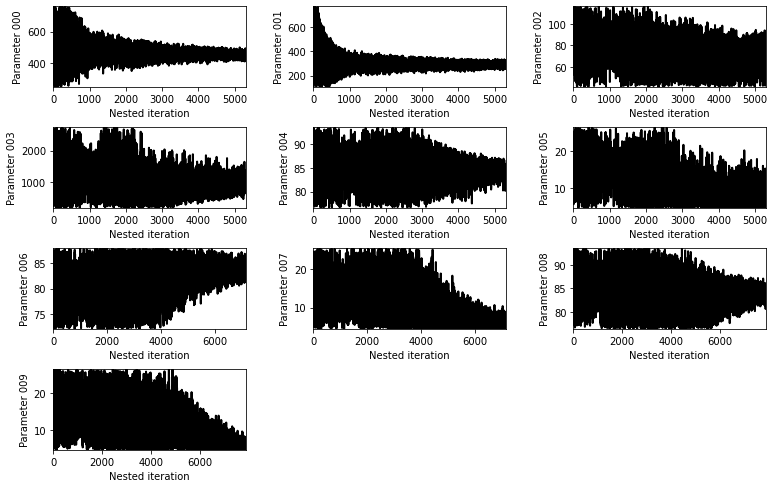

In [11]:
# Here you can see the evolution of the hyperparameters
# through the iterations for a given run
givenstar = '1717'
bg.parameter_evolution(prefix, givenstar, resultsubdir)

# Extra: How to make a summary directory

In [8]:
# Make a summary directory
# You can then run `pdfjam --fitpaper true --rotateoversize true *.pdf` and combine them
summarydir = 'summary_' + resultsubdir
summaryfile = 'summary_' + resultsubdir + '.csv'
if not os.path.exists(summarydir):
    print('Creates', summarydir)
    os.mkdir(summarydir)
for star in starlist:
    resultdir = os.path.join('./results/', prefix + star)
    for f in os.listdir(resultdir):
        if f.endswith('Background.pdf'):
            shutil.copy(os.path.join(resultdir, f), os.path.join(summarydir, f))
print('The total number of successes is', len(starlist))

# Make a summary file
allstars = np.sort(np.asarray(starlist + errorstars + skipstars))
success = np.isin(allstars, np.asarray(starlist))
errors = np.isin(allstars, np.asarray(errorstars))
skipped = np.isin(allstars, np.asarray(skipstars))

notecols = [nl for nl in numaxlist.columns if 'notes' in nl]
notes = []
for star in allstars:
    starmask = (numaxlist['star'] == prefix + str(star))
    for ncol in notecols:
        note = numaxlist[ncol][starmask].values
        if not pd.isnull(note):
            notes.append(star)

noted = np.isin(allstars, np.asarray(notes))

df = pd.DataFrame({'star': allstars,
                   'success': success,
                   'error': errors,
                   'skipped': skipped,
                   'noted': noted})
df.to_csv(summaryfile)

Creates summary_05


NameError: name 'starlist' is not defined